# Comprehensive Contrastive Representation Distillation - CIFAR-100
## Full Analysis: SupCon vs SupCRD vs Memory Bank Ablation
**Goal**: Comprehensive evaluation of contrastive distillation methods on CIFAR-100 with:
- α/β hyperparameter sweeps
- Temperature analysis
- Pull/push force dynamics
- Semantic similarity validation
- **Memory bank ablation** (momentum-based negative sampling)
- **Joint training** (CRD-style teacher projection adaptation)
- **Adaptive β** for confident teachers
- **Switchable architectures**: ConvNet vs ResNet-18

**Methods**:
- **Undistilled Student**: Baseline (no teacher)
- **Baseline CRD**: Standard instance matching
- **Baseline SupCon**: Standard supervised contrastive learning
- **LW-SupCRD**: Logit-weighted representation distillation (α, β tuning)
- **Memory Bank Ablation**:
  - baseline_crd_nobank vs baseline_crd_bank4096
  - lwsupcrd_nobank vs lwsupcrd_bank4096
  - Tests whether momentum memory banks (K=4096) improve uniformity beyond semantic weighting

---
## Setup & Imports



In [1]:
import json
import math
import os
import random
import warnings

import detectors  # it may not be used directly but timm needs it
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from plotly.subplots import make_subplots
from scipy.spatial.distance import pdist
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader

os.environ["TQDM_NOTEBOOK"] = "0"
from tqdm import tqdm

# Create directories
os.makedirs("plots", exist_ok=True)
os.makedirs("pth_models", exist_ok=True)
os.makedirs("json_results", exist_ok=True)
os.makedirs("json_results/training_logs", exist_ok=True)
print("✓ Created directories: plots/, pth_models/, json_results/")

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)
print(f"Random seed set to 42 for reproducibility")

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
warnings.filterwarnings("ignore", category=RuntimeWarning, module="threadpoolctl")

/venv/main/lib/python3.12/site-packages/outdated/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


✓ Created directories: plots/, pth_models/, json_results/
Using device: cuda
Random seed set to 42 for reproducibility


---
## Architecture Selection & Hyperparameters

**KEY CONFIGURATION**: Set your architecture choice here



In [2]:
# ============================================================
# ARCHITECTURE SELECTION (CHANGE HERE)
# ============================================================
TEACHER_ARCH = "resnet50"  # Options: "convnet" or "resnet50"
STUDENT_ARCH = "resnet18"  # Options: "convnet" or "resnet18"

# ============================================================
# TRAINING CONFIGURATION
# ============================================================
BATCH_SIZE = 128
LR = 1e-3

# Epoch settings (adjust based on architecture)
if TEACHER_ARCH == "resnet50" or TEACHER_ARCH == "resnet18":
    EPOCHS_TEACHER = 50
    EPOCHS_STUDENT = 50
    USE_LR_SCHEDULER = True
else:
    EPOCHS_TEACHER = 20  # ConvNet
    EPOCHS_STUDENT = 40
    USE_LR_SCHEDULER = False

# ============================================================
# CONTRASTIVE & DISTILLATION CONFIG
# ============================================================
TEMP = 0.07
ALPHA = 1.0
BETA = 10.0

# Sweep ranges (reduced for faster iteration)
ALPHA_SWEEP = [1.0, 2.0, 5.0, 10.0]
BETA_SWEEP = [1.0, 5.0, 10.0, 12.0]  
TEMP_SWEEP = [0.05, 0.07]
LAMBDA_SWEEP = [0.3, 0.5, 0.7, 0.9]

# ============================================================
# DATASET CONFIG (CIFAR-100)
# ============================================================
num_classes = 100

CIFAR100_CLASSES = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

# CIFAR-100 superclass mapping (20 superclasses, 5 classes each)
cifar100_superclasses = [
    "aquatic_mammals",
    "fish",
    "flowers",
    "food_containers",
    "fruit_vegetables",
    "household_electrical",
    "household_furniture",
    "insects",
    "large_carnivores",
    "large_omnivores",
    "medium_mammals",
    "non-insect_invertebrates",
    "people",
    "reptiles",
    "small_mammals",
    "trees",
    "vehicles_1",
    "vehicles_2",
]

# Sample classes for visualization (not all 100)
sample_classes = list(range(20))

print(f"\n{'='*60}")
print(f"CONFIGURATION SUMMARY")
print(f"{'='*60}")
print(f"Teacher Architecture: {TEACHER_ARCH.upper()}")
print(f"Student Architecture: {STUDENT_ARCH.upper()}")
print(f"Dataset: CIFAR-100 ({num_classes} classes)")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LR}")
print(f"Teacher Epochs: {EPOCHS_TEACHER}")
print(f"Student Epochs: {EPOCHS_STUDENT}")
print(f"LR Scheduler: {USE_LR_SCHEDULER}")
print(f"Temperature: {TEMP}")
print(f"Training Mode: Multi-view (2 augmented views per sample)")
print(f"Alpha Sweep: {ALPHA_SWEEP}")
print(f"Beta Sweep: {BETA_SWEEP}")
print(f"Temp Sweep: {TEMP_SWEEP}")
print(f"{'='*60}\n")


class TwoViewTransform:
    """Create two augmented views of the same image"""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        view1 = self.base_transform(x)
        view2 = self.base_transform(x)
        return view1, view2
    
def get_class_name(class_id):
    """Convert class ID to name."""
    return CIFAR100_CLASSES[class_id] if 0 <= class_id < 100 else f"Class {class_id}"


CONFIGURATION SUMMARY
Teacher Architecture: RESNET50
Student Architecture: RESNET18
Dataset: CIFAR-100 (100 classes)
Batch Size: 128
Learning Rate: 0.001
Teacher Epochs: 50
Student Epochs: 50
LR Scheduler: True
Temperature: 0.07
Training Mode: Multi-view (2 augmented views per sample)
Alpha Sweep: [1.0, 2.0, 5.0, 10.0]
Beta Sweep: [1.0, 5.0, 10.0, 12.0]
Temp Sweep: [0.05, 0.07]



---
## Data Loading with Augmentation



In [3]:
# CIFAR-100 mean and std
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

# Base training transform with augmentation
base_transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

# Multi-view wrapper (creates 2 augmented views per sample)
transform_train_multiview = TwoViewTransform(base_transform_train)

# Test transform (no augmentation, single view)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

train_set = torchvision.datasets.CIFAR100(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform_train_multiview  # Multi-view
)
train_loader = DataLoader(
    train_set, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2,
    pin_memory=True
)

test_set = torchvision.datasets.CIFAR100(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform_test
)
test_loader = DataLoader(
    test_set, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2,
    pin_memory=True
)

print(f"Train samples: {len(train_set)}")
print(f"Test samples: {len(test_set)}")
print(f"Training mode: Multi-view (2 augmented views per sample)")
print(f"Augmentation: RandomCrop, HFlip, ColorJitter")



Train samples: 50000
Test samples: 10000
Training mode: Multi-view (2 augmented views per sample)
Augmentation: RandomCrop, HFlip, ColorJitter


---
## Model Architecture (Switchable)

Two architecture options:
1. **ConvNet**: Fast, 3-layer CNN (same as CIFAR-10)
2. **ResNet-18**: Deeper, more capacity, slower training



In [4]:
class ConvEncoder(nn.Module):
    """Shallow 3-layer ConvNet encoder"""

    def __init__(self, feature_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.flat_dim = 128 * 4 * 4
        self.fc = nn.Linear(self.flat_dim, feature_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


class ResNetEncoder(nn.Module):
    """ResNet encoder (adapted for CIFAR)"""

    def __init__(self, feature_dim=512, arch="resnet18"):  # Add arch parameter
        super().__init__()

        # Choose architecture
        if arch == "resnet18":
            resnet = models.resnet18(weights=None)
            base_dim = 512
        elif arch == "resnet50":
            resnet = models.resnet50(weights=None)
            base_dim = 2048  # ResNet50 has 2048-dim features
        else:
            raise ValueError(f"Unknown ResNet arch: {arch}")

        # Replace first conv: kernel 7->3, stride 2->1, remove maxpool
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        # Skip maxpool for CIFAR (small images)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool

        # Project base_dim -> feature_dim if different
        if feature_dim != base_dim:
            self.projection = nn.Linear(base_dim, feature_dim)
        else:
            self.projection = nn.Identity()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.projection(x)
        return x


class ModelWrapper(nn.Module):
    """Wrapper with switchable encoder"""

    def __init__(self, num_classes=100, arch="convnet"):
        super().__init__()
        self.arch = arch

        if arch == "convnet":
            self.encoder = ConvEncoder(feature_dim=128)
            self.feature_dim = 128
        elif arch == "resnet18":
            self.encoder = ResNetEncoder(feature_dim=512, arch="resnet18")
            self.feature_dim = 512
        elif arch == "resnet50":
            self.encoder = ResNetEncoder(feature_dim=512, arch="resnet50")
            self.feature_dim = 512
        else:
            raise ValueError(f"Unknown architecture: {arch}")

        # Projector (for contrastive learning)
        self.projector = nn.Sequential(
            nn.Linear(self.feature_dim, 128), nn.ReLU(), nn.Linear(128, 64)
        )

        # Classifier
        self.classifier = nn.Linear(self.feature_dim, num_classes)

    def forward(self, x):
        feats = self.encoder(x)
        proj = self.projector(feats)
        logits = self.classifier(feats)
        return feats, proj, logits


# Test instantiation
test_teacher = ModelWrapper(num_classes=100, arch=TEACHER_ARCH).to(device)
test_student = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)

print(f"✓ Model architectures defined")
print(f"  Teacher: {TEACHER_ARCH.upper()} ({test_teacher.feature_dim}-dim features)")
print(f"  Student: {STUDENT_ARCH.upper()} ({test_student.feature_dim}-dim features)")

# Count parameters
teacher_params = sum(p.numel() for p in test_teacher.parameters())
student_params = sum(p.numel() for p in test_student.parameters())
print(f"  Teacher params: {teacher_params:,}")
print(f"  Student params: {student_params:,}")

del test_teacher, test_student



✓ Model architectures defined
  Teacher: RESNET50 (512-dim features)
  Student: RESNET18 (512-dim features)
  Teacher params: 24,674,660
  Student params: 11,294,052


---
## Loss Functions



In [5]:
class SupConLoss(nn.Module):
    """Baseline Supervised Contrastive Loss"""

    def __init__(self, temperature=0.07):
        super().__init__()
        self.temp = temperature

    def forward(self, student_proj, labels):
        feats = F.normalize(student_proj, dim=1)
        sim_matrix = torch.matmul(feats, feats.T) / self.temp
        labels = labels.view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(feats.shape[0]).view(-1, 1).to(device),
            0,
        )
        mask = mask * logits_mask
        logits_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - logits_max.detach()
        exp_logits = torch.exp(sim_matrix) * logits_mask
        log_prob = sim_matrix - torch.log(exp_logits.sum(1, keepdim=True))
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-8)
        return -mean_log_prob_pos.mean()


class LogitWeightedSupCRDLoss(nn.Module):
    """SupCRD with α/β weighting + GRADIENT FIX + ADAPTIVE β"""

    def __init__(self, alpha=1.0, beta=1.0, temperature=0.07, eps=1e-8, adaptive_beta=False):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.tau = temperature
        self.eps = eps
        self.adaptive_beta = adaptive_beta

    def forward(self, student_features, teacher_features, teacher_logits, labels):
        batch_size = student_features.shape[0]
        device = student_features.device

        s_norm = F.normalize(student_features, dim=1)
        t_norm = F.normalize(teacher_features, dim=1)

        sim_matrix = torch.matmul(s_norm, t_norm.T) / self.tau
        sim_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - sim_max.detach()
        exp_sim = torch.exp(sim_matrix)

        teacher_probs = F.softmax(teacher_logits, dim=1)
        labels = labels.view(-1, 1)
        mask_pos = torch.eq(labels, labels.T).float().to(device)
        mask_neg = 1.0 - mask_pos

        # Pull weight
        p_target = torch.gather(teacher_probs, 1, labels).view(-1)
        w_pull = self.alpha * p_target

        # Push weight - WITH ADAPTIVE β FIX
        target_labels_expand = labels.view(1, -1).expand(batch_size, -1)
        p_negative_class = torch.gather(teacher_probs, 1, target_labels_expand)
        
        if self.adaptive_beta:
            # Adaptive β: scale by (1 - confidence)
            beta_effective = self.beta / (p_target + 0.5)
            w_push = beta_effective.view(-1, 1) * (1.0 - p_negative_class)
        else:
            w_push = self.beta * (1.0 - p_negative_class)

        sum_pos_exp = (exp_sim * mask_pos).sum(dim=1)
        numerator_term = w_pull * sum_pos_exp
        weighted_neg_exp = (exp_sim * w_push * mask_neg).sum(dim=1)
        denominator_term = numerator_term + weighted_neg_exp

        loss = -torch.log((numerator_term + self.eps) / (denominator_term + self.eps))
        
        # Normalize by α to restore gradient magnitude
        loss = loss / self.alpha
        
        return loss.mean()


class BaseCRDLoss(nn.Module):
    """
    Standard CRD: Instance matching (Student(img_i) -> Teacher(img_i))
    Note: Implemented as in-batch contrastive learning (SimCLR-style) 
    rather than memory-bank NCE for fair comparison with SupCon.
    """
    
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temp = temperature
    
    def forward(self, student_proj, teacher_proj, labels):
        batch_size = student_proj.shape[0]
        s_norm = F.normalize(student_proj, dim=1)
        t_norm = F.normalize(teacher_proj, dim=1)
        
        sim_matrix = torch.matmul(s_norm, t_norm.T) / self.temp
        
        # Positive mask: diagonal only (instance matching)
        mask_pos = torch.eye(batch_size).to(student_proj.device)
        
        sim_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - sim_max.detach()
        exp_sim = torch.exp(sim_matrix)
        
        numerator = (exp_sim * mask_pos).sum(dim=1)
        denominator = exp_sim.sum(dim=1)
        
        loss = -torch.log(numerator / (denominator + 1e-8))
        return loss.mean()


class HybridSupCRDLoss(nn.Module):
    """Hybrid: λ * SupCon + (1-λ) * SupCRD"""

    def __init__(self, alpha=1.0, beta=10.0, lambda_supcon=0.7, temperature=0.07, adaptive_beta=False):
        super().__init__()
        self.supcon_loss = SupConLoss(temperature=temperature)
        self.supcrd_loss = LogitWeightedSupCRDLoss(
            alpha=alpha, beta=beta, temperature=temperature, adaptive_beta=adaptive_beta
        )
        self.lambda_supcon = lambda_supcon
        self.register_buffer("supcon_scale", torch.tensor(1.0))
        self.register_buffer("supcrd_scale", torch.tensor(1.0))
        self.warmup_steps = 100
        self.step_count = 0

    def forward(self, student_proj, teacher_proj, teacher_logits, labels):
        loss_supcon = self.supcon_loss(student_proj, labels)
        loss_supcrd = self.supcrd_loss(
            student_proj, teacher_proj, teacher_logits, labels
        )
        if self.step_count < self.warmup_steps:
            self.step_count += 1
            with torch.no_grad():
                self.supcon_scale = 0.9 * self.supcon_scale + 0.1 * loss_supcon.detach()
                self.supcrd_scale = 0.9 * self.supcrd_scale + 0.1 * loss_supcrd.detach()
        loss_supcon_norm = loss_supcon / (self.supcon_scale + 1e-8)
        loss_supcrd_norm = loss_supcrd / (self.supcrd_scale + 1e-8)
        return (
            self.lambda_supcon * loss_supcon_norm
            + (1 - self.lambda_supcon) * loss_supcrd_norm
        )


print("✓ Loss functions defined (with α gradient fix + adaptive β)")



✓ Loss functions defined (with α gradient fix + adaptive β)


---
## Utility Functions



In [6]:
def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # If the model returns a tuple (feats, proj, logits), take logits
            if isinstance(output, tuple):
                output = output[2]  # logits is the 3rd element (index 2)

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total


def extract_features_and_labels(model, loader, device, max_samples=5000):
    """Extract features and labels for visualization. OPTIMIZED for fast feature extraction."""
    model.eval()

    # ========== OPTIMIZE FEATURE EXTRACTION ==========
    # Create efficient feature extractor based on model type
    if hasattr(model, "encoder"):
        # Student: direct access via ModelWrapper
        def extract_features(images):
            _, proj, _ = model(images)
            return proj

    else:
        # Teacher: try forward_features first (much faster!)
        if hasattr(model, "forward_features"):

            def extract_features(images):
                features = model.forward_features(images)

                # Forward_features returns 4D tensor [B, C, H, W]
                # Need to flatten to 2D [B, C] before projection
                if features.dim() == 4:
                    # Global average pooling: [B, C, H, W] -> [B, C]
                    features = F.adaptive_avg_pool2d(features, (1, 1)).flatten(1)

                if hasattr(model, "projection"):
                    return model.projection(features)
                return features

        else:
            # Fallback: standard forward (handles tuples)
            def extract_features(images):
                output = model(images)
                if isinstance(output, tuple):
                    _, proj, _ = output
                    return proj
                return output

    features_list = []
    labels_list = []
    count = 0

    with torch.no_grad():
        for images, labels in loader:
            if count >= max_samples:
                break
            images = images.to(device)
            proj = extract_features(images)
            features_list.append(proj.cpu().numpy())
            labels_list.append(labels.numpy())
            count += images.size(0)

    features = np.concatenate(features_list, axis=0)[:max_samples]
    labels = np.concatenate(labels_list, axis=0)[:max_samples]
    return features, labels


def visualize_latents(
    model, loader, device, title="", sample_classes=None, max_samples=5000
):
    """Visualize latent space with t-SNE (sample subset for CIFAR-100)."""
    features, labels = extract_features_and_labels(model, loader, device, max_samples)

    # If sample_classes specified, only visualize those
    if sample_classes is not None:
        mask = np.isin(labels, sample_classes)
        features = features[mask]
        labels = labels[mask]
        print(f"  Visualizing {len(sample_classes)} classes, {len(features)} samples")

    print(f"  Running t-SNE on {len(features)} samples...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features) - 1))
    embedded = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(labels)

    for label in unique_labels:
        mask = labels == label
        plt.scatter(
            embedded[mask, 0],
            embedded[mask, 1],
            label=get_class_name(int(label)),
            alpha=0.6,
            s=20,
        )

    plt.title(f"t-SNE: {title}", fontsize=14, fontweight="bold")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    if len(unique_labels) <= 20:
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
    plt.tight_layout()

    safe_title = title.replace(" ", "_").replace("/", "_")
    # Ensure plots directory exists
    os.makedirs("plots", exist_ok=True)
    plt.savefig(f"plots/tsne_{safe_title}.png", dpi=150, bbox_inches="tight")
    plt.show()


def visualize_alignment_uniformity(
    teacher, test_loader, device, title="Cosine Projection", save_path=None
):
    """
    Visualize alignment and uniformity following Wang & Isola 2020.
    Combines accurate Wang & Isola metrics with intuitive circular visualizations.
    OPTIMIZED: Fast feature extraction + vectorized uniformity computation.
    """
    warnings.filterwarnings(
        "ignore",
        message="This figure includes Axes that are not compatible with tight_layout",
    )

    teacher.eval()

    # Create efficient feature extractor based on model type
    if hasattr(teacher, "encoder"):
        # Student: direct access via ModelWrapper
        def extract_features(images):
            features = teacher.encoder(images)
            proj = teacher.projector(features)
            return F.normalize(proj, dim=1)

    else:
        # Teacher: try forward_features first (much faster!)
        if hasattr(teacher, "forward_features"):

            def extract_features(images):
                features = teacher.forward_features(images)
                # Flatten 4D to 2D if needed
                if features.dim() == 4:
                    features = F.adaptive_avg_pool2d(features, (1, 1)).flatten(1)
                proj = teacher.projection(features)
                return F.normalize(proj, dim=1)

        else:
            # Fallback: fc surgery (slower but works)
            print("⚠️ Using fc surgery for feature extraction (slower)")

            def extract_features(images):
                if hasattr(teacher, "fc"):
                    original_fc = teacher.fc
                    teacher.fc = nn.Identity()
                    features = teacher(images)
                    teacher.fc = original_fc
                elif hasattr(teacher, "classifier"):
                    original_classifier = teacher.classifier
                    teacher.classifier = nn.Identity()
                    features = teacher(images)
                    teacher.classifier = original_classifier
                else:
                    features = teacher(images)

                if hasattr(teacher, "projection"):
                    proj = teacher.projection(features)
                    return F.normalize(proj, dim=1)
                else:
                    print("⚠️ Teacher has no projection head!")
                    return None

    # Collect projections using optimized extractor
    all_projections = []
    all_labels = []
    print("Extracting projections for alignment/uniformity analysis...")
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Extracting"):
            images = images.to(device)
            proj = extract_features(images)
            if proj is None:
                return
            all_projections.append(proj.cpu())
            all_labels.append(labels)

    projections = torch.cat(all_projections, dim=0).numpy()
    labels = torch.cat(all_labels, dim=0).numpy()
    print(f"Projections shape: {projections.shape}")

    # ========== COMPUTE METRICS ==========

    # 1. ALIGNMENT: Positive pair distances
    print("Computing alignment (positive pair distances)...")
    positive_distances = []

    for class_id in tqdm(range(100), desc="Alignment"):
        mask = labels == class_id
        class_projs = projections[mask]

        if len(class_projs) > 1:
            for i in range(len(class_projs)):
                for j in range(i + 1, len(class_projs)):
                    dist = np.linalg.norm(class_projs[i] - class_projs[j])
                    positive_distances.append(dist)

    positive_distances = np.array(positive_distances)
    if len(positive_distances) > 0:
        alignment_loss = np.mean(positive_distances**2)
        alignment_mean = positive_distances.mean()
    else:
        alignment_loss = 0.0
        alignment_mean = 0.0

    # 2. UNIFORMITY: Pairwise exponential distances
    print("Computing uniformity (vectorized pairwise distances)...")
    num_samples = min(5000, len(projections))
    sample_indices = np.random.choice(len(projections), num_samples, replace=False)
    sample_projs = projections[sample_indices]

    pairwise_dists_sq = pdist(sample_projs, metric="euclidean") ** 2
    uniformity_sum = np.sum(np.exp(-2 * pairwise_dists_sq))
    count = len(pairwise_dists_sq)
    uniformity_loss = np.log(uniformity_sum / count) if count > 0 else 0.0

    # 3. ANGULAR DISTRIBUTION (for visualization)
    print("Computing angular distribution...")

    pca = PCA(n_components=2)
    proj_2d = pca.fit_transform(projections)
    proj_2d_norm = proj_2d / (np.linalg.norm(proj_2d, axis=1, keepdims=True) + 1e-8)
    angles_all = np.arctan2(proj_2d_norm[:, 1], proj_2d_norm[:, 0])

    # ========== PRINT RESULTS ==========
    print(f"\n{'='*60}")
    print(f"WANG & ISOLA METRICS: {title}")
    print(f"{'='*60}")
    print(f"Alignment Loss (↓ better):     {alignment_loss:.4f}")
    print(f"  → Avg positive pair distance²")
    print(f"\nUniformity Loss (↓ better):    {uniformity_loss:.4f}")
    print(f"  → log(E[exp(-2||zi - zj||²)])")
    print(f"\n{'='*60}")
    print(f"SUPPLEMENTARY METRICS")
    print(f"{'='*60}")
    print(f"Alignment mean ℓ2:             {alignment_mean:.4f}")
    print(f"Alignment std:                 {positive_distances.std():.4f}")
    print(f"Angle std:                     {angles_all.std():.4f}")
    print(f"{'='*60}\n")

    # ========== COMPREHENSIVE VISUALIZATION ==========
    sample_classes = [0, 3, 6, 9]

    fig = plt.figure(figsize=(20, 8))
    gs = fig.add_gridspec(2, 7, hspace=0.35, wspace=0.4)

    # Row 0, Col 0-1: Alignment histogram
    ax_align = fig.add_subplot(gs[0, 0:2])
    ax_align.hist(positive_distances**2, bins=50, alpha=0.7, edgecolor="black")
    ax_align.axvline(
        alignment_loss,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {alignment_loss:.4f}",
    )
    ax_align.set_xlabel("ℓ₂ Distance²", fontsize=12)
    ax_align.set_ylabel("Counts", fontsize=12)
    ax_align.set_title(
        "Alignment\nPositive Pair Feature Distances", fontsize=14, fontweight="bold"
    )
    ax_align.legend()
    ax_align.grid(True, alpha=0.3)

    # Row 0, Col 2: Uniformity circle (overall)
    ax_unif_circle = fig.add_subplot(gs[0, 2])
    scatter = ax_unif_circle.scatter(
        proj_2d_norm[:, 0], proj_2d_norm[:, 1], c=labels, cmap="tab20", s=1, alpha=0.5
    )
    ax_unif_circle.set_xlim(-1.2, 1.2)
    ax_unif_circle.set_ylim(-1.2, 1.2)
    ax_unif_circle.set_aspect("equal")
    ax_unif_circle.set_title(
        "Uniformity\nFeature Distribution", fontsize=14, fontweight="bold"
    )
    ax_unif_circle.set_xlabel("Features", fontsize=12)
    circle = plt.Circle(
        (0, 0), 1.0, fill=False, color="black", linestyle="--", linewidth=1
    )
    ax_unif_circle.add_patch(circle)

    # Row 1, Col 0-1: Alignment density
    ax_align_dens = fig.add_subplot(gs[1, 0:2])
    if len(positive_distances) > 10:
        kde_pos = gaussian_kde(positive_distances**2)
        x_pos = np.linspace(0, max(positive_distances**2), 500)
        ax_align_dens.plot(x_pos, kde_pos(x_pos), linewidth=2, color="blue")
        ax_align_dens.fill_between(x_pos, kde_pos(x_pos), alpha=0.3)
        ax_align_dens.axvline(
            alignment_loss,
            color="red",
            linestyle="--",
            linewidth=2,
            label=f"Mean: {alignment_loss:.4f}",
        )
        ax_align_dens.set_xlabel("Distance²", fontsize=12)
        ax_align_dens.set_ylabel("Density", fontsize=12)
        ax_align_dens.legend()
        ax_align_dens.grid(True, alpha=0.3)

    # Row 1, Col 2: Uniformity angles histogram
    ax_unif_angles = fig.add_subplot(gs[1, 2])
    ax_unif_angles.hist(angles_all, bins=50, alpha=0.7, edgecolor="black")
    ax_unif_angles.set_xlabel("Angles", fontsize=12)
    ax_unif_angles.set_ylabel("Counts", fontsize=12)
    ax_unif_angles.grid(True, alpha=0.3)

    # Row 0, Col 3-6: Per-class circles
    # Row 1, Col 3-6: Per-class angle histograms
    for idx, class_id in enumerate(sample_classes):
        mask = labels == class_id
        class_proj_2d = proj_2d_norm[mask]
        class_angles = np.arctan2(class_proj_2d[:, 1], class_proj_2d[:, 0])
        class_name = get_class_name(class_id)

        # Circle plot (row 0)
        ax_class_circle = fig.add_subplot(gs[0, 3 + idx])
        ax_class_circle.scatter(
            class_proj_2d[:, 0], class_proj_2d[:, 1], s=10, alpha=0.6, c=f"C{idx}"
        )
        ax_class_circle.set_xlim(-1.2, 1.2)
        ax_class_circle.set_ylim(-1.2, 1.2)
        ax_class_circle.set_aspect("equal")
        ax_class_circle.set_title(class_name, fontsize=12)
        ax_class_circle.set_xlabel("Features", fontsize=10)
        circle = plt.Circle(
            (0, 0), 1.0, fill=False, color="black", linestyle="--", linewidth=1
        )
        ax_class_circle.add_patch(circle)

        # Angle histogram (row 1)
        ax_class_angles = fig.add_subplot(gs[1, 3 + idx])
        ax_class_angles.hist(
            class_angles, bins=20, alpha=0.7, edgecolor="black", color=f"C{idx}"
        )
        ax_class_angles.set_xlabel("Angles", fontsize=10)
        ax_class_angles.set_ylabel("Counts", fontsize=10)
        ax_class_angles.grid(True, alpha=0.3)

    # Title
    fig.suptitle(
        f"{title} - Alignment & Uniformity Analysis",
        fontsize=16,
        fontweight="bold",
        y=0.98,
    )

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print(f"✓ Saved comprehensive visualization to {save_path}")
    plt.show()

    return {
        "alignment": alignment_loss,
        "uniformity": uniformity_loss,
        "alignment_mean": alignment_mean,
        "alignment_std": positive_distances.std(),
        "angle_std": angles_all.std(),
    }


def visualize_hypersphere_distribution(
    teacher,
    test_loader,
    device,
    title="Hypersphere",
    save_path=None,
    num_classes=100,
    display_classes=5,
):
    """
    Visualize how teacher projections are distributed on unit hypersphere in 3D (INTERACTIVE).
    Shows alignment (cluster tightness) vs uniformity (class separation).
    Uses PCA to reduce to 3D and projects onto sphere surface.
    Creates interactive Plotly visualization that can be rotated with mouse.
    OPTIMIZED: Fast feature extraction.
    """
    teacher.eval()

    # ========== OPTIMIZE FEATURE EXTRACTION ==========
    # Create efficient feature extractor based on model type
    if hasattr(teacher, "encoder"):
        # Student: direct access via ModelWrapper
        def extract_features(images):
            features = teacher.encoder(images)
            proj = teacher.projector(features)
            return F.normalize(proj, dim=1)

    else:
        # Teacher: try forward_features first (much faster!)
        if hasattr(teacher, "forward_features"):

            def extract_features(images):
                features = teacher.forward_features(images)
                if features.dim() == 4:
                    features = F.adaptive_avg_pool2d(features, (1, 1)).flatten(1)
                proj = teacher.projection(features)
                return F.normalize(proj, dim=1)

        else:
            # Fallback: fc surgery (slower but works)
            print("⚠️ Using fc surgery for feature extraction (slower)")

            def extract_features(images):
                original_fc = teacher.fc
                teacher.fc = nn.Identity()
                features = teacher(images)
                teacher.fc = original_fc
                if hasattr(teacher, "projection"):
                    proj = teacher.projection(features)
                    return F.normalize(proj, dim=1)
                else:
                    print("⚠️ Teacher has no projection head!")
                    return None

    # Collect projections using optimized extractor
    all_projections = []
    all_labels = []
    print("Extracting projections from test set...")
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Extracting"):
            images = images.to(device)
            proj = extract_features(images)
            if proj is None:
                return
            all_projections.append(proj.cpu())
            all_labels.append(labels)

    # Concatenate
    projections = torch.cat(all_projections, dim=0).numpy()
    labels = torch.cat(all_labels, dim=0).numpy()

    print(f"Projections shape: {projections.shape}")
    print(
        f"Projection norms (should be ~1.0): min={np.linalg.norm(projections, axis=1).min():.4f}, max={np.linalg.norm(projections, axis=1).max():.4f}"
    )

    # Two-stage PCA
    print("Running PCA to reduce dimensionality...")
    pca_high = PCA(n_components=10, random_state=42)
    projections_10d = pca_high.fit_transform(projections)
    pca_3d = PCA(n_components=3, random_state=42)
    projections_3d = pca_3d.fit_transform(projections_10d)

    # Normalize to unit sphere
    norms = np.linalg.norm(projections_3d, axis=1, keepdims=True)
    projections_3d = projections_3d / (norms + 1e-8)

    # Report variance
    variance_10d = pca_high.explained_variance_ratio_.sum()
    variance_3d_of_10d = pca_3d.explained_variance_ratio_.sum()
    total_variance = pca_high.explained_variance_ratio_[:3].sum()
    print(f"PCA Stage 1 (64D → 10D): {variance_10d:.2%} variance captured")
    print(f"PCA Stage 2 (10D → 3D): {variance_3d_of_10d:.2%} of 10D captured")
    print(f"Total variance in 3D: {total_variance:.2%} of original 64D")

    # Create sphere wireframe
    u = np.linspace(0, 2 * np.pi, 40)
    v = np.linspace(0, np.pi, 30)
    x_sphere = np.outer(np.cos(u), np.sin(v))
    y_sphere = np.outer(np.sin(u), np.sin(v))
    z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

    # Create single plot
    fig = go.Figure()

    # Add sphere wireframe
    fig.add_trace(
        go.Surface(
            x=x_sphere,
            y=y_sphere,
            z=z_sphere,
            opacity=0.08,
            colorscale=[[0, "lightgray"], [1, "lightgray"]],
            showscale=False,
            hoverinfo="skip",
            name="Sphere",
        )
    )

    # Sample classes
    sample_classes = np.random.choice(num_classes, display_classes, replace=False)
    colors_discrete = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
    ]

    for idx, class_id in enumerate(sample_classes):
        mask = labels == class_id
        class_name = get_class_name(int(class_id))
        fig.add_trace(
            go.Scatter3d(
                x=projections_3d[mask, 0],
                y=projections_3d[mask, 1],
                z=projections_3d[mask, 2],
                mode="markers",
                marker=dict(
                    size=5,
                    color=colors_discrete[idx % len(colors_discrete)],
                    opacity=0.8,
                    line=dict(color="black", width=0.5),
                ),
                name=class_name,
                text=[class_name for _ in range(mask.sum())],
                hovertemplate="<b>%{text}</b><br>PC1: %{x:.3f}<br>PC2: %{y:.3f}<br>PC3: %{z:.3f}<extra></extra>",
            )
        )

    # Layout
    fig.update_layout(
        title=dict(
            text=f"{title} - 3D Hypersphere ({display_classes} Classes)",
            font=dict(size=14, color="black"),
            x=0.5,
            xanchor="center",
        ),
        width=800,
        height=600,
        showlegend=True,
        legend=dict(
            x=1.0,
            y=0.5,
            font=dict(size=9),
            bgcolor="rgba(255,255,255,0.9)",
            bordercolor="gray",
            borderwidth=1,
        ),
        margin=dict(l=0, r=120, t=60, b=0),
        paper_bgcolor="white",
        scene=dict(
            xaxis=dict(
                title=dict(text="PC1", font=dict(size=10)),
                showgrid=True,
                gridcolor="lightgray",
                backgroundcolor="white",
            ),
            yaxis=dict(
                title=dict(text="PC2", font=dict(size=10)),
                showgrid=True,
                gridcolor="lightgray",
                backgroundcolor="white",
            ),
            zaxis=dict(
                title=dict(text="PC3", font=dict(size=10)),
                showgrid=True,
                gridcolor="lightgray",
                backgroundcolor="white",
            ),
            aspectmode="cube",
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.3)),
        ),
    )

    # Save HTML
    if save_path:
        html_path = save_path.replace(".png", ".html")
        fig.write_html(html_path)
        print(f"✓ Saved interactive plot to {html_path}")
        print(f"   → Open in browser to view and rotate")

    # Show with error handling
    try:
        fig.show()
    except Exception as e:
        print(f"⚠️ Could not display inline (install nbformat)")
        if save_path:
            html_path = save_path.replace(".png", ".html")
            print(f"   → Open saved HTML: {html_path}")

    # Compute metrics
    print("\n" + "=" * 60)
    print("HYPERSPHERE DISTRIBUTION METRICS")
    print("=" * 60)

    # Intra-class distances
    intra_class_dists = []
    for class_id in range(num_classes):
        mask = labels == class_id
        if mask.sum() > 1:
            class_projs = projections[mask]
            dists = pdist(class_projs, metric="cosine")
            intra_class_dists.extend(dists)
    avg_intra = np.mean(intra_class_dists)

    # Inter-class distances
    class_centroids = []
    for class_id in range(num_classes):
        mask = labels == class_id
        if mask.sum() > 0:
            centroid = projections[mask].mean(axis=0)
            centroid = centroid / (np.linalg.norm(centroid) + 1e-8)
            class_centroids.append(centroid)
    class_centroids = np.array(class_centroids)
    inter_class_dists = pdist(class_centroids, metric="cosine")
    avg_inter = np.mean(inter_class_dists)

    print(f"Avg Intra-Class Distance (cosine): {avg_intra:.4f}")
    print(f"  → Lower = better ALIGNMENT (tight clusters)")
    print(f"\nAvg Inter-Class Distance (cosine): {avg_inter:.4f}")
    print(f"  → Higher = better UNIFORMITY (well separated)")
    print(f"\nSeparation Ratio (inter/intra): {avg_inter/avg_intra:.4f}")
    print(f"  → Higher = better overall (clear clusters)")
    print("=" * 60)

    return {
        "intra_class_dist": avg_intra,
        "inter_class_dist": avg_inter,
        "separation_ratio": avg_inter / avg_intra,
    }


def compute_class_centroids(model, loader, device, num_classes=100):
    """Compute class centroids in feature space."""
    model.eval()
    centroids = {i: [] for i in range(num_classes)}

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)

            output = model(images)
            if isinstance(output, tuple):
                _, proj, _ = output
            else:
                proj = output

            proj_norm = F.normalize(proj, dim=1)

            for i in range(len(labels)):
                label = labels[i].item()
                centroids[label].append(proj_norm[i].cpu().numpy())

    # Average to get centroid
    for cls in centroids:
        if len(centroids[cls]) > 0:
            centroids[cls] = np.mean(centroids[cls], axis=0)
        else:
            # Fallback for empty classes (size depends on model output, typically 2048 for ResNet50)
            centroids[cls] = np.zeros(2048)

    return centroids


def analyze_similarity(model, loader, device, class_pairs, title=""):
    """Analyze cosine similarity between specific class pairs."""
    centroids = compute_class_centroids(model, loader, device)

    print(f"\n{'='*60}")
    print(f"Semantic Similarity Analysis: {title}")
    print(f"{'='*60}")

    results = {}
    for cls1, cls2, desc in class_pairs:
        c1 = centroids[cls1]
        c2 = centroids[cls2]
        similarity = np.dot(c1, c2) / (np.linalg.norm(c1) * np.linalg.norm(c2) + 1e-8)
        results[f"{cls1}-{cls2}"] = similarity
        print(f"  {desc:30s}: {similarity:.3f}")

    print(f"{'='*60}\n")
    return results


def save_training_log(log_data, filename):
    """Save training log to JSON."""
    os.makedirs("json_results/training_logs", exist_ok=True)
    with open(f"json_results/training_logs/{filename}.json", "w") as f:
        json.dump(log_data, f, indent=2)


def load_training_log(filename):
    """Load training log from JSON."""
    path = f"json_results/training_logs/{filename}.json"
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None


print("✓ Utility functions updated to handle both Tuple and Standard outputs")

✓ Utility functions updated to handle both Tuple and Standard outputs


---
## Training Functions (WITH JOINT TRAINING)



In [7]:
def train_teacher(
    teacher,
    train_loader,
    optimizer,
    criterion,
    device,
    epochs=10,
    scheduler=None,
    log_name=None,
):
    """Train teacher with optional LR scheduling and multi-view support."""
    print(f"\n{'='*60}")
    print(f"TRAINING TEACHER MODEL ({epochs} epochs)")
    print(f"{'='*60}")

    training_log = {"epochs": [], "train_loss": [], "train_acc": []}
    teacher.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for batch_data in train_loader:
            # Handle both multi-view and single-view data
            if isinstance(batch_data[0], (tuple, list)):
                # Multi-view: ((view1, view2), labels)
                (view1, view2), labels = batch_data
                images = view1.to(device)  # Teacher only needs one view
            else:
                # Single-view (fallback): (images, labels)
                images, labels = batch_data
                images = images.to(device)

            labels = labels.to(device)
            output = teacher(images)
            if isinstance(output, tuple):
                _, _, logits = output  # ModelWrapper
            else:
                logits = output
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        if scheduler is not None:
            scheduler.step()

        avg_loss = total_loss / len(train_loader)
        acc = 100.0 * correct / total
        lr = optimizer.param_groups[0]["lr"]
        print(
            f"Epoch {epoch+1:2d}/{epochs}: Loss={avg_loss:.3f} | Acc={acc:.1f}% | LR={lr:.6f}"
        )

        training_log["epochs"].append(epoch + 1)
        training_log["train_loss"].append(avg_loss)
        training_log["train_acc"].append(acc)

    if log_name:
        save_training_log(training_log, log_name)

    print(f"\n✓ Teacher training complete: {acc:.1f}% accuracy\n")
    return teacher, training_log


def train_projection_head_cosine_probe(
    teacher, train_loader, device, epochs=10, lr=1e-3, temperature=0.07
):
    """
    Train projection head with cosine similarity classification.
    MODIFIED: Keeps projection trainable (no freezing) for joint training later.
    """

    # Freeze backbone ONLY (not projection - we'll train it jointly later)
    for name, param in teacher.named_parameters():
        if 'fc' not in name:  # Freeze everything except fc
            param.requires_grad = False

    # Add trainable projection head (stays trainable!)
    teacher.projection = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
    ).to(device)
    
    print("  ✓ Projection head created (will remain trainable for joint training)")

    # Temporary classifier for training (no bias for pure cosine similarity)
    classifier = nn.Linear(64, 100, bias=False).to(device)

    # Optimizer for both projection and classifier
    optimizer = torch.optim.Adam(
        list(teacher.projection.parameters()) + list(classifier.parameters()), lr=lr
    )

    criterion = nn.CrossEntropyLoss()
    best_loss = float("inf")

    for epoch in range(epochs):
        teacher.train()
        classifier.train()
        total_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f"Cosine Probe Epoch {epoch+1}/{epochs}")

        for batch_data in pbar:
            # Handle multi-view data
            if isinstance(batch_data[0], (tuple, list)):
                (view1, view2), labels = batch_data
                images = view1.to(device)
            else:
                images, labels = batch_data
                images = images.to(device)

            labels = labels.to(device)

            # Get frozen backbone features
            with torch.no_grad():
                original_fc = teacher.fc
                teacher.fc = nn.Identity()
                features = teacher(images)  # [B, 2048]
                teacher.fc = original_fc

            # Project and normalize to unit hypersphere
            proj = teacher.projection(features)  # [B, 64]
            proj_norm = F.normalize(proj, dim=1)  # ||v|| = 1

            # Normalize classifier weights (class prototypes)
            W_norm = F.normalize(classifier.weight, dim=1)  # [100, 64]

            # Cosine similarity classification
            logits = F.linear(proj_norm, W_norm) / temperature  # [B, 100]

            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix(
                {"loss": f"{loss.item():.4f}", "acc": f"{100.*correct/total:.1f}%"}
            )

        avg_loss = total_loss / len(train_loader)
        acc = 100.0 * correct / total
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Acc: {acc:.1f}%")

        if avg_loss < best_loss:
            best_loss = avg_loss

    print(
        f"\nCosine probe training complete. Best loss: {best_loss:.4f}, Final acc: {acc:.1f}%"
    )

    # Remove classifier (not needed during student training)
    del classifier

    # Set to eval mode (but projection stays trainable!)
    teacher.eval()

    return teacher


def train_student_joint(
    teacher,
    student,
    train_loader,
    optimizer_student,
    criterion,
    device,
    epochs=20,
    label="",
    mode="supcrd",
    log_name=None,
    joint_training=True,
):
    """
    Train student with JOINT TRAINING (teacher projection adapts).
    CRITICAL: This is the CRD paper's approach.
    """
    print(f"\n{'='*60}")
    print(f"TRAINING: {label} (mode={mode})")
    if joint_training:
        print(f"JOINT TRAINING: Teacher projection will adapt alongside student")
    else:
        print(f"FIXED TARGET: Teacher projection frozen")
    print(f"{'='*60}\n")

    teacher.eval()  # Batch norm in eval mode (but projection can still train)
    student.train()

    # Linear classifier on frozen features
    linear_classifier = nn.Linear(student.feature_dim, 100).to(device)
    classifier_opt = torch.optim.Adam(linear_classifier.parameters(), lr=LR)
    classifier_criterion = nn.CrossEntropyLoss()

    # NEW: Optimizer for teacher's projection head (joint training)
    optimizer_teacher_proj = None
    if joint_training and hasattr(teacher, 'projection'):
        teacher.projection.train()  # Set projection to train mode
        optimizer_teacher_proj = torch.optim.Adam(
            teacher.projection.parameters(), 
            lr=LR / 10  # Lower LR for stability
        )
        print("  ✓ Teacher projection optimizer created (joint training enabled)")

    # Check teacher type and projection availability
    teacher_is_timm = not hasattr(teacher, "encoder")
    teacher_has_projection = hasattr(teacher, "projection")

    # Only create random projection if teacher doesn't have trained projection
    if teacher_is_timm and not teacher_has_projection:
        teacher_feature_projector = nn.Linear(2048, 64, bias=False).to(device)
        nn.init.xavier_normal_(teacher_feature_projector.weight)
        teacher_feature_projector.eval()
        for param in teacher_feature_projector.parameters():
            param.requires_grad = False
        print("  ⚠ No trained projection found - using random projection")
    elif teacher_has_projection:
        print("  ✓ Teacher has trained projection - will use it")

    training_log = {"epochs": [], "contrastive_loss": [], "train_acc": []}

    for epoch in range(epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        for (view1, view2), labels_batch in tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{epochs}"
        ):
            # Create multiviewed batch: concatenate both views [2N, C, H, W]
            images = torch.cat([view1, view2], dim=0).to(device)
            labels_multi = torch.cat([labels_batch, labels_batch], dim=0).to(device)

            # Zero gradients
            optimizer_student.zero_grad()
            if optimizer_teacher_proj is not None:
                optimizer_teacher_proj.zero_grad()

            # Teacher forward pass - backbone frozen, projection trainable
            with torch.no_grad():
                teacher_output = teacher(images)
                if isinstance(teacher_output, tuple):
                    # ModelWrapper: (features, projection, logits)
                    teacher_features, teacher_proj, teacher_logits = teacher_output
                else:
                    # timm model
                    original_fc = teacher.fc
                    teacher.fc = nn.Identity()
                    teacher_features = teacher(images)  # [batch, 2048] - frozen
                    teacher.fc = original_fc
                    teacher_logits = teacher(images)  # [batch, 100] - frozen
            
            # Projection (trainable) - OUTSIDE no_grad block
            if teacher_has_projection:
                teacher_proj = teacher.projection(teacher_features.detach())
                if epoch == 0 and total == 0:
                    if joint_training:
                        print("  ✓ Using TRAINED projection (joint training)")
                    else:
                        print("  ✓ Using TRAINED projection (frozen)")
            else:
                # Fallback to random projection
                teacher_proj = teacher_feature_projector(teacher_features)
                if epoch == 0 and total == 0:
                    print("  ⚠ Using RANDOM projection (fallback)")

            # Student forward pass on multiviewed batch
            student_features = student.encoder(images)
            student_proj = student.projector(student_features)

            # Compute contrastive loss on multiviewed batch (2N samples)
            if mode == "supcon":
                loss = criterion(student_proj, labels_multi)
            elif mode == "baseline_crd":
                loss = criterion(student_proj, teacher_proj, labels_multi)
            elif mode in ["supcrd", "balanced"]:
                loss = criterion(
                    student_proj, teacher_proj, teacher_logits, labels_multi
                )
            else:
                raise ValueError(f"Unknown mode: {mode}")

            loss.backward()
            optimizer_student.step()
            
            # CRITICAL: Update teacher projection if joint training
            if optimizer_teacher_proj is not None:
                optimizer_teacher_proj.step()
            
            total_loss += loss.item()

            # Train linear classifier on frozen features (use view1 only)
            with torch.no_grad():
                frozen_features = student.encoder(view1.to(device))
            logits = linear_classifier(frozen_features)
            clf_loss = classifier_criterion(logits, labels_batch.to(device))
            classifier_opt.zero_grad()
            clf_loss.backward()
            classifier_opt.step()

            _, predicted = logits.max(1)
            total += labels_batch.size(0)  # Count original batch size (N)
            correct += predicted.eq(labels_batch.to(device)).sum().item()

        avg_loss = total_loss / len(train_loader)
        acc = 100.0 * correct / total
        print(
            f"  [{label}] Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Acc: {acc:.1f}%"
        )

        training_log["epochs"].append(epoch + 1)
        training_log["contrastive_loss"].append(avg_loss)
        training_log["train_acc"].append(acc)

    # Copy trained classifier to student
    student.classifier.load_state_dict(linear_classifier.state_dict())

    # Save training log if name provided
    if log_name:
        save_training_log(training_log, log_name)

    return student, training_log


# Alias for backward compatibility
train_student = train_student_joint

print("✓ Training functions defined (with joint training support)")



✓ Training functions defined (with joint training support)


---
## EXPERIMENT 1: Train Teacher



Loading teacher from pth_models/teacher_resnet50_cifar100.pth

Teacher Test Accuracy: 80.75%


Loading teacher with trained projection
✓ Teacher loaded with trained projection head.
📊 Visualizing teacher's latent space...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


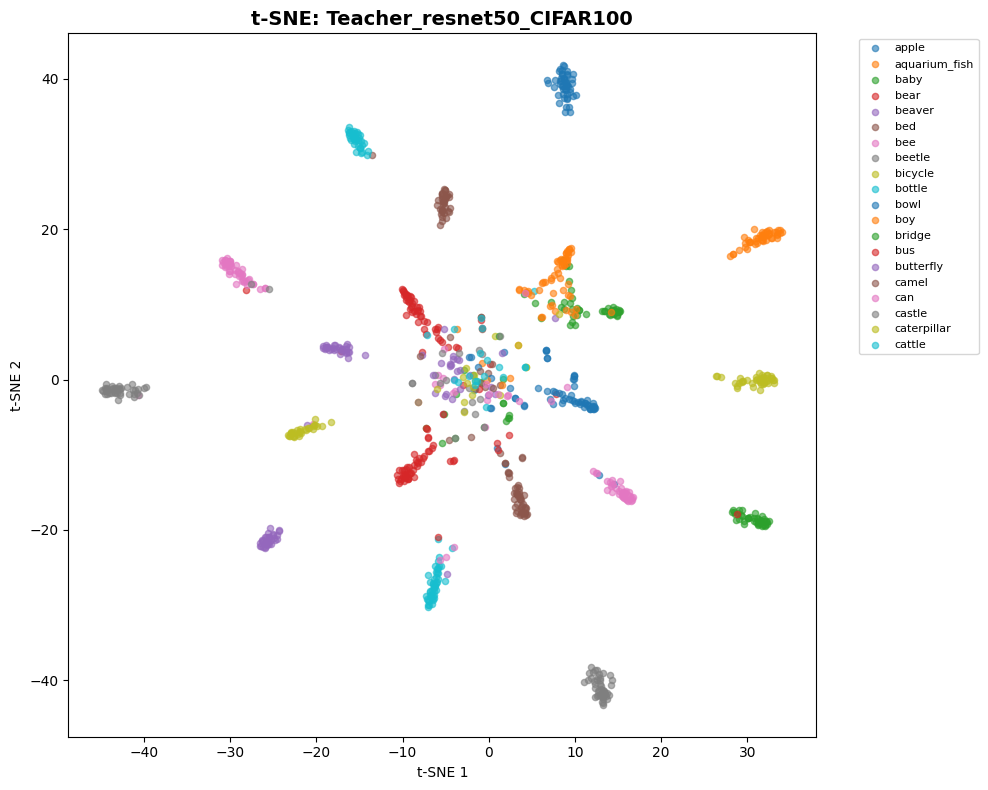

✓ Teacher visualization complete



In [8]:
FORCE_RETRAIN_TEACHER = False
teacher_model_path = f"pth_models/teacher_{TEACHER_ARCH}_cifar100.pth"

if os.path.exists(teacher_model_path) and not FORCE_RETRAIN_TEACHER:
    print(f"Loading teacher from {teacher_model_path}")
    teacher = timm.create_model(
        "resnet50_cifar100", pretrained=False, num_classes=num_classes
    ).to(device)

    checkpoint = torch.load(teacher_model_path, map_location=device)
    new_state_dict = {}
    for k, v in checkpoint.items():
        if k.startswith("final_classifier") or k.startswith("classifier"):
            new_key = k.replace("final_classifier", "fc").replace("classifier", "fc")
        else:
            new_key = k
        new_state_dict[new_key] = v

    msg = teacher.load_state_dict(new_state_dict, strict=False)

    if len(msg.unexpected_keys) > 0:
        print("Cleaning checkpoint (removing auxiliary weights)...")
        torch.save(teacher.state_dict(), teacher_model_path)
else:
    teacher = timm.create_model(
        "resnet50_cifar100", pretrained=False, num_classes=num_classes
    ).to(device)
    optimizer_teacher = torch.optim.Adam(teacher.parameters(), lr=LR)
    criterion_teacher = nn.CrossEntropyLoss()

    scheduler_teacher = None
    if USE_LR_SCHEDULER:
        scheduler_teacher = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer_teacher, T_max=EPOCHS_TEACHER
        )

    teacher, teacher_log = train_teacher(
        teacher,
        train_loader,
        optimizer_teacher,
        criterion_teacher,
        device,
        epochs=EPOCHS_TEACHER,
        scheduler=scheduler_teacher,
        log_name=f"teacher_{TEACHER_ARCH}_cifar100",
    )
    torch.save(teacher.state_dict(), teacher_model_path)

acc_teacher = evaluate_model(teacher, test_loader, device)
print(f"\n{'='*50}")
print(f"Teacher Test Accuracy: {acc_teacher}%")
print(f"{'='*50}\n")

TRAIN_PROJECTION_HEAD = True  # Set to False to use random projection
projection_model_path = (
    f"pth_models/teacher_{TEACHER_ARCH}_cifar100_with_projection.pth"
)

if TRAIN_PROJECTION_HEAD:
    if not os.path.exists(projection_model_path):
        print("\n" + "=" * 60)
        print("TRAINING PROJECTION HEAD (Cosine Linear Probe)")
        print("=" * 60)
        teacher = train_projection_head_cosine_probe(
            teacher, train_loader, device, epochs=10, lr=1e-3, temperature=0.07
        )

        # Save teacher with projection head
        torch.save(teacher.state_dict(), projection_model_path)
        print(f"\n✓ Saved teacher with projection to {projection_model_path}")
    else:
        print(f"\n{'='*60}")
        print(f"Loading teacher with trained projection")
        print(f"{'='*60}")

        # Load checkpoint
        checkpoint_with_proj = torch.load(projection_model_path, map_location=device)

        # Add projection head structure to teacher
        teacher.projection = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
        ).to(device)

        # Load state dict (now includes projection weights)
        teacher.load_state_dict(checkpoint_with_proj, strict=False)
        teacher.to(device)
        teacher.eval()
        print("✓ Teacher loaded with trained projection head.")
else:
    print("\n⚠ Using RANDOM projection (TRAIN_PROJECTION_HEAD=False)")

# Visualize teacher's latent space
print("📊 Visualizing teacher's latent space...")
original_fc = teacher.fc
teacher.fc = nn.Identity()
try:
    visualize_latents(
        teacher,
        test_loader,
        device,
        title=f"Teacher_{TEACHER_ARCH}_CIFAR100",
        sample_classes=sample_classes,
    )
    print("✓ Teacher visualization complete\n")
finally:
    teacher.fc = original_fc



In [9]:
# Visualize the trained projection's hypersphere distribution
metrics = visualize_hypersphere_distribution(
    teacher, 
    test_loader, 
    device,
    title="Teacher Hypersphere Geometry",
    save_path="plots/hypersphere_trained_projection.png"
)



Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 68.14it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 40.35% variance captured
PCA Stage 2 (10D → 3D): 36.33% of 10D captured
Total variance in 3D: 14.66% of original 64D
✓ Saved interactive plot to plots/hypersphere_trained_projection.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.2964
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9515
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 3.2102
  → Higher = better overall (clear clusters)


Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 68.97it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 52.67it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: Teacher with Cosine Projection
Alignment Loss (↓ better):     0.5928
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -3.4649
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             0.6160
Alignment std:                 0.4619
Angle std:                     1.8759

✓ Saved comprehensive visualization to plots/alignment_uniformity_teacher.png


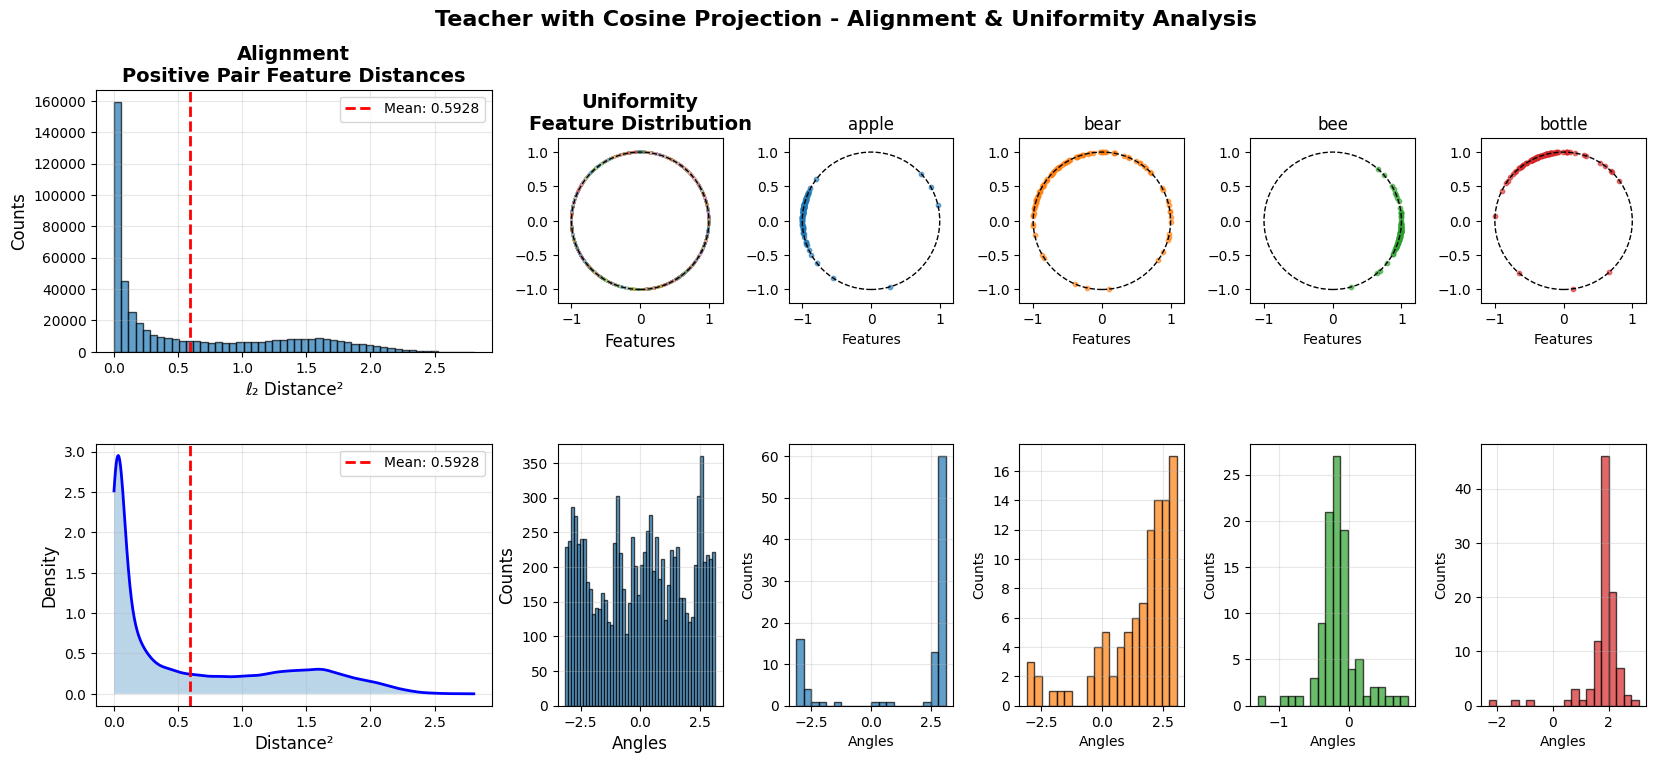

In [10]:
# Visualize alignment & uniformity (Wang & Isola)
metrics = visualize_alignment_uniformity(
    teacher,
    test_loader,
    device,
    title="Teacher with Cosine Projection",
    save_path="plots/alignment_uniformity_teacher.png",
)

---
## EXPERIMENT 2a: Undistilled Student (No Teacher)




EXPERIMENT 2a: UNDISTILLED STUDENT (Baseline)
Loading undistilled student from pth_models/student_undistilled_resnet18_cifar100.pth
  Final training accuracy: 96.86%

Undistilled Student Test Accuracy: 67.93%


UNDISTILLED STUDENT ANALYSIS
⚠️  Note: Projection head has RANDOM weights (never trained)
   These visualizations show what happens WITHOUT contrastive learning

📊 Visualizing undistilled student's projection space...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


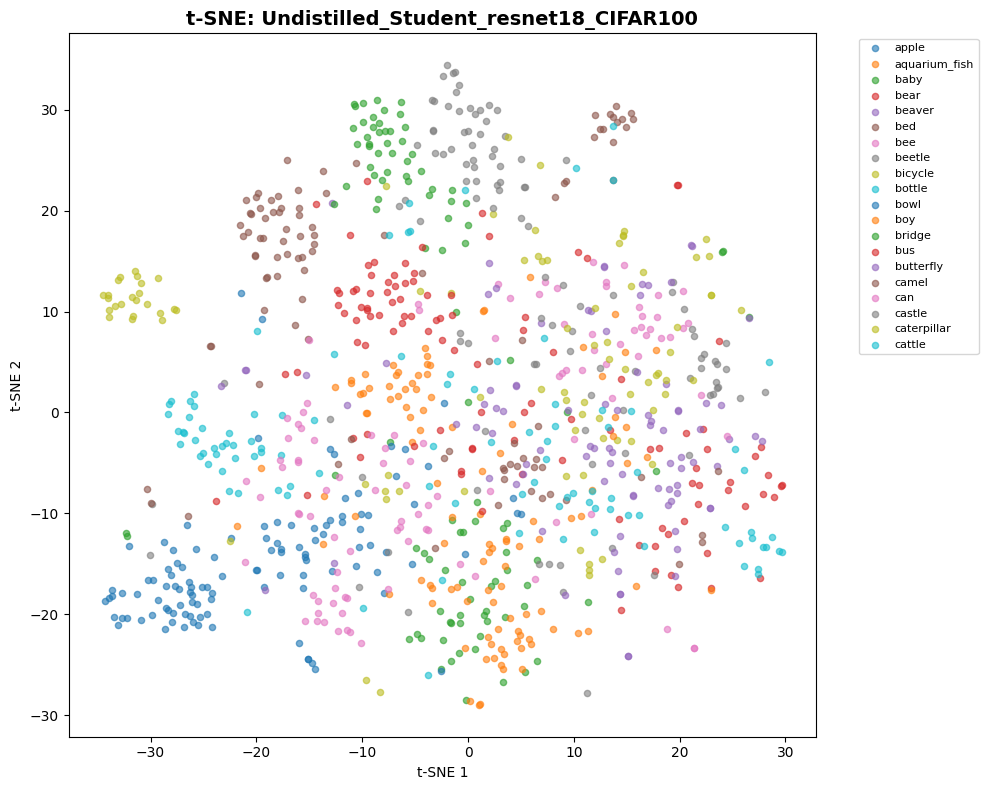

✓ Undistilled student visualization complete

📊 Hypersphere Distribution (Random Projections)...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 71.06it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 52.70% variance captured
PCA Stage 2 (10D → 3D): 43.21% of 10D captured
Total variance in 3D: 22.77% of original 64D
✓ Saved interactive plot to plots/undistilled_hypersphere.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.3315
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.1907
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 0.5751
  → Higher = better overall (clear clusters)

📊 Alignment & Uniformity Analysis (Random Projections)...
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 71.38it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 52.23it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: Undistilled Student (Random Projections)
Alignment Loss (↓ better):     0.6631
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -1.7332
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             0.8033
Alignment std:                 0.1334
Angle std:                     1.8403

✓ Saved comprehensive visualization to plots/undistilled_alignment_uniformity.png


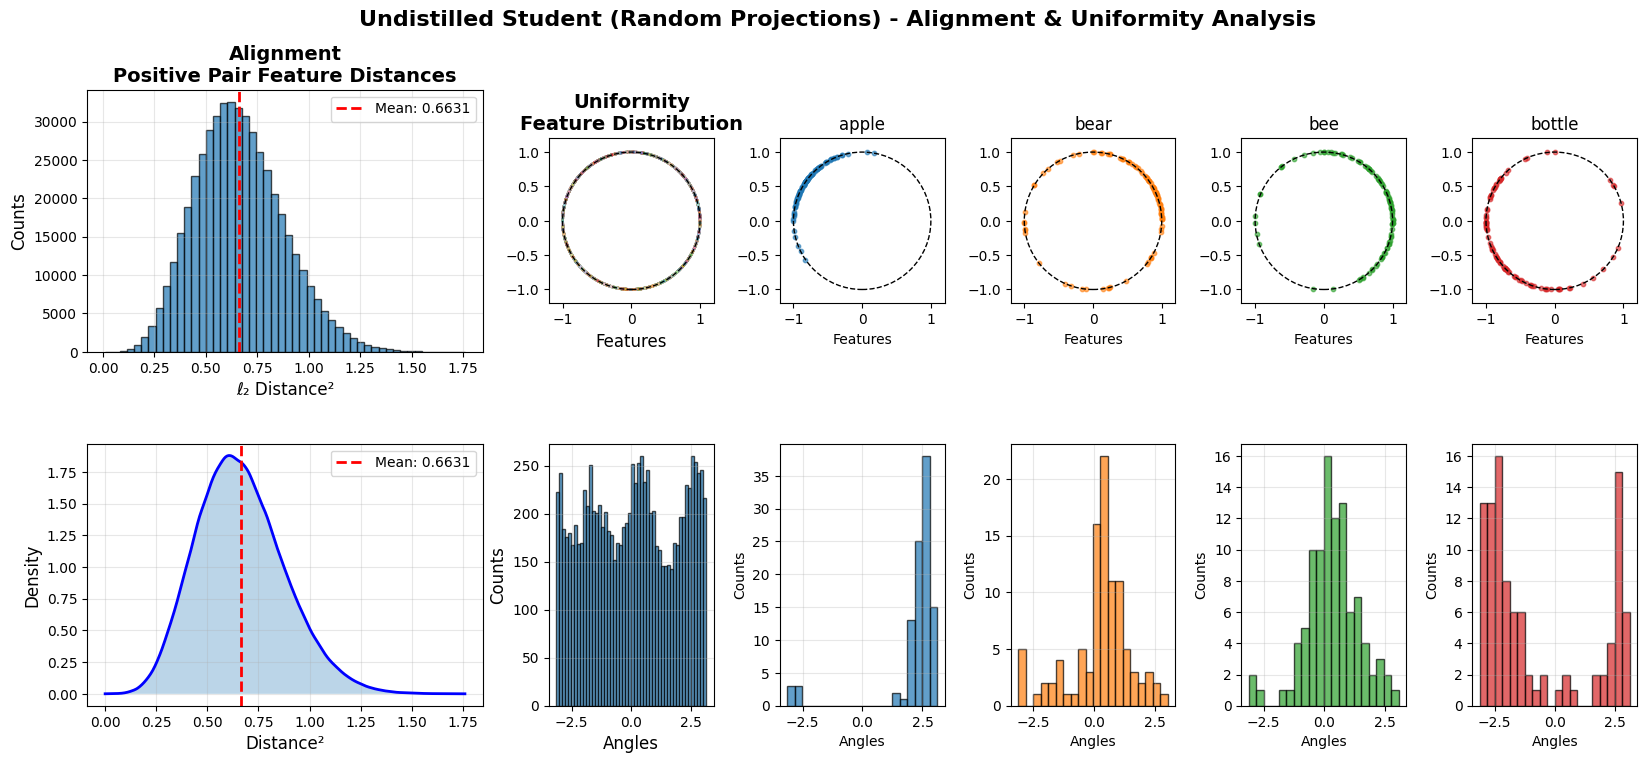


UNDISTILLED STUDENT QUALITY SUMMARY
Test Accuracy: 67.93%

Hypersphere metrics (from RANDOM projections):
  Intra-class distance: 0.3315
  Inter-class distance: 0.1907
  Separation ratio: 0.5751

Alignment & Uniformity (from RANDOM projections):
  Alignment loss: 0.6631
  Uniformity loss: -1.7332



In [11]:
print("\n" + "=" * 60)
print("EXPERIMENT 2a: UNDISTILLED STUDENT (Baseline)")
print("=" * 60)

FORCE_RETRAIN_UNDISTILLED = False
undistilled_model_path = f"pth_models/student_undistilled_{STUDENT_ARCH}_cifar100.pth"

if os.path.exists(undistilled_model_path) and not FORCE_RETRAIN_UNDISTILLED:
    print(f"Loading undistilled student from {undistilled_model_path}")
    
    student_undistilled = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)
    student_undistilled.load_state_dict(torch.load(undistilled_model_path, map_location=device))
    student_undistilled.eval()
    
    # Load training log if exists
    log_undistilled = load_training_log(f"student_undistilled_{STUDENT_ARCH}_cifar100")
    if log_undistilled:
        final_train_acc = log_undistilled["train_acc"][-1]
        print(f"  Final training accuracy: {final_train_acc:.2f}%")
    
else:
    print("Training undistilled student from scratch...")
    
    student_undistilled = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)
    optimizer_undistilled = torch.optim.Adam(student_undistilled.parameters(), lr=LR)
    criterion_undistilled = nn.CrossEntropyLoss()
    
    def train_undistilled(student, train_loader, optimizer, criterion, device, epochs=50):
        """Standard supervised training (no contrastive, no teacher)"""
        student.train()
        training_log = {"epochs": [], "train_loss": [], "train_acc": []}
        
        for epoch in range(epochs):
            total_loss = 0.0
            correct = 0
            total = 0
            
            for (view1, view2), labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
                images = view1.to(device)  # Use one view
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                _, _, logits = student(images)
                loss = criterion(logits, labels)
                
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
            
            acc = 100.0 * correct / total
            avg_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Acc: {acc:.1f}%")
            
            training_log["epochs"].append(epoch + 1)
            training_log["train_loss"].append(avg_loss)
            training_log["train_acc"].append(acc)
        
        save_training_log(training_log, f"student_undistilled_{STUDENT_ARCH}_cifar100")
        return student
    
    student_undistilled = train_undistilled(
        student_undistilled,
        train_loader,
        optimizer_undistilled,
        criterion_undistilled,
        device,
        epochs=EPOCHS_STUDENT,
    )
    
    # Save model
    torch.save(student_undistilled.state_dict(), undistilled_model_path)
    print(f"✓ Saved undistilled student to {undistilled_model_path}")

# Evaluate
acc_undistilled = evaluate_model(student_undistilled, test_loader, device)
print(f"\n{'='*50}")
print(f"Undistilled Student Test Accuracy: {acc_undistilled:.2f}%")
print(f"{'='*50}\n")

# ========== COMPREHENSIVE ANALYSIS ==========
print("\n" + "=" * 60)
print("UNDISTILLED STUDENT ANALYSIS")
print("=" * 60)
print("⚠️  Note: Projection head has RANDOM weights (never trained)")
print("   These visualizations show what happens WITHOUT contrastive learning")

# 1. Latent space (t-SNE)
print("\n📊 Visualizing undistilled student's projection space...")
visualize_latents(
    student_undistilled,
    test_loader,
    device,
    title=f"Undistilled_Student_{STUDENT_ARCH}_CIFAR100",
    sample_classes=sample_classes,
)
print("✓ Undistilled student visualization complete")

# 2. Hypersphere distribution (3D interactive)
print("\n📊 Hypersphere Distribution (Random Projections)...")
metrics_undistilled_hyper = visualize_hypersphere_distribution(
    student_undistilled,
    test_loader,
    device,
    title="Undistilled Student (Random Projections)",
    save_path="plots/undistilled_hypersphere.png",
)

# 3. Alignment & Uniformity (comprehensive)
print("\n📊 Alignment & Uniformity Analysis (Random Projections)...")
metrics_undistilled_align = visualize_alignment_uniformity(
    student_undistilled,
    test_loader,
    device,
    title="Undistilled Student (Random Projections)",
    save_path="plots/undistilled_alignment_uniformity.png",
)

# Summary
print("\n" + "=" * 60)
print("UNDISTILLED STUDENT QUALITY SUMMARY")
print("=" * 60)
print(f"Test Accuracy: {acc_undistilled:.2f}%")
print(f"\nHypersphere metrics (from RANDOM projections):")
print(f"  Intra-class distance: {metrics_undistilled_hyper['intra_class_dist']:.4f}")
print(f"  Inter-class distance: {metrics_undistilled_hyper['inter_class_dist']:.4f}")
print(f"  Separation ratio: {metrics_undistilled_hyper['separation_ratio']:.4f}")
print(f"\nAlignment & Uniformity (from RANDOM projections):")
print(f"  Alignment loss: {metrics_undistilled_align['alignment']:.4f}")
print(f"  Uniformity loss: {metrics_undistilled_align['uniformity']:.4f}")
print("=" * 60 + "\n")

---
## EXPERIMENT 2b: Baseline CRD (Instance Matching)




EXPERIMENT 2b: BASELINE CRD (Instance Matching)
Loading baseline CRD from pth_models/student_baseline_crd_resnet18_cifar100.pth
  Final training accuracy: 79.10%

Baseline CRD Test Accuracy: 68.05%


BASELINE CRD ANALYSIS

📊 Visualizing baseline CRD's latent space...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


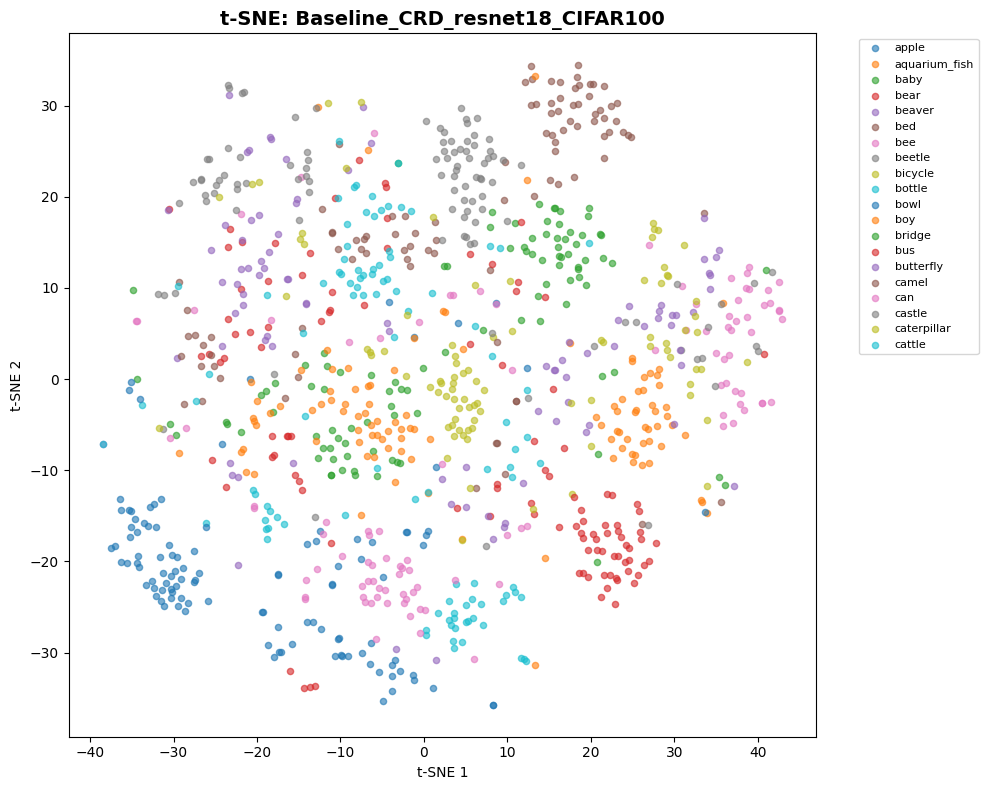

✓ Baseline CRD visualization complete

📊 Hypersphere Distribution...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 69.27it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 50.28% variance captured
PCA Stage 2 (10D → 3D): 40.55% of 10D captured
Total variance in 3D: 20.39% of original 64D
✓ Saved interactive plot to plots/baseline_crd_hypersphere.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.4504
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.2774
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 0.6159
  → Higher = better overall (clear clusters)

📊 Alignment & Uniformity Analysis...
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 68.42it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 51.89it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: Baseline CRD Student
Alignment Loss (↓ better):     0.9008
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -2.2358
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             0.9302
Alignment std:                 0.1886
Angle std:                     1.8115

✓ Saved comprehensive visualization to plots/baseline_crd_alignment_uniformity.png


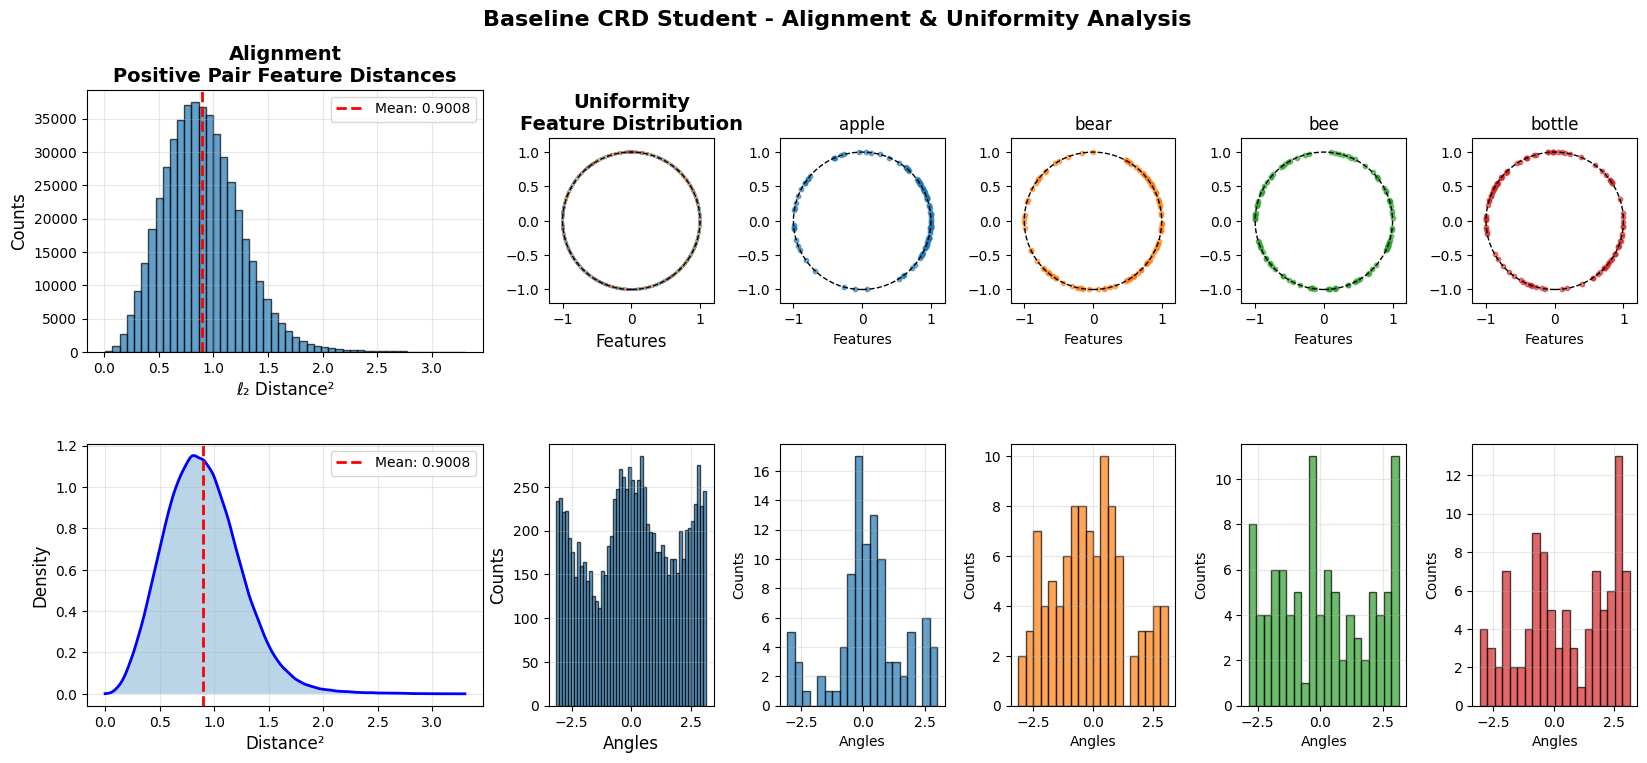


BASELINE CRD QUALITY SUMMARY
Test Accuracy: 68.05%

Hypersphere metrics:
  Intra-class distance: 0.4504
  Inter-class distance: 0.2774
  Separation ratio: 0.6159

Alignment & Uniformity:
  Alignment loss: 0.9008
  Uniformity loss: -2.2358



In [12]:
print("\n" + "=" * 60)
print("EXPERIMENT 2b: BASELINE CRD (Instance Matching)")
print("=" * 60)

FORCE_RETRAIN_BASELINE_CRD = False
baseline_crd_model_path = f"pth_models/student_baseline_crd_{STUDENT_ARCH}_cifar100.pth"

if os.path.exists(baseline_crd_model_path) and not FORCE_RETRAIN_BASELINE_CRD:
    print(f"Loading baseline CRD from {baseline_crd_model_path}")
    
    student_baseline_crd = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)
    student_baseline_crd.load_state_dict(torch.load(baseline_crd_model_path, map_location=device))
    student_baseline_crd.eval()
    
    # Load training log if exists
    log_baseline_crd = load_training_log(f"student_baseline_crd_{STUDENT_ARCH}_cifar100")
    if log_baseline_crd:
        final_train_acc = log_baseline_crd["train_acc"][-1]
        print(f"  Final training accuracy: {final_train_acc:.2f}%")
    
else:
    print("Training baseline CRD from scratch...")
    
    criterion_baseline_crd = BaseCRDLoss(temperature=TEMP)
    student_baseline_crd = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)
    optimizer_baseline_crd = torch.optim.Adam(student_baseline_crd.parameters(), lr=LR)
    
    student_baseline_crd, log_baseline_crd = train_student_joint(
        teacher,
        student_baseline_crd,
        train_loader,
        optimizer_baseline_crd,
        criterion_baseline_crd,
        device,
        epochs=EPOCHS_STUDENT,
        label="Baseline CRD",
        mode="baseline_crd",
        log_name=f"student_baseline_crd_{STUDENT_ARCH}_cifar100",
        joint_training=True,  # Enable joint training
    )
    
    # Save model
    torch.save(student_baseline_crd.state_dict(), baseline_crd_model_path)
    print(f"✓ Saved baseline CRD to {baseline_crd_model_path}")

# Evaluate
acc_baseline_crd = evaluate_model(student_baseline_crd, test_loader, device)
print(f"\n{'='*50}")
print(f"Baseline CRD Test Accuracy: {acc_baseline_crd:.2f}%")
print(f"{'='*50}\n")

# ========== COMPREHENSIVE ANALYSIS ==========
print("\n" + "=" * 60)
print("BASELINE CRD ANALYSIS")
print("=" * 60)

# 1. Latent space (t-SNE)
print("\n📊 Visualizing baseline CRD's latent space...")
visualize_latents(
    student_baseline_crd,
    test_loader,
    device,
    title=f"Baseline_CRD_{STUDENT_ARCH}_CIFAR100",
    sample_classes=sample_classes,
)
print("✓ Baseline CRD visualization complete")

# 2. Hypersphere distribution (3D interactive)
print("\n📊 Hypersphere Distribution...")
metrics_baseline_crd_hyper = visualize_hypersphere_distribution(
    student_baseline_crd,
    test_loader,
    device,
    title="Baseline CRD Student",
    save_path="plots/baseline_crd_hypersphere.png",
)

# 3. Alignment & Uniformity (comprehensive)
print("\n📊 Alignment & Uniformity Analysis...")
metrics_baseline_crd_align = visualize_alignment_uniformity(
    student_baseline_crd,
    test_loader,
    device,
    title="Baseline CRD Student",
    save_path="plots/baseline_crd_alignment_uniformity.png",
)

# Summary
print("\n" + "=" * 60)
print("BASELINE CRD QUALITY SUMMARY")
print("=" * 60)
print(f"Test Accuracy: {acc_baseline_crd:.2f}%")
print(f"\nHypersphere metrics:")
print(f"  Intra-class distance: {metrics_baseline_crd_hyper['intra_class_dist']:.4f}")
print(f"  Inter-class distance: {metrics_baseline_crd_hyper['inter_class_dist']:.4f}")
print(f"  Separation ratio: {metrics_baseline_crd_hyper['separation_ratio']:.4f}")
print(f"\nAlignment & Uniformity:")
print(f"  Alignment loss: {metrics_baseline_crd_align['alignment']:.4f}")
print(f"  Uniformity loss: {metrics_baseline_crd_align['uniformity']:.4f}")
print("=" * 60 + "\n")

---
## EXPERIMENT 2c: Baseline SupCon (No Teacher Guidance)




EXPERIMENT 2c: BASELINE SUPCON
Loading baseline SupCon from pth_models/student_baseline_supcon_resnet18_cifar100.pth

Baseline SupCon Test Accuracy: 69.08%

📊 Visualizing baseline SupCon's latent space...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


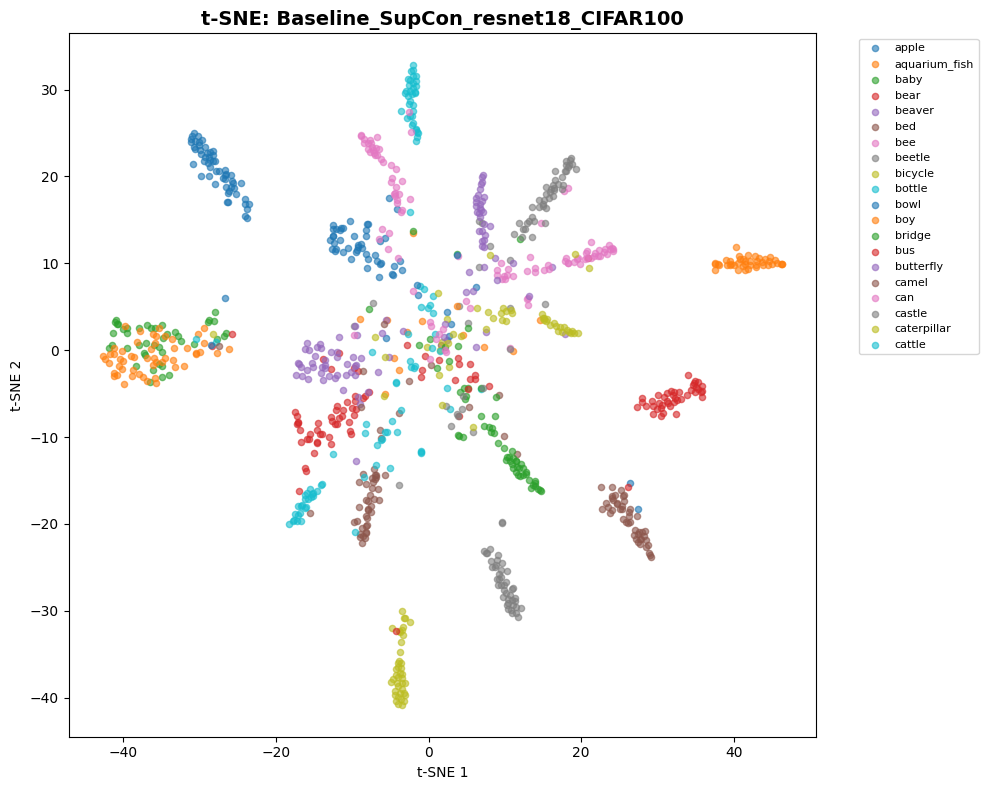

✓ Baseline SupCon visualization complete



In [13]:
print("\n" + "="*60)
print("EXPERIMENT 2c: BASELINE SUPCON")
print("="*60)

FORCE_RETRAIN_BASELINE = False
baseline_model_path = f"pth_models/student_baseline_supcon_{STUDENT_ARCH}_cifar100.pth"

if os.path.exists(baseline_model_path) and not FORCE_RETRAIN_BASELINE:
    print(f"Loading baseline SupCon from {baseline_model_path}")
    
    student_baseline = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)
    student_baseline.load_state_dict(torch.load(baseline_model_path, map_location=device))
    student_baseline.eval()
    
    # Load training log if exists
    log_baseline = load_training_log(f"student_baseline_supcon_{STUDENT_ARCH}_cifar100")
    if log_baseline:
        final_train_acc = log_baseline["train_acc"][-1]
        print(f"  Final training accuracy: {final_train_acc:.2f}%")
    
else:
    print("Training baseline SupCon from scratch...")
    
    criterion_supcon = SupConLoss(temperature=TEMP)
    student_baseline = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)
    optimizer_baseline = torch.optim.Adam(student_baseline.parameters(), lr=LR)
    
    student_baseline, log_baseline = train_student(
        teacher,
        student_baseline,
        train_loader,
        optimizer_baseline,
        criterion_supcon,
        device,
        epochs=EPOCHS_STUDENT,
        label="Baseline SupCon",
        mode="supcon",
        log_name=f"student_baseline_supcon_{STUDENT_ARCH}_cifar100",
        joint_training=False  # No teacher for SupCon
    )
    
    # Save model
    torch.save(student_baseline.state_dict(), baseline_model_path)
    print(f"✓ Saved baseline SupCon to {baseline_model_path}")

# Evaluate
acc_baseline = evaluate_model(student_baseline, test_loader, device)
print(f"\n{'='*50}")
print(f"Baseline SupCon Test Accuracy: {acc_baseline:.2f}%")
print(f"{'='*50}\n")

# Visualize learned representations
print("📊 Visualizing baseline SupCon's latent space...")
visualize_latents(
    student_baseline,
    test_loader,
    device,
    title=f"Baseline_SupCon_{STUDENT_ARCH}_CIFAR100",
    sample_classes=sample_classes,
)
print("✓ Baseline SupCon visualization complete\n")


BASELINE SUPCON ANALYSIS

📊 Hypersphere Distribution...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 67.87it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 56.24% variance captured
PCA Stage 2 (10D → 3D): 47.09% of 10D captured
Total variance in 3D: 26.48% of original 64D
✓ Saved interactive plot to plots/baseline_supcon_hypersphere.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.2189
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.6338
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 2.8959
  → Higher = better overall (clear clusters)

📊 Alignment & Uniformity Analysis...
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 69.50it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 51.80it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: Baseline SupCon Student
Alignment Loss (↓ better):     0.4377
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -2.5665
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             0.5794
Alignment std:                 0.3195
Angle std:                     1.9016

✓ Saved comprehensive visualization to plots/baseline_supcon_alignment_uniformity.png


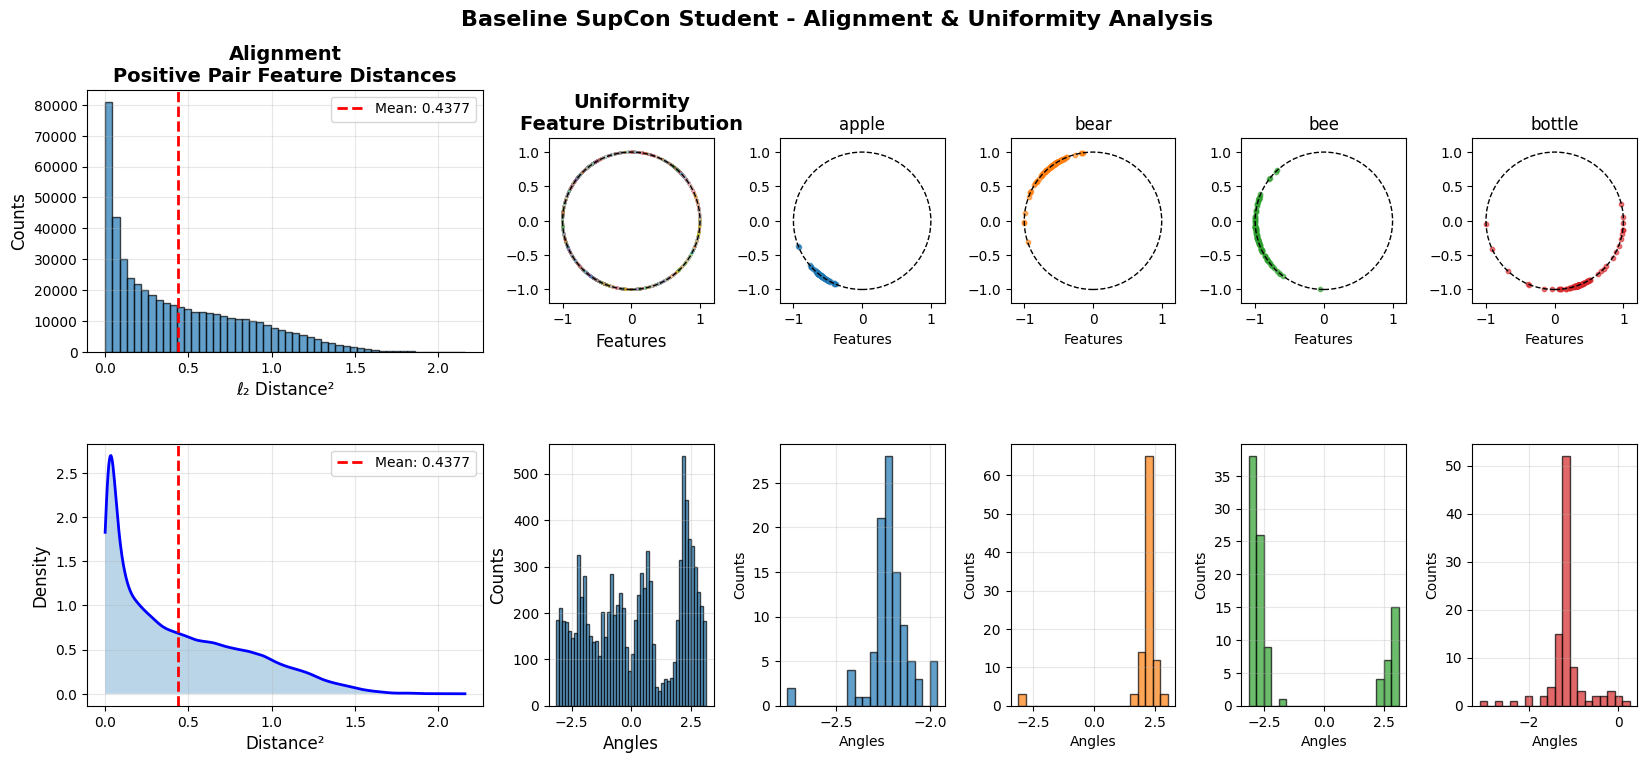


BASELINE SUPCON QUALITY SUMMARY
Test Accuracy: 69.08%

Hypersphere metrics:
  Intra-class distance: 0.2189
  Inter-class distance: 0.6338
  Separation ratio: 2.8959

Alignment & Uniformity:
  Alignment loss: 0.4377
  Uniformity loss: -2.5665



In [14]:
print("\n" + "=" * 60)
print("BASELINE SUPCON ANALYSIS")
print("=" * 60)

# Hypersphere distribution
print("\n📊 Hypersphere Distribution...")
metrics_baseline_hyper = visualize_hypersphere_distribution(
    student_baseline,
    test_loader,
    device,
    title="Baseline SupCon Student",
    save_path="plots/baseline_supcon_hypersphere.png",
)

# Alignment & Uniformity
print("\n📊 Alignment & Uniformity Analysis...")
metrics_baseline_align = visualize_alignment_uniformity(
    student_baseline,
    test_loader,
    device,
    title="Baseline SupCon Student",
    save_path="plots/baseline_supcon_alignment_uniformity.png",
)

print("\n" + "=" * 60)
print("BASELINE SUPCON QUALITY SUMMARY")
print("=" * 60)
print(f"Test Accuracy: {acc_baseline:.2f}%")
print(f"\nHypersphere metrics:")
print(f"  Intra-class distance: {metrics_baseline_hyper['intra_class_dist']:.4f}")
print(f"  Inter-class distance: {metrics_baseline_hyper['inter_class_dist']:.4f}")
print(f"  Separation ratio: {metrics_baseline_hyper['separation_ratio']:.4f}")
print(f"\nAlignment & Uniformity:")
print(f"  Alignment loss: {metrics_baseline_align['alignment']:.4f}")
print(f"  Uniformity loss: {metrics_baseline_align['uniformity']:.4f}")
print("=" * 60 + "\n")

---
## EXPERIMENT 3: α Sweep (WITH GRADIENT FIX)




EXPERIMENT 3: α SWEEP (with gradient normalization fix)

Testing α = 1.0, β = 10.0
Loading alpha_1.0_beta_10.0_adaptive from pth_models/student_alpha_1.0_beta_10.0_adaptive_resnet18_cifar100.pth
  Train Acc (final): 90.51%

α=1.0: Train=90.51%, Test=73.19%

📊 Visualizing α=1.0...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


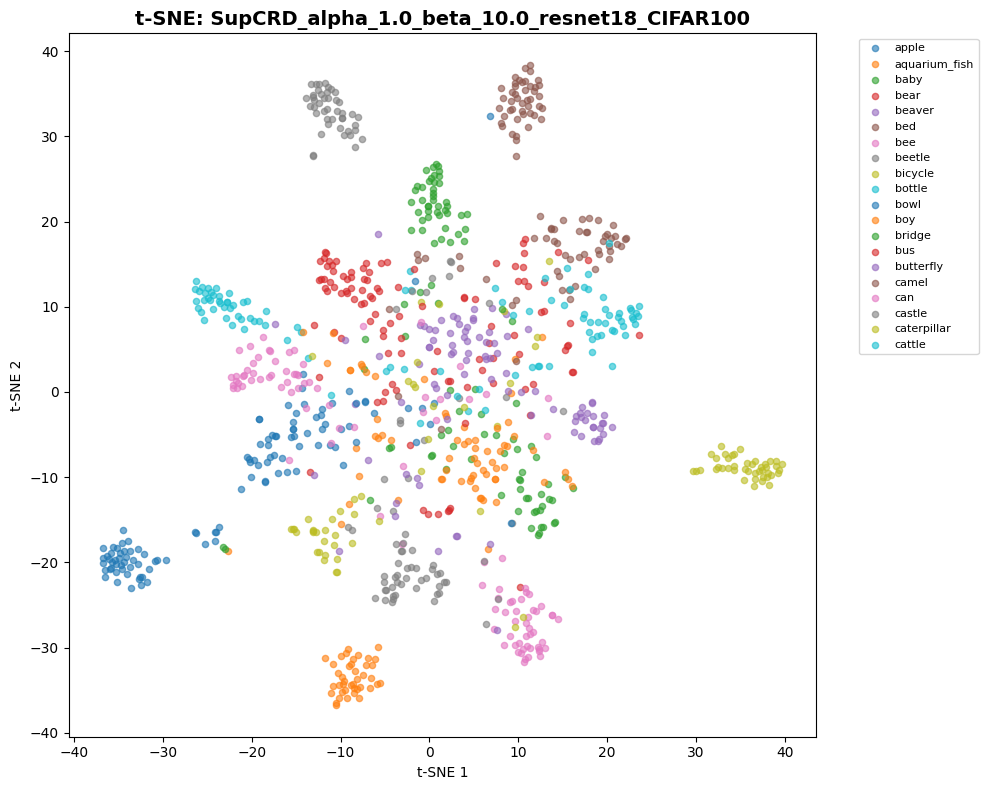

✓ α=1.0 visualization complete

📊 Quality Analysis for α=1.0...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 69.86it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 35.54% variance captured
PCA Stage 2 (10D → 3D): 33.07% of 10D captured
Total variance in 3D: 11.75% of original 64D
✓ Saved interactive plot to plots/alpha_1.0_hypersphere.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.5759
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9939
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 1.7259
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 69.83it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 52.54it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: LW-SupCRD α=1.0 β=10.0
Alignment Loss (↓ better):     1.1518
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -3.7027
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             1.0272
Alignment std:                 0.3108
Angle std:                     1.8142

✓ Saved comprehensive visualization to plots/alpha_1.0_alignment.png


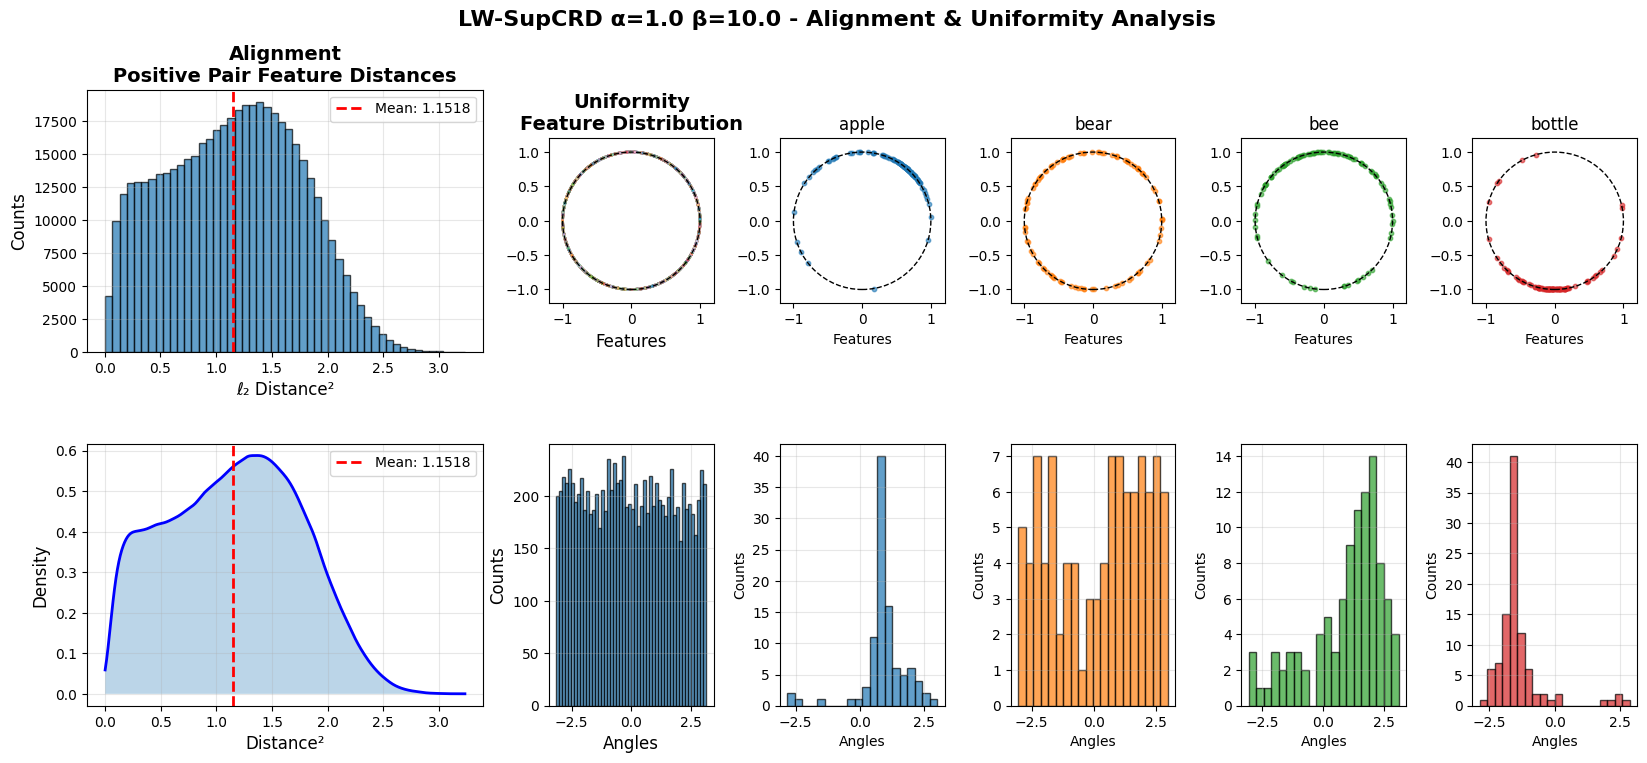


α=1.0 QUALITY SUMMARY
Test Accuracy: 73.19%

Hypersphere metrics:
  Intra-class: 0.5759
  Inter-class: 0.9939
  Separation ratio: 1.7259

Alignment & Uniformity:
  Alignment: 1.1518
  Uniformity: -3.7027


Testing α = 2.0, β = 10.0
Loading alpha_2.0_beta_10.0_adaptive from pth_models/student_alpha_2.0_beta_10.0_adaptive_resnet18_cifar100.pth
  Train Acc (final): 92.02%

α=2.0: Train=92.02%, Test=71.78%

📊 Visualizing α=2.0...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


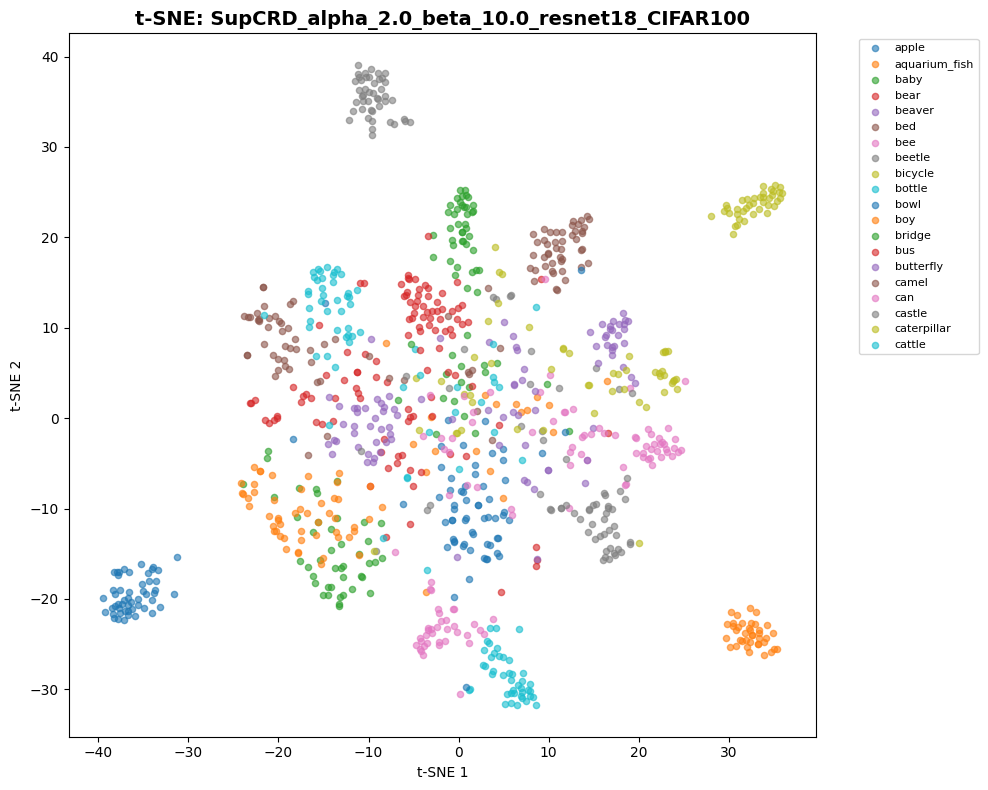

✓ α=2.0 visualization complete

📊 Quality Analysis for α=2.0...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 69.17it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 37.80% variance captured
PCA Stage 2 (10D → 3D): 33.21% of 10D captured
Total variance in 3D: 12.55% of original 64D
✓ Saved interactive plot to plots/alpha_2.0_hypersphere.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.5564
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9825
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 1.7657
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 70.87it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 51.49it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: LW-SupCRD α=2.0 β=10.0
Alignment Loss (↓ better):     1.1129
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -3.6744
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             1.0087
Alignment std:                 0.3089
Angle std:                     1.8179

✓ Saved comprehensive visualization to plots/alpha_2.0_alignment.png


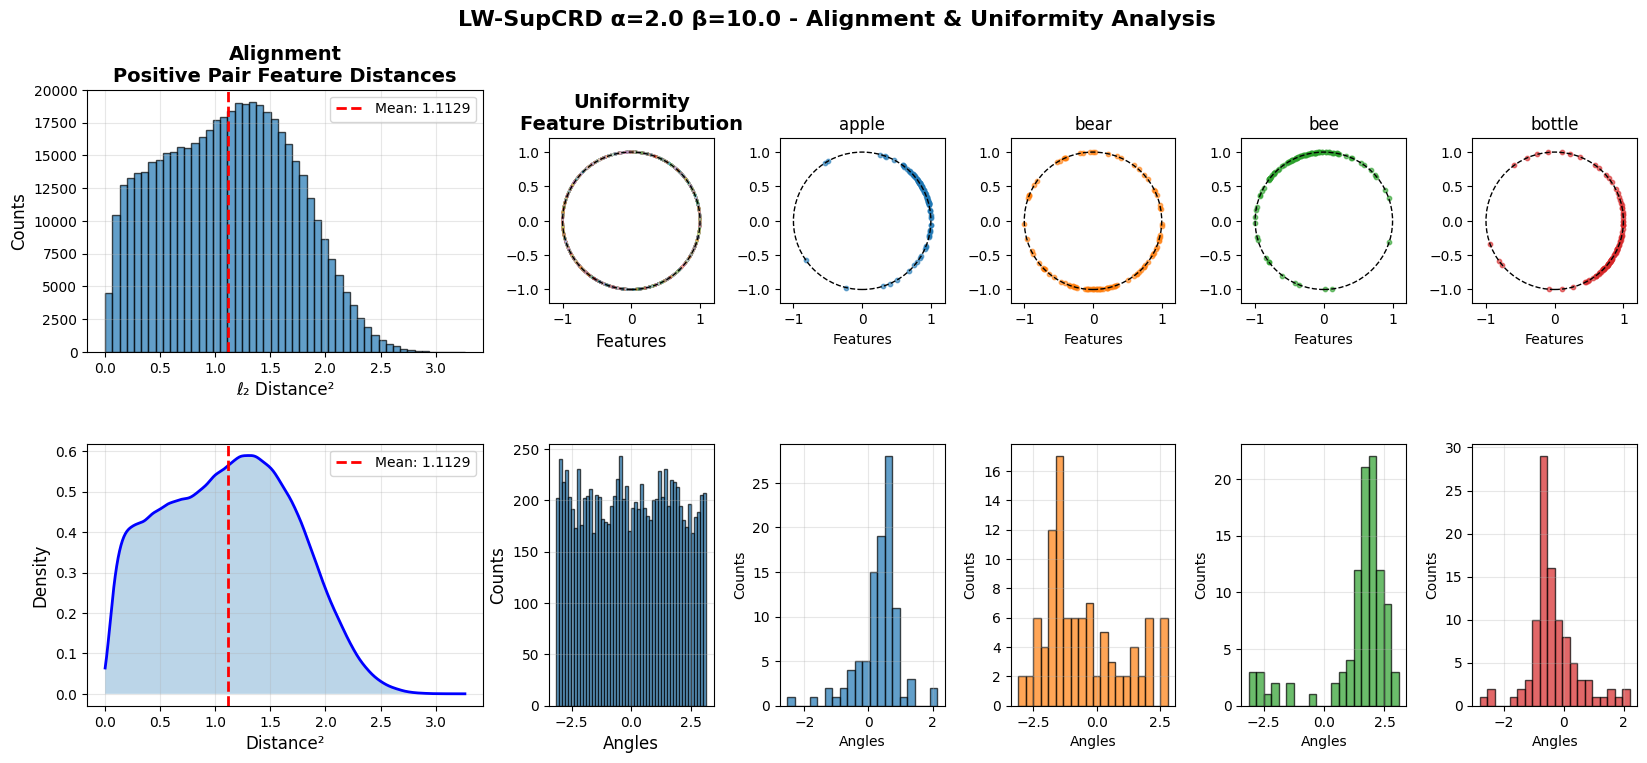


α=2.0 QUALITY SUMMARY
Test Accuracy: 71.78%

Hypersphere metrics:
  Intra-class: 0.5564
  Inter-class: 0.9825
  Separation ratio: 1.7657

Alignment & Uniformity:
  Alignment: 1.1129
  Uniformity: -3.6744


Testing α = 5.0, β = 10.0
Loading alpha_5.0_beta_10.0_adaptive from pth_models/student_alpha_5.0_beta_10.0_adaptive_resnet18_cifar100.pth
  Train Acc (final): 88.01%

α=5.0: Train=88.01%, Test=70.67%

📊 Visualizing α=5.0...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


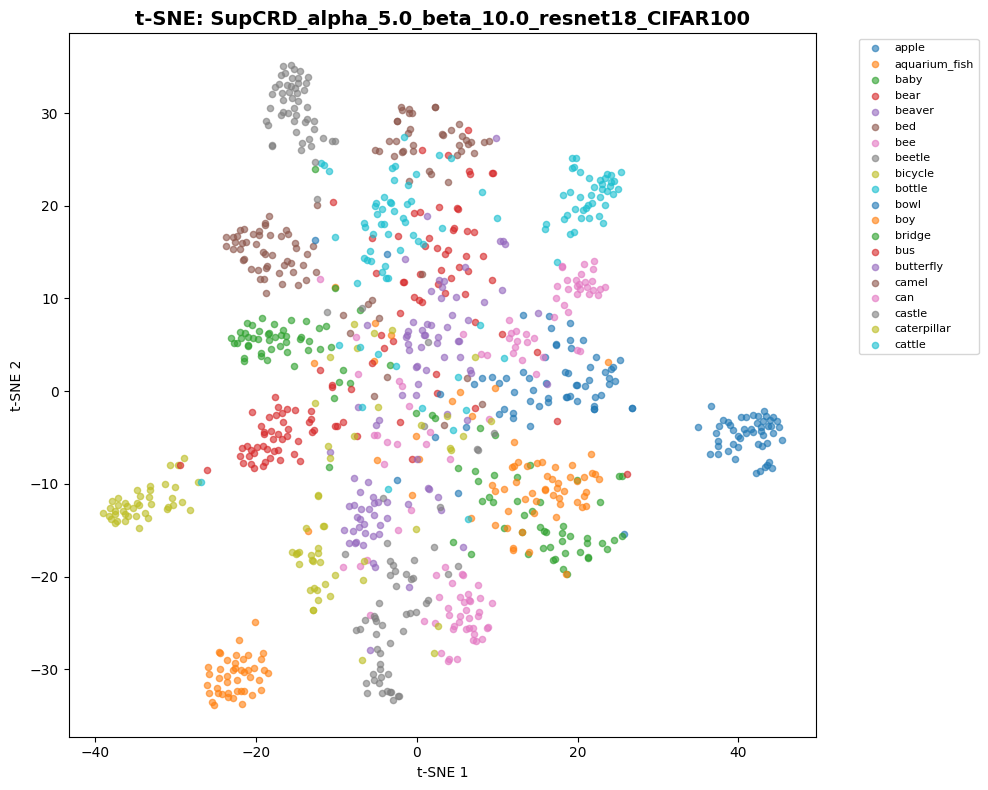

✓ α=5.0 visualization complete

📊 Quality Analysis for α=5.0...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 68.73it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 41.68% variance captured
PCA Stage 2 (10D → 3D): 32.94% of 10D captured
Total variance in 3D: 13.73% of original 64D
✓ Saved interactive plot to plots/alpha_5.0_hypersphere.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.5794
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9899
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 1.7085
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 71.22it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 51.75it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: LW-SupCRD α=5.0 β=10.0
Alignment Loss (↓ better):     1.1589
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -3.6712
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             1.0382
Alignment std:                 0.2845
Angle std:                     1.8140

✓ Saved comprehensive visualization to plots/alpha_5.0_alignment.png


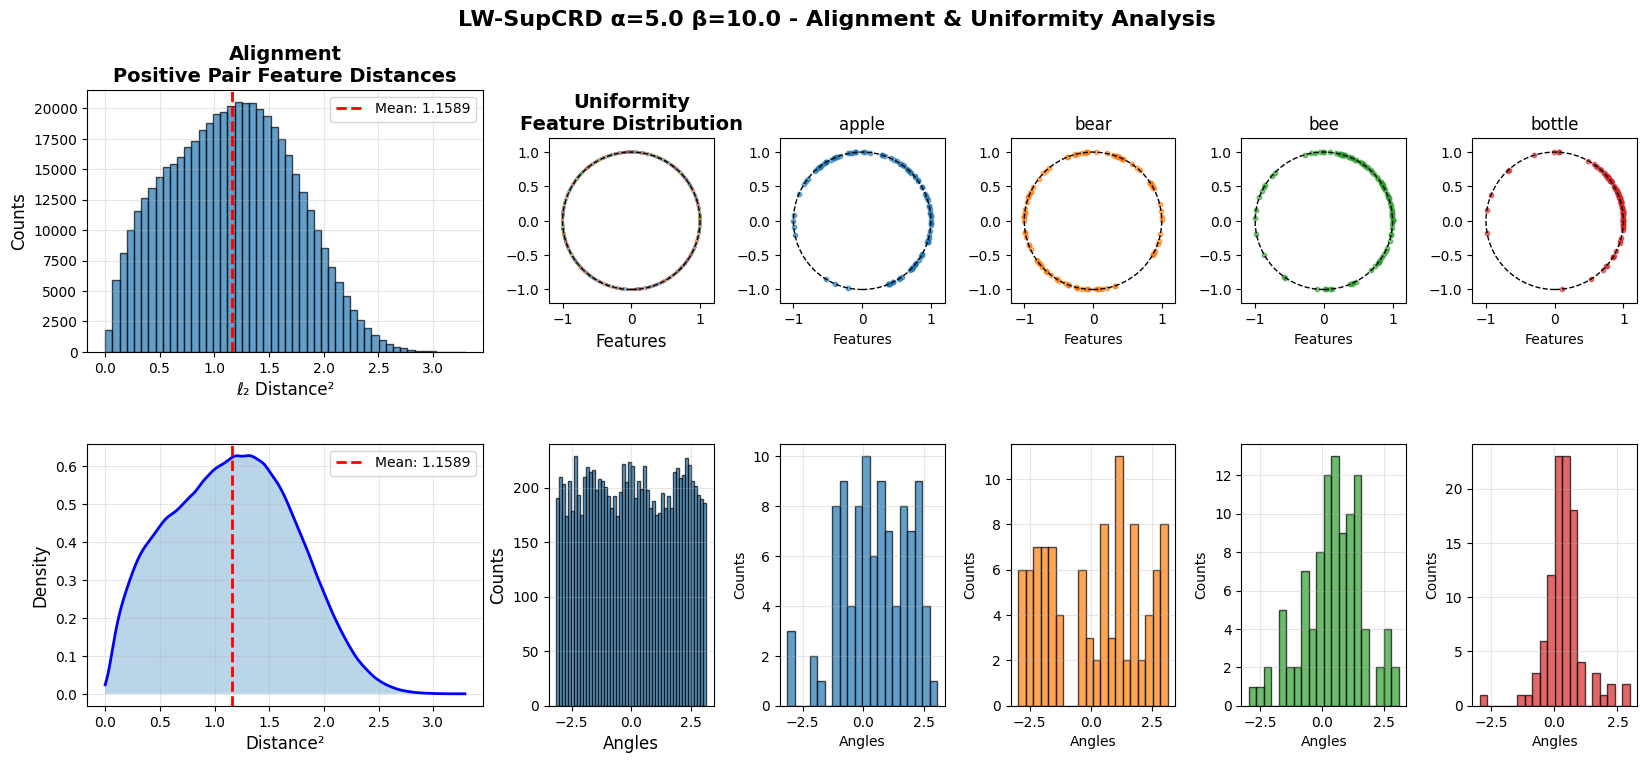


α=5.0 QUALITY SUMMARY
Test Accuracy: 70.67%

Hypersphere metrics:
  Intra-class: 0.5794
  Inter-class: 0.9899
  Separation ratio: 1.7085

Alignment & Uniformity:
  Alignment: 1.1589
  Uniformity: -3.6712


Testing α = 10.0, β = 10.0
Loading alpha_10.0_beta_10.0_adaptive from pth_models/student_alpha_10.0_beta_10.0_adaptive_resnet18_cifar100.pth
  Train Acc (final): 83.04%

α=10.0: Train=83.04%, Test=70.07%

📊 Visualizing α=10.0...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


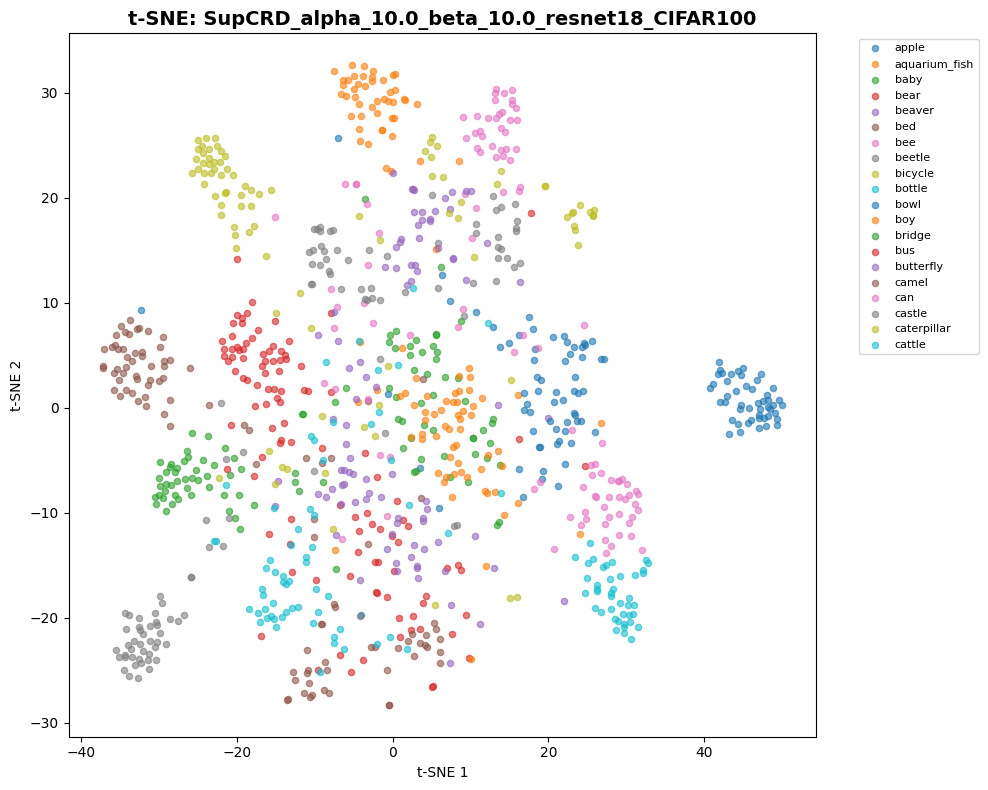

✓ α=10.0 visualization complete

📊 Quality Analysis for α=10.0...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 69.09it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 40.65% variance captured
PCA Stage 2 (10D → 3D): 33.43% of 10D captured
Total variance in 3D: 13.59% of original 64D
✓ Saved interactive plot to plots/alpha_10.0_hypersphere.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.6377
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9808
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 1.5379
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 70.56it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 51.68it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: LW-SupCRD α=10.0 β=10.0
Alignment Loss (↓ better):     1.2754
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -3.6728
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             1.0992
Alignment std:                 0.2593
Angle std:                     1.8081

✓ Saved comprehensive visualization to plots/alpha_10.0_alignment.png


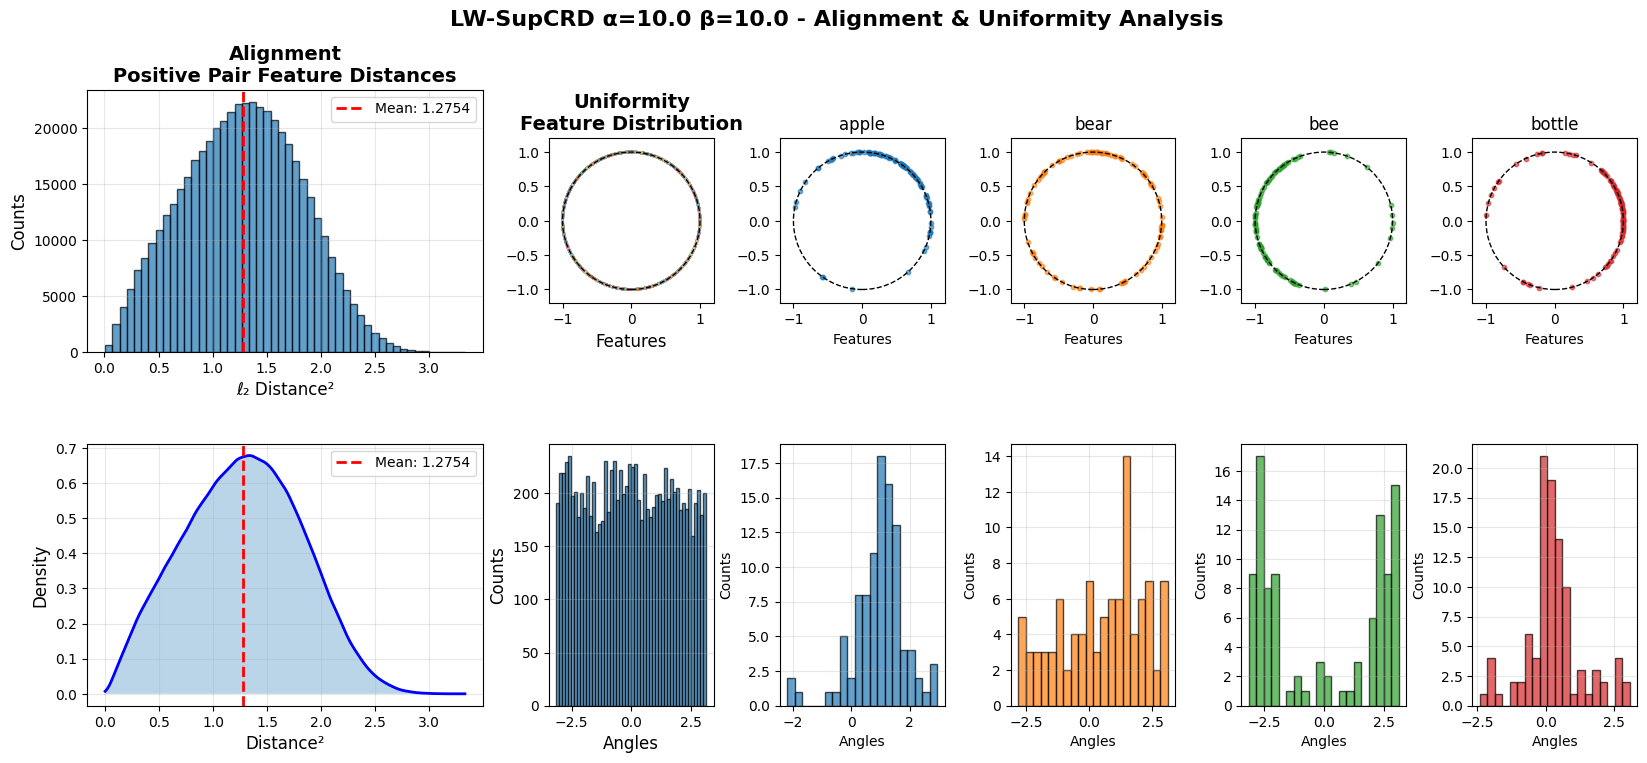


α=10.0 QUALITY SUMMARY
Test Accuracy: 70.07%

Hypersphere metrics:
  Intra-class: 0.6377
  Inter-class: 0.9808
  Separation ratio: 1.5379

Alignment & Uniformity:
  Alignment: 1.2754
  Uniformity: -3.6728


α SWEEP SUMMARY (β=10.0, τ=0.07)
α=  1.0: Test=73.19% (Δ=+4.11%)
α=  2.0: Test=71.78% (Δ=+2.70%)
α=  5.0: Test=70.67% (Δ=+1.59%)
α= 10.0: Test=70.07% (Δ=+0.99%)

🏆 Best α: 1.0 with 73.19% accuracy



In [15]:
print("\n" + "="*60)
print("EXPERIMENT 3: α SWEEP (with gradient normalization fix)")
print("="*60)

FORCE_RETRAIN_ALPHA_SWEEP = False
results_alpha = {}

for alpha_val in ALPHA_SWEEP:
    print(f"\n{'='*50}")
    print(f"Testing α = {alpha_val}, β = {BETA}")
    print(f"{'='*50}")
    
    # Define paths
    exp_name = f"alpha_{alpha_val}_beta_{BETA}_adaptive"
    model_path = f"pth_models/student_{exp_name}_{STUDENT_ARCH}_cifar100.pth"
    log_name = f"student_{exp_name}_{STUDENT_ARCH}_cifar100"
    
    # Check if model exists
    if os.path.exists(model_path) and not FORCE_RETRAIN_ALPHA_SWEEP:
        print(f"Loading {exp_name} from {model_path}")
        
        student_alpha = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)
        student_alpha.load_state_dict(torch.load(model_path, map_location=device))
        student_alpha.eval()
        
        # Load training log
        log_alpha = load_training_log(log_name)
        if log_alpha:
            train_acc = log_alpha["train_acc"][-1]
            print(f"  Train Acc (final): {train_acc:.2f}%")
    
    else:
        print(f"Training {exp_name} from scratch...")
        
        criterion_alpha = LogitWeightedSupCRDLoss(
            alpha=alpha_val,
            beta=BETA,
            temperature=TEMP,
            adaptive_beta=True
        )
        
        student_alpha = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)
        optimizer_alpha = torch.optim.Adam(student_alpha.parameters(), lr=LR)
        
        student_alpha, log_alpha = train_student_joint(
            teacher,
            student_alpha,
            train_loader,
            optimizer_alpha,
            criterion_alpha,
            device,
            epochs=EPOCHS_STUDENT,
            label=f"LW-SupCRD α={alpha_val}",
            mode="supcrd",
            log_name=log_name,
            joint_training=True  # Enable joint training
        )
        
        # Save model
        torch.save(student_alpha.state_dict(), model_path)
        print(f"✓ Saved model to {model_path}")
    
    # Evaluate
    acc_alpha = evaluate_model(student_alpha, test_loader, device)
    results_alpha[alpha_val] = acc_alpha
    
    print(f"\nα={alpha_val}: Train={log_alpha['train_acc'][-1]:.2f}%, Test={acc_alpha:.2f}%")
    
    # ========== VISUALIZATIONS ==========
    
    # 1. Latent space (t-SNE)
    print(f"\n📊 Visualizing α={alpha_val}...")
    visualize_latents(
        student_alpha,
        test_loader,
        device,
        title=f"SupCRD_alpha_{alpha_val}_beta_{BETA}_{STUDENT_ARCH}_CIFAR100",
        sample_classes=sample_classes
    )
    print(f"✓ α={alpha_val} visualization complete")
    
    # 2. Hypersphere distribution (3D interactive)
    print(f"\n📊 Quality Analysis for α={alpha_val}...")
    metrics_alpha_hyper = visualize_hypersphere_distribution(
        student_alpha,
        test_loader,
        device,
        title=f"LW-SupCRD α={alpha_val} β={BETA}",
        save_path=f"plots/alpha_{alpha_val}_hypersphere.png"
    )
    
    # 3. Alignment & Uniformity (comprehensive)
    metrics_alpha_align = visualize_alignment_uniformity(
        student_alpha,
        test_loader,
        device,
        title=f"LW-SupCRD α={alpha_val} β={BETA}",
        save_path=f"plots/alpha_{alpha_val}_alignment.png"
    )
    
    # Print summary for this α
    print(f"\n{'='*50}")
    print(f"α={alpha_val} QUALITY SUMMARY")
    print(f"{'='*50}")
    print(f"Test Accuracy: {acc_alpha:.2f}%")
    print(f"\nHypersphere metrics:")
    print(f"  Intra-class: {metrics_alpha_hyper['intra_class_dist']:.4f}")
    print(f"  Inter-class: {metrics_alpha_hyper['inter_class_dist']:.4f}")
    print(f"  Separation ratio: {metrics_alpha_hyper['separation_ratio']:.4f}")
    print(f"\nAlignment & Uniformity:")
    print(f"  Alignment: {metrics_alpha_align['alignment']:.4f}")
    print(f"  Uniformity: {metrics_alpha_align['uniformity']:.4f}")
    print(f"{'='*50}\n")

# ========== FINAL SUMMARY ==========
print("\n" + "="*60)
print(f"α SWEEP SUMMARY (β={BETA}, τ={TEMP})")
print("="*60)
for alpha_val, acc in results_alpha.items():
    delta = acc - acc_baseline  # Compare to SupCon baseline
    print(f"α={alpha_val:5.1f}: Test={acc:5.2f}% (Δ={delta:+.2f}%)")
print("="*60 + "\n")

# Find best α
best_alpha = max(results_alpha.items(), key=lambda x: x[1])
print(f"🏆 Best α: {best_alpha[0]} with {best_alpha[1]:.2f}% accuracy\n")

---
## EXPERIMENT 4: β Sweep (WITH ADAPTIVE β)




EXPERIMENT 4: β SWEEP (with adaptive β)

Testing α = 1.0, β = 1.0 (ADAPTIVE)
Loading alpha_1.0_beta_1.0_adaptive from pth_models/student_alpha_1.0_beta_1.0_adaptive_resnet18_cifar100.pth
  Train Acc (final): 85.39%

β=1.0 (adaptive): Train=85.39%, Test=70.46%

📊 Visualizing β=1.0 (adaptive)...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


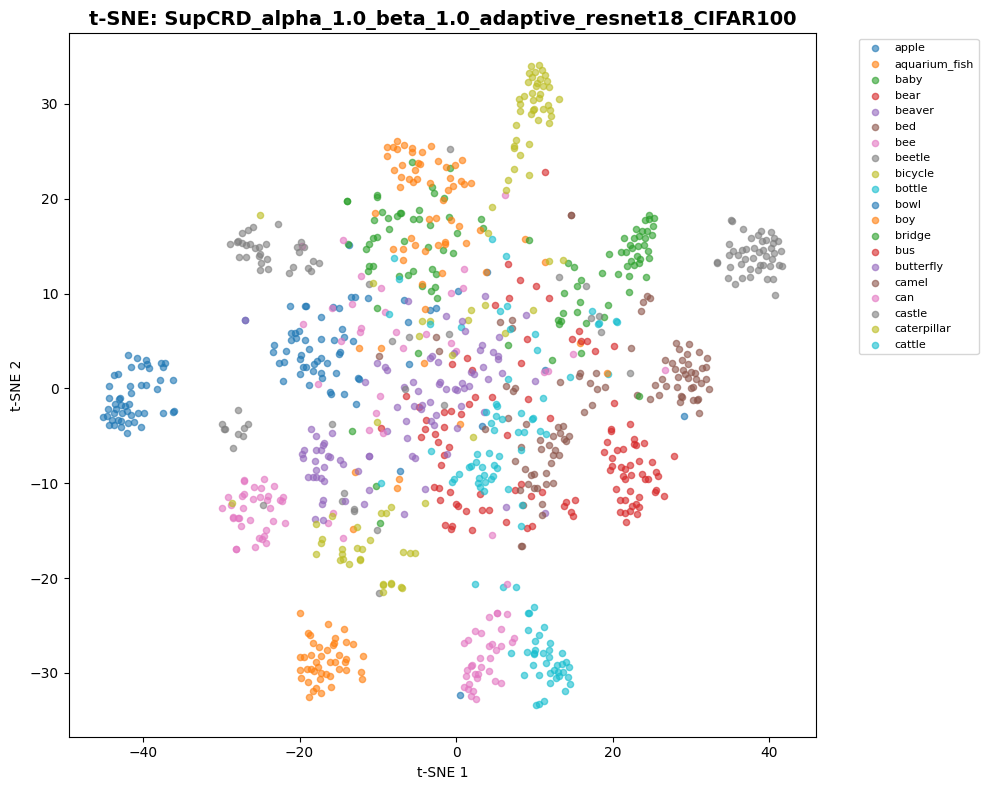

✓ β=1.0 visualization complete

📊 Quality Analysis for β=1.0...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 69.67it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 43.62% variance captured
PCA Stage 2 (10D → 3D): 34.00% of 10D captured
Total variance in 3D: 14.83% of original 64D
✓ Saved interactive plot to plots/beta_1.0_adaptive_hypersphere.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.5931
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9745
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 1.6431
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 72.23it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 51.92it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: LW-SupCRD α=1.0 β=1.0 (adaptive)
Alignment Loss (↓ better):     1.1862
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -3.6390
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             1.0546
Alignment std:                 0.2720
Angle std:                     1.8267

✓ Saved comprehensive visualization to plots/beta_1.0_adaptive_alignment.png


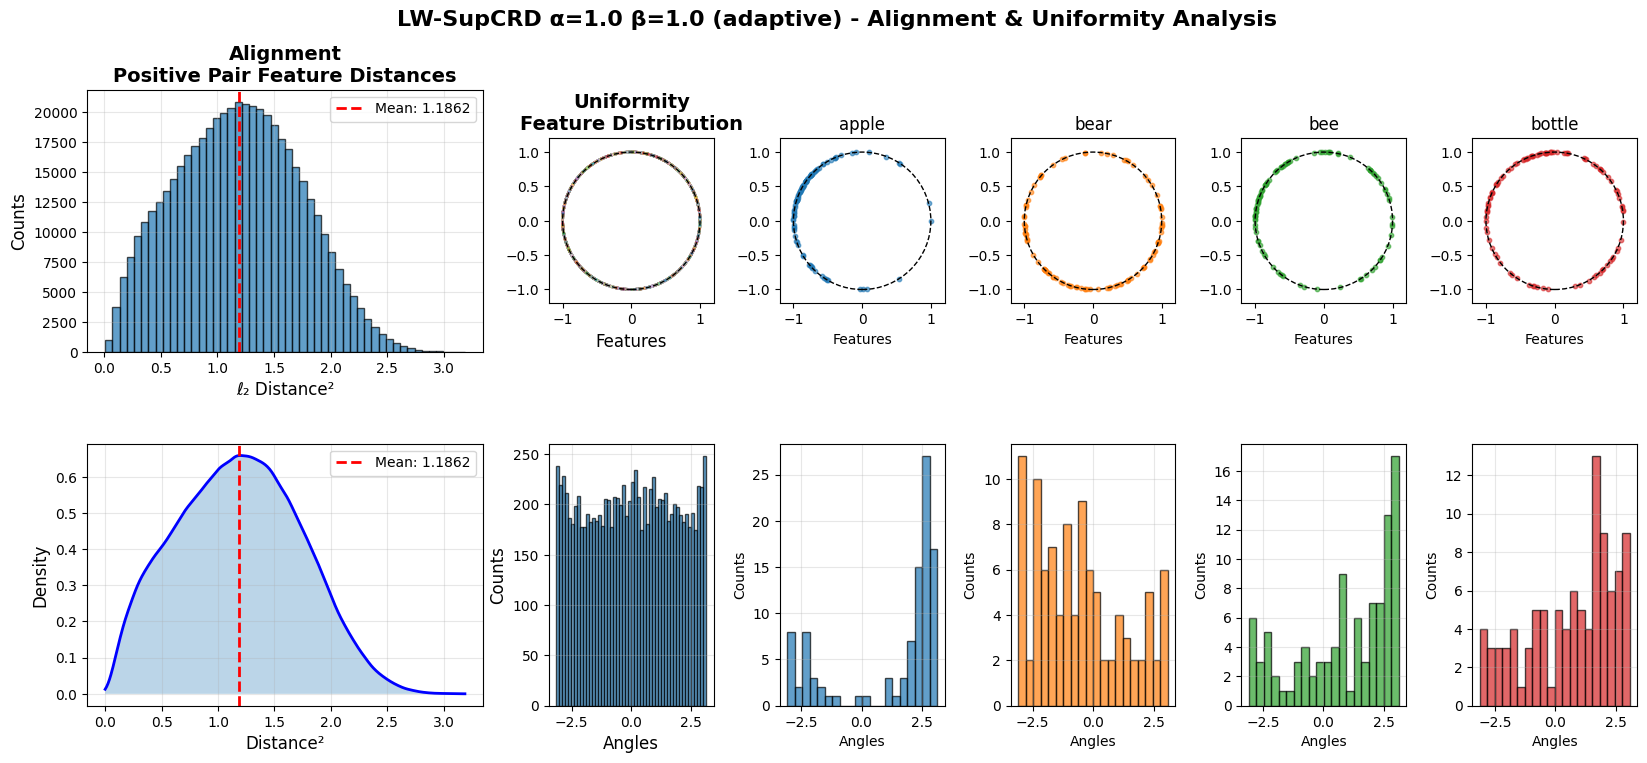


β=1.0 (adaptive) QUALITY SUMMARY
Test Accuracy: 70.46%

Hypersphere metrics:
  Intra-class: 0.5931
  Inter-class: 0.9745
  Separation ratio: 1.6431

Alignment & Uniformity:
  Alignment: 1.1862
  Uniformity: -3.6390


Testing α = 1.0, β = 5.0 (ADAPTIVE)
Loading alpha_1.0_beta_5.0_adaptive from pth_models/student_alpha_1.0_beta_5.0_adaptive_resnet18_cifar100.pth
  Train Acc (final): 86.61%

β=5.0 (adaptive): Train=86.61%, Test=70.63%

📊 Visualizing β=5.0 (adaptive)...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


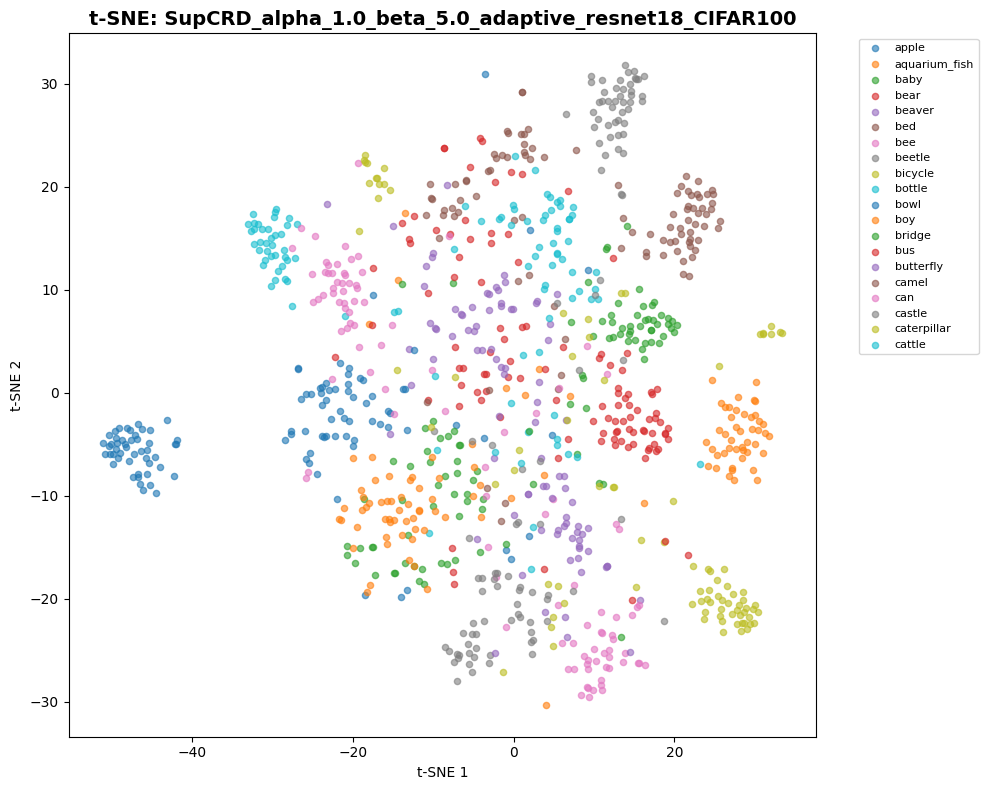

✓ β=5.0 visualization complete

📊 Quality Analysis for β=5.0...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 71.58it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 38.16% variance captured
PCA Stage 2 (10D → 3D): 34.07% of 10D captured
Total variance in 3D: 13.00% of original 64D
✓ Saved interactive plot to plots/beta_5.0_adaptive_hypersphere.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.6243
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9714
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 1.5559
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 69.88it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 52.39it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: LW-SupCRD α=1.0 β=5.0 (adaptive)
Alignment Loss (↓ better):     1.2487
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -3.6785
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             1.0844
Alignment std:                 0.2697
Angle std:                     1.8084

✓ Saved comprehensive visualization to plots/beta_5.0_adaptive_alignment.png


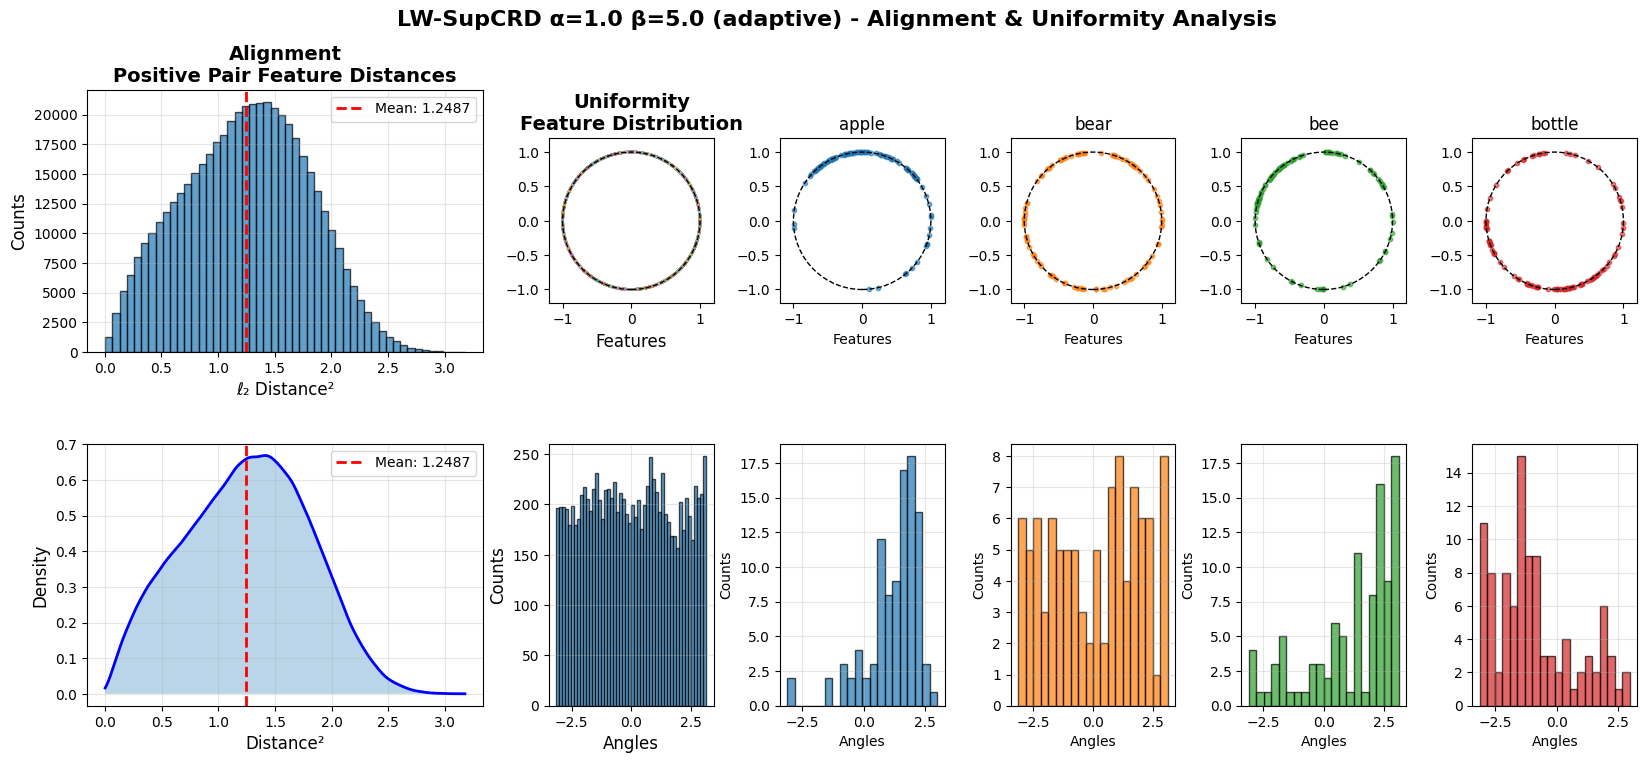


β=5.0 (adaptive) QUALITY SUMMARY
Test Accuracy: 70.63%

Hypersphere metrics:
  Intra-class: 0.6243
  Inter-class: 0.9714
  Separation ratio: 1.5559

Alignment & Uniformity:
  Alignment: 1.2487
  Uniformity: -3.6785


Testing α = 1.0, β = 10.0 (ADAPTIVE)
Loading alpha_1.0_beta_10.0_adaptive from pth_models/student_alpha_1.0_beta_10.0_adaptive_resnet18_cifar100.pth
  Train Acc (final): 90.51%

β=10.0 (adaptive): Train=90.51%, Test=73.19%

📊 Visualizing β=10.0 (adaptive)...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


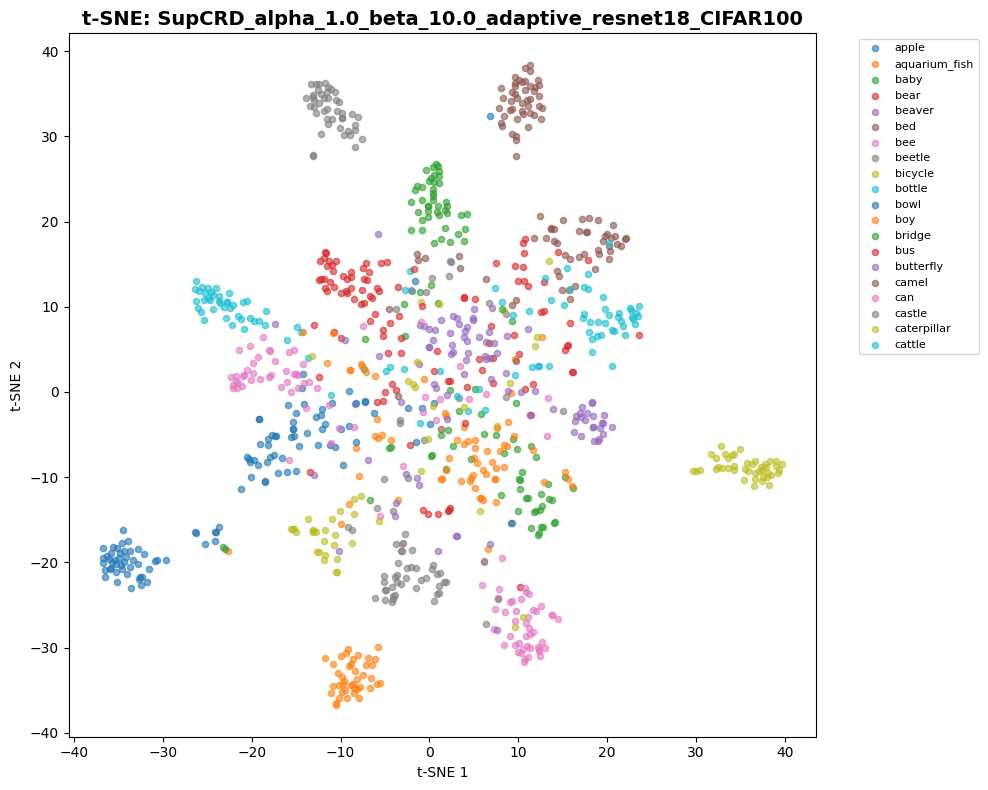

✓ β=10.0 visualization complete

📊 Quality Analysis for β=10.0...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 69.53it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 35.54% variance captured
PCA Stage 2 (10D → 3D): 33.07% of 10D captured
Total variance in 3D: 11.75% of original 64D
✓ Saved interactive plot to plots/beta_10.0_adaptive_hypersphere.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.5759
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9939
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 1.7259
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 71.96it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 51.50it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: LW-SupCRD α=1.0 β=10.0 (adaptive)
Alignment Loss (↓ better):     1.1518
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -3.7030
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             1.0272
Alignment std:                 0.3108
Angle std:                     1.8142

✓ Saved comprehensive visualization to plots/beta_10.0_adaptive_alignment.png


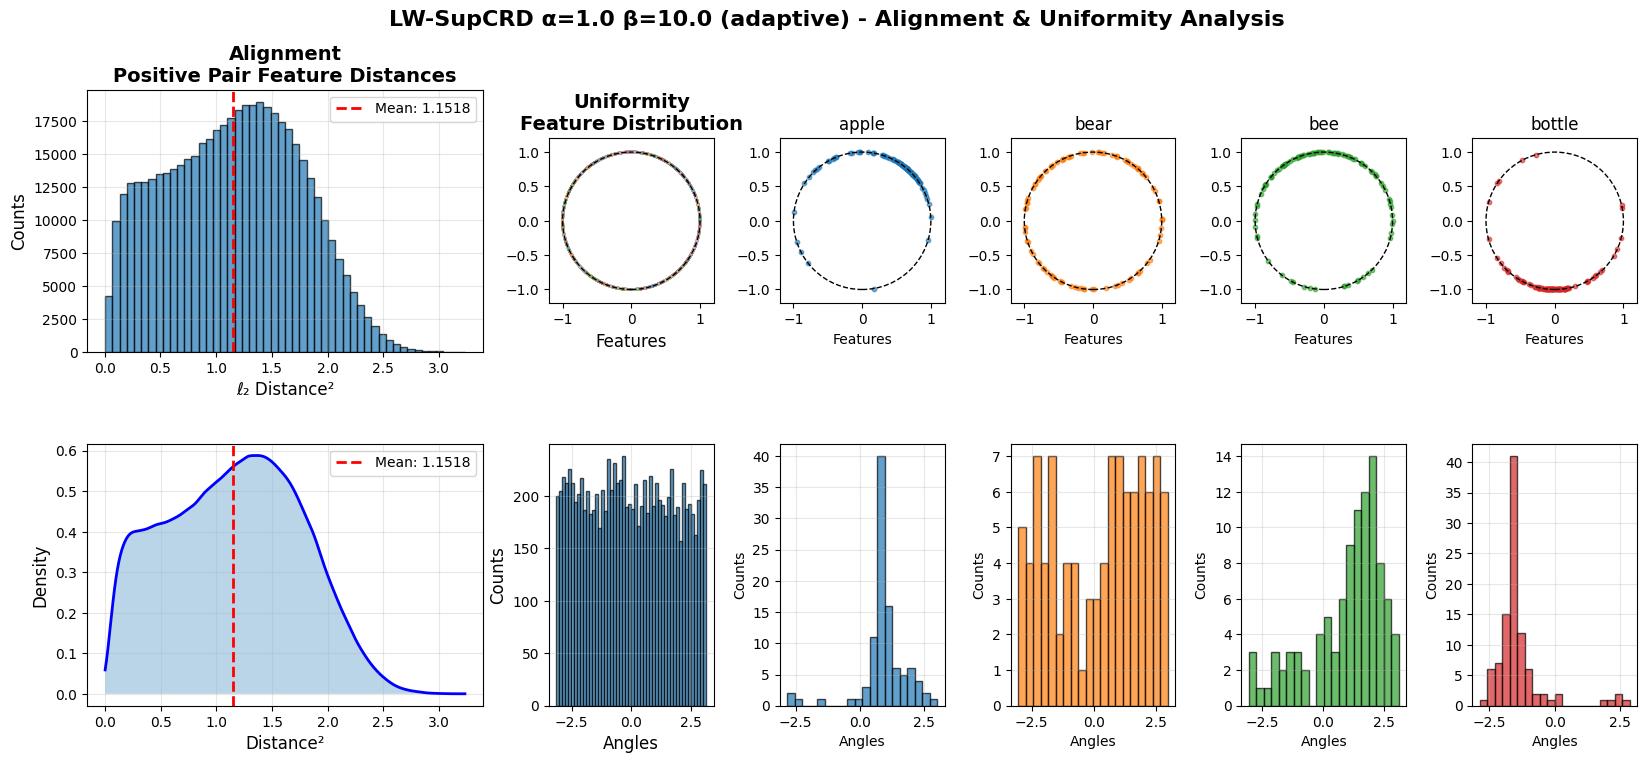


β=10.0 (adaptive) QUALITY SUMMARY
Test Accuracy: 73.19%

Hypersphere metrics:
  Intra-class: 0.5759
  Inter-class: 0.9939
  Separation ratio: 1.7259

Alignment & Uniformity:
  Alignment: 1.1518
  Uniformity: -3.7030


Testing α = 1.0, β = 12.0 (ADAPTIVE)
Loading alpha_1.0_beta_12.0_adaptive from pth_models/student_alpha_1.0_beta_12.0_adaptive_resnet18_cifar100.pth
  Train Acc (final): 88.09%

β=12.0 (adaptive): Train=88.09%, Test=71.31%

📊 Visualizing β=12.0 (adaptive)...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


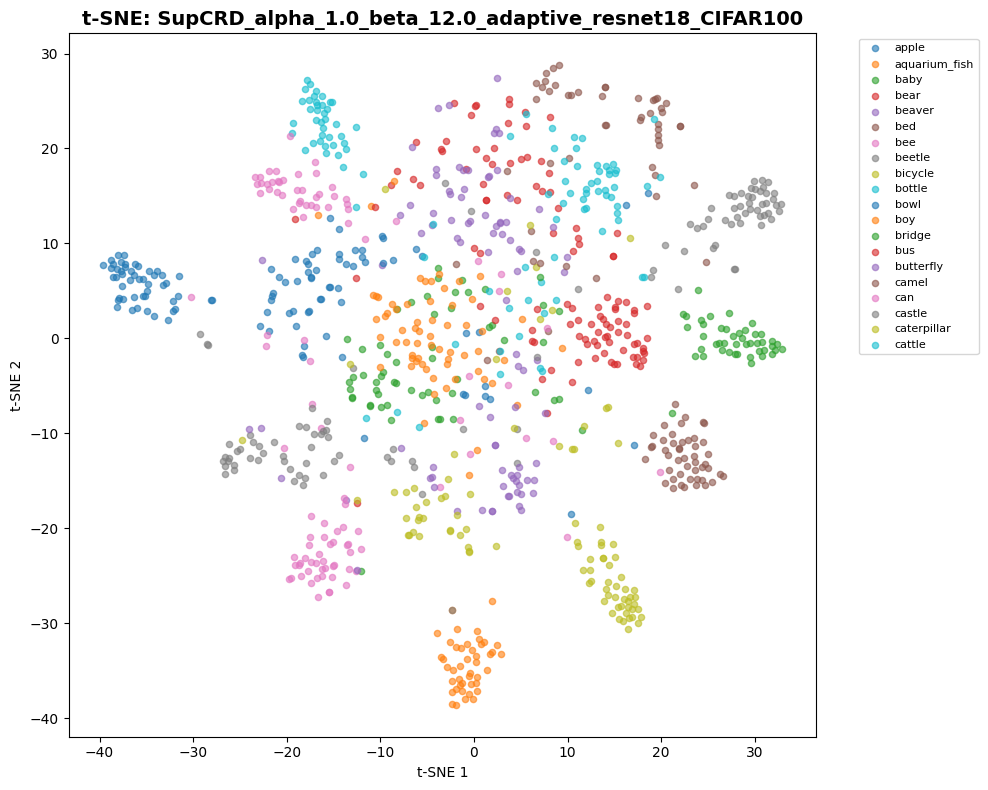

✓ β=12.0 visualization complete

📊 Quality Analysis for β=12.0...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 67.51it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 37.25% variance captured
PCA Stage 2 (10D → 3D): 33.41% of 10D captured
Total variance in 3D: 12.44% of original 64D
✓ Saved interactive plot to plots/beta_12.0_adaptive_hypersphere.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.6034
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9594
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 1.5900
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 69.23it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 52.27it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: LW-SupCRD α=1.0 β=12.0 (adaptive)
Alignment Loss (↓ better):     1.2068
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -3.6654
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             1.0602
Alignment std:                 0.2879
Angle std:                     1.8281

✓ Saved comprehensive visualization to plots/beta_12.0_adaptive_alignment.png


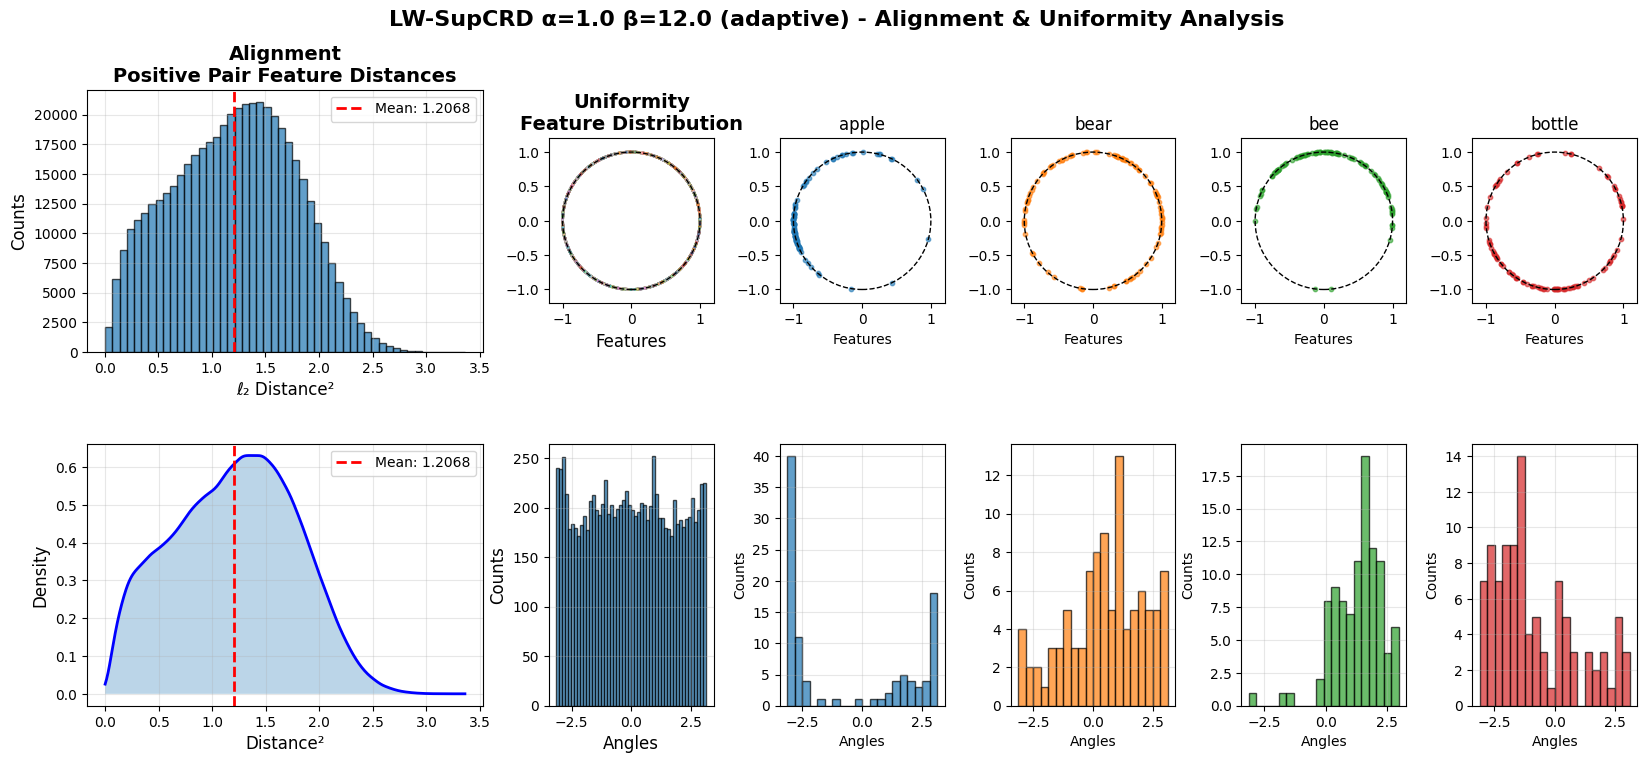


β=12.0 (adaptive) QUALITY SUMMARY
Test Accuracy: 71.31%

Hypersphere metrics:
  Intra-class: 0.6034
  Inter-class: 0.9594
  Separation ratio: 1.5900

Alignment & Uniformity:
  Alignment: 1.2068
  Uniformity: -3.6654


β SWEEP SUMMARY (α=1.0, τ=0.07, adaptive)
β=  1.0: Test=70.46% (Δ=+1.38%)
β=  5.0: Test=70.63% (Δ=+1.55%)
β= 10.0: Test=73.19% (Δ=+4.11%)
β= 12.0: Test=71.31% (Δ=+2.23%)

🏆 Best β: 10.0 with 73.19% accuracy



In [16]:
print("\n" + "="*60)
print("EXPERIMENT 4: β SWEEP (with adaptive β)")
print("="*60)

FORCE_RETRAIN_BETA_SWEEP = False
results_beta = {}

for beta_val in BETA_SWEEP:
    print(f"\n{'='*50}")
    print(f"Testing α = {ALPHA}, β = {beta_val} (ADAPTIVE)")
    print(f"{'='*50}")
    
    # Define paths
    exp_name = f"alpha_{ALPHA}_beta_{beta_val}_adaptive"
    model_path = f"pth_models/student_{exp_name}_{STUDENT_ARCH}_cifar100.pth"
    log_name = f"student_{exp_name}_{STUDENT_ARCH}_cifar100"
    
    # Check if model exists
    if os.path.exists(model_path) and not FORCE_RETRAIN_BETA_SWEEP:
        print(f"Loading {exp_name} from {model_path}")
        
        student_beta = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)
        student_beta.load_state_dict(torch.load(model_path, map_location=device))
        student_beta.eval()
        
        # Load training log
        log_beta = load_training_log(log_name)
        if log_beta:
            train_acc = log_beta["train_acc"][-1]
            print(f"  Train Acc (final): {train_acc:.2f}%")
    
    else:
        print(f"Training {exp_name} from scratch...")
        
        # Enable adaptive β
        criterion_beta = LogitWeightedSupCRDLoss(
            alpha=ALPHA,
            beta=beta_val,
            temperature=TEMP,
            adaptive_beta=True  # ENABLE ADAPTIVE β
        )
        
        student_beta = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)
        optimizer_beta = torch.optim.Adam(student_beta.parameters(), lr=LR)
        
        student_beta, log_beta = train_student_joint(
            teacher,
            student_beta,
            train_loader,
            optimizer_beta,
            criterion_beta,
            device,
            epochs=EPOCHS_STUDENT,
            label=f"LW-SupCRD β={beta_val} (adaptive)",
            mode="supcrd",
            log_name=log_name,
            joint_training=True
        )
        
        # Save model
        torch.save(student_beta.state_dict(), model_path)
        print(f"✓ Saved model to {model_path}")
    
    # Evaluate
    acc_beta = evaluate_model(student_beta, test_loader, device)
    results_beta[beta_val] = acc_beta
    
    print(f"\nβ={beta_val} (adaptive): Train={log_beta['train_acc'][-1]:.2f}%, Test={acc_beta:.2f}%")
    
    # ========== VISUALIZATIONS ==========
    
    # 1. Latent space (t-SNE)
    print(f"\n📊 Visualizing β={beta_val} (adaptive)...")
    visualize_latents(
        student_beta,
        test_loader,
        device,
        title=f"SupCRD_alpha_{ALPHA}_beta_{beta_val}_adaptive_{STUDENT_ARCH}_CIFAR100",
        sample_classes=sample_classes
    )
    print(f"✓ β={beta_val} visualization complete")
    
    # 2. Hypersphere distribution (3D interactive)
    print(f"\n📊 Quality Analysis for β={beta_val}...")
    metrics_beta_hyper = visualize_hypersphere_distribution(
        student_beta,
        test_loader,
        device,
        title=f"LW-SupCRD α={ALPHA} β={beta_val} (adaptive)",
        save_path=f"plots/beta_{beta_val}_adaptive_hypersphere.png"
    )
    
    # 3. Alignment & Uniformity (comprehensive)
    metrics_beta_align = visualize_alignment_uniformity(
        student_beta,
        test_loader,
        device,
        title=f"LW-SupCRD α={ALPHA} β={beta_val} (adaptive)",
        save_path=f"plots/beta_{beta_val}_adaptive_alignment.png"
    )
    
    # Print summary for this β
    print(f"\n{'='*50}")
    print(f"β={beta_val} (adaptive) QUALITY SUMMARY")
    print(f"{'='*50}")
    print(f"Test Accuracy: {acc_beta:.2f}%")
    print(f"\nHypersphere metrics:")
    print(f"  Intra-class: {metrics_beta_hyper['intra_class_dist']:.4f}")
    print(f"  Inter-class: {metrics_beta_hyper['inter_class_dist']:.4f}")
    print(f"  Separation ratio: {metrics_beta_hyper['separation_ratio']:.4f}")
    print(f"\nAlignment & Uniformity:")
    print(f"  Alignment: {metrics_beta_align['alignment']:.4f}")
    print(f"  Uniformity: {metrics_beta_align['uniformity']:.4f}")
    print(f"{'='*50}\n")

# ========== FINAL SUMMARY ==========
print("\n" + "="*60)
print(f"β SWEEP SUMMARY (α={ALPHA}, τ={TEMP}, adaptive)")
print("="*60)
for beta_val, acc in results_beta.items():
    delta = acc - acc_baseline
    print(f"β={beta_val:5.1f}: Test={acc:5.2f}% (Δ={delta:+.2f}%)")
print("="*60 + "\n")

# Find best β
best_beta = max(results_beta.items(), key=lambda x: x[1])
print(f"🏆 Best β: {best_beta[0]} with {best_beta[1]:.2f}% accuracy\n")

---
## EXPERIMENT 5: Temperature Sweep




EXPERIMENT 5: TEMPERATURE SWEEP

Testing Temperature = 0.05
Loading alpha_1.0_beta_10.0_temp_0.05 from pth_models/student_alpha_1.0_beta_10.0_temp_0.05_resnet18_cifar100.pth
  Train Acc (final): 78.83%

τ=0.05: Train=78.83%, Test=68.08%

📊 Visualizing τ=0.05...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


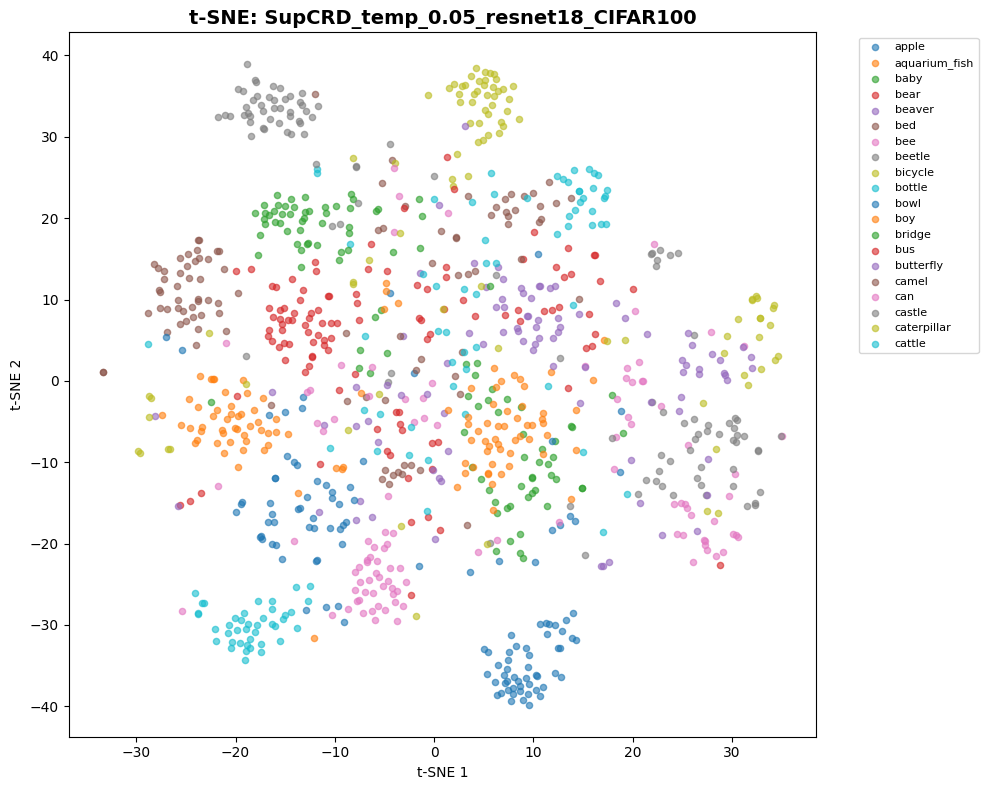

✓ τ=0.05 visualization complete

📊 Quality Analysis for τ=0.05...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 70.37it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 43.49% variance captured
PCA Stage 2 (10D → 3D): 35.30% of 10D captured
Total variance in 3D: 15.35% of original 64D
✓ Saved interactive plot to plots/temp_0.05_hypersphere.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.6752
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9767
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 1.4466
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 70.82it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 51.87it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: LW-SupCRD τ=0.05
Alignment Loss (↓ better):     1.3503
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -3.6645
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             1.1383
Alignment std:                 0.2337
Angle std:                     1.8090

✓ Saved comprehensive visualization to plots/temp_0.05_alignment.png


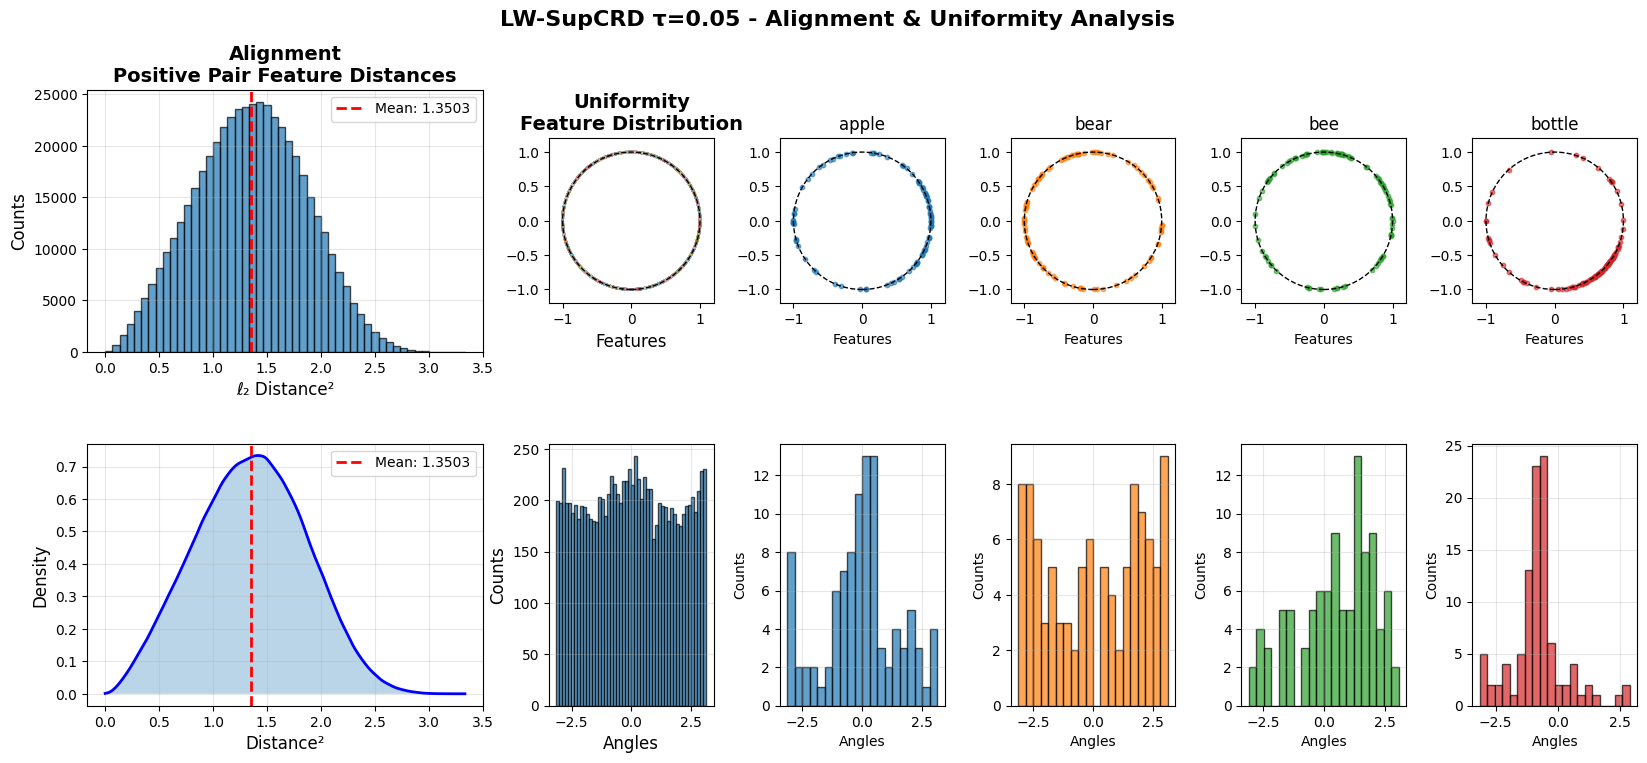


τ=0.05 QUALITY SUMMARY
Test Accuracy: 68.08%

Hypersphere metrics:
  Intra-class: 0.6752
  Inter-class: 0.9767
  Separation ratio: 1.4466

Alignment & Uniformity:
  Alignment: 1.3503
  Uniformity: -3.6645


Testing Temperature = 0.07
Loading alpha_1.0_beta_10.0_temp_0.07 from pth_models/student_alpha_1.0_beta_10.0_temp_0.07_resnet18_cifar100.pth
  Train Acc (final): 88.81%

τ=0.07: Train=88.81%, Test=73.35%

📊 Visualizing τ=0.07...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


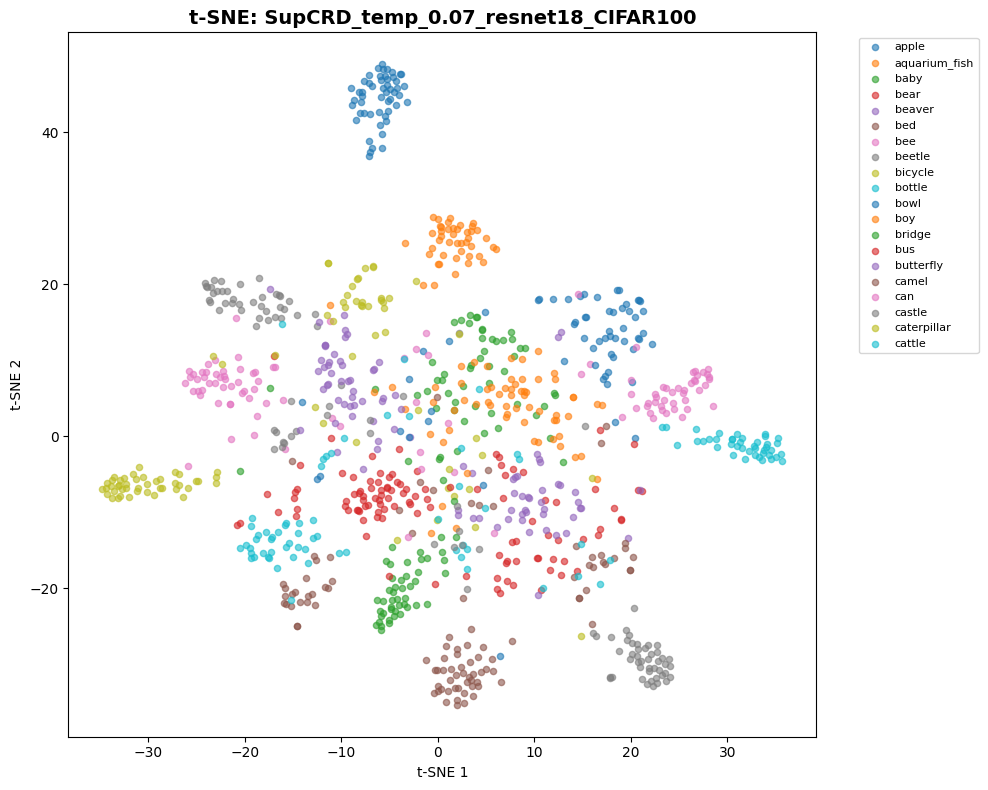

✓ τ=0.07 visualization complete

📊 Quality Analysis for τ=0.07...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 70.46it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 35.42% variance captured
PCA Stage 2 (10D → 3D): 32.74% of 10D captured
Total variance in 3D: 11.59% of original 64D
✓ Saved interactive plot to plots/temp_0.07_hypersphere.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.5995
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9919
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 1.6544
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 71.03it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 52.76it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: LW-SupCRD τ=0.07
Alignment Loss (↓ better):     1.1990
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -3.7104
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             1.0561
Alignment std:                 0.2892
Angle std:                     1.8018

✓ Saved comprehensive visualization to plots/temp_0.07_alignment.png


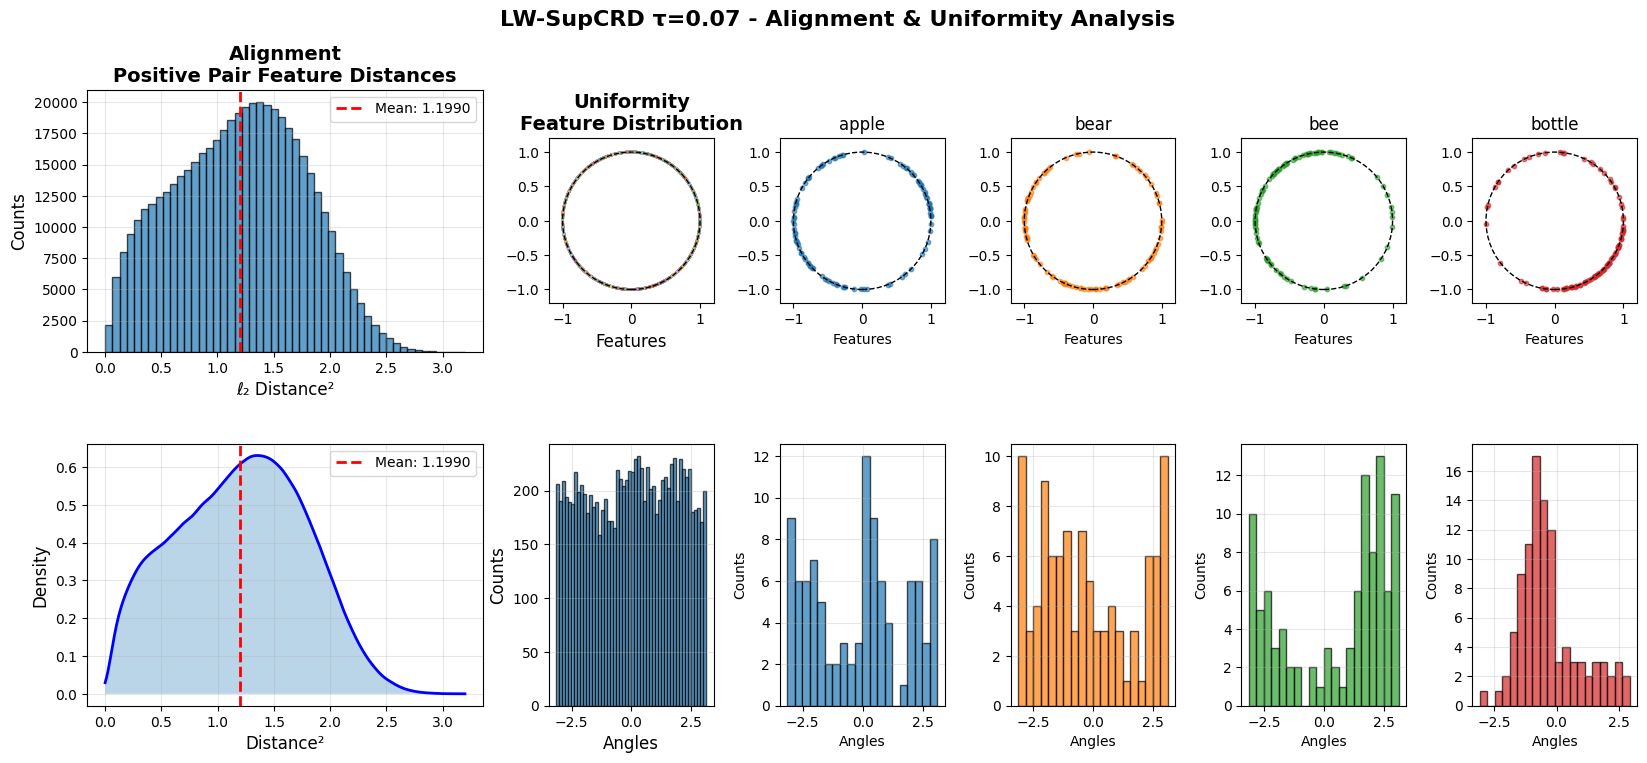


τ=0.07 QUALITY SUMMARY
Test Accuracy: 73.35%

Hypersphere metrics:
  Intra-class: 0.5995
  Inter-class: 0.9919
  Separation ratio: 1.6544

Alignment & Uniformity:
  Alignment: 1.1990
  Uniformity: -3.7104


TEMPERATURE SWEEP SUMMARY (α=1.0, β=10.0)
τ= 0.05: Test=68.08% (Δ=-1.00%)
τ= 0.07: Test=73.35% (Δ=+4.27%)

🏆 Best τ: 0.07 with 73.35% accuracy



In [17]:
print("\n" + "=" * 60)
print("EXPERIMENT 5: TEMPERATURE SWEEP")
print("=" * 60)

FORCE_RETRAIN_TEMP_SWEEP = False
results_temp = {}

for temp_val in TEMP_SWEEP:
    print(f"\n{'='*50}")
    print(f"Testing Temperature = {temp_val}")
    print(f"{'='*50}")

    # Define paths
    exp_name = f"alpha_{ALPHA}_beta_{BETA}_temp_{temp_val}"
    model_path = f"pth_models/student_{exp_name}_{STUDENT_ARCH}_cifar100.pth"
    log_name = f"student_{exp_name}_{STUDENT_ARCH}_cifar100"

    # Check if model exists
    if os.path.exists(model_path) and not FORCE_RETRAIN_TEMP_SWEEP:
        print(f"Loading {exp_name} from {model_path}")

        student_temp = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)
        student_temp.load_state_dict(torch.load(model_path, map_location=device))
        student_temp.eval()

        # Load training log
        log_temp = load_training_log(log_name)
        if log_temp:
            train_acc = log_temp["train_acc"][-1]
            print(f"  Train Acc (final): {train_acc:.2f}%")

    else:
        print(f"Training {exp_name} from scratch...")

        criterion_temp = LogitWeightedSupCRDLoss(
            alpha=ALPHA, beta=BETA, temperature=temp_val, adaptive_beta=True
        )

        student_temp = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)
        optimizer_temp = torch.optim.Adam(student_temp.parameters(), lr=LR)

        student_temp, log_temp = train_student_joint(
            teacher,
            student_temp,
            train_loader,
            optimizer_temp,
            criterion_temp,
            device,
            epochs=EPOCHS_STUDENT,
            label=f"LW-SupCRD τ={temp_val}",
            mode="supcrd",
            log_name=log_name,
            joint_training=True,
        )

        # Save model
        torch.save(student_temp.state_dict(), model_path)
        print(f"✓ Saved model to {model_path}")

    # Evaluate
    acc_temp = evaluate_model(student_temp, test_loader, device)
    results_temp[temp_val] = acc_temp

    print(
        f"\nτ={temp_val}: Train={log_temp['train_acc'][-1]:.2f}%, Test={acc_temp:.2f}%"
    )

    # ========== VISUALIZATIONS ==========

    # 1. Latent space (t-SNE)
    print(f"\n📊 Visualizing τ={temp_val}...")
    visualize_latents(
        student_temp,
        test_loader,
        device,
        title=f"SupCRD_temp_{temp_val}_{STUDENT_ARCH}_CIFAR100",
        sample_classes=sample_classes,
    )
    print(f"✓ τ={temp_val} visualization complete")

    # 2. Hypersphere distribution (3D interactive)
    print(f"\n📊 Quality Analysis for τ={temp_val}...")
    metrics_temp_hyper = visualize_hypersphere_distribution(
        student_temp,
        test_loader,
        device,
        title=f"LW-SupCRD τ={temp_val}",
        save_path=f"plots/temp_{temp_val}_hypersphere.png",
    )

    # 3. Alignment & Uniformity (comprehensive)
    metrics_temp_align = visualize_alignment_uniformity(
        student_temp,
        test_loader,
        device,
        title=f"LW-SupCRD τ={temp_val}",
        save_path=f"plots/temp_{temp_val}_alignment.png",
    )

    # Print summary for this τ
    print(f"\n{'='*50}")
    print(f"τ={temp_val} QUALITY SUMMARY")
    print(f"{'='*50}")
    print(f"Test Accuracy: {acc_temp:.2f}%")
    print(f"\nHypersphere metrics:")
    print(f"  Intra-class: {metrics_temp_hyper['intra_class_dist']:.4f}")
    print(f"  Inter-class: {metrics_temp_hyper['inter_class_dist']:.4f}")
    print(f"  Separation ratio: {metrics_temp_hyper['separation_ratio']:.4f}")
    print(f"\nAlignment & Uniformity:")
    print(f"  Alignment: {metrics_temp_align['alignment']:.4f}")
    print(f"  Uniformity: {metrics_temp_align['uniformity']:.4f}")
    print(f"{'='*50}\n")

# ========== FINAL SUMMARY ==========
print("\n" + "=" * 60)
print(f"TEMPERATURE SWEEP SUMMARY (α={ALPHA}, β={BETA})")
print("=" * 60)
for temp_val, acc in results_temp.items():
    delta = acc - acc_baseline
    print(f"τ={temp_val:5.2f}: Test={acc:5.2f}% (Δ={delta:+.2f}%)")
print("=" * 60 + "\n")

# Find best τ
best_temp = max(results_temp.items(), key=lambda x: x[1])
print(f"🏆 Best τ: {best_temp[0]} with {best_temp[1]:.2f}% accuracy\n")

## EXPERIMENT 6: Memory Bank Ablation

In [18]:
# ============================================================
# MEMORY BANK ABLATION - PART 1: Momentum Memory Bank (Adapter)
# ============================================================
class MomentumMemoryBank(nn.Module):
    """
    Index-based momentum memory bank (CRD-style, adapted for compatibility)
    Stores features, labels, and logits for entire dataset with momentum updates
    """
    def __init__(self, n_data=50000, dim=64, K=4096, momentum=0.5, num_classes=100):
        super().__init__()
        self.n_data = n_data
        self.dim = dim
        self.K = K
        self.momentum = momentum
        self.size = K  # For compatibility with loss function checks
        self.num_classes = num_classes
        # Initialize memory buffers for full dataset
        stdv = 1.0 / math.sqrt(dim / 3)
        self.register_buffer(
            "memory_features", torch.rand(n_data, dim).mul_(2 * stdv).add_(-stdv)
        )
        self.register_buffer("memory_labels", torch.zeros(n_data, dtype=torch.long))
        self.register_buffer("memory_logits", torch.zeros(n_data, num_classes))
        # Normalize features to unit sphere
        self.memory_features = F.normalize(self.memory_features, dim=1)
        # Mock attributes for compatibility with existing loss functions
        self.register_buffer("queue", torch.zeros(dim, K))
        self.register_buffer("queue_labels", torch.zeros(K, dtype=torch.long))
        self.register_buffer("queue_logits", torch.zeros(K, num_classes))
    
    def update(self, features, labels, logits=None):
        """
        Dummy function for compatibility with existing code that calls memory_bank.update()
        Actual update happens in forward()
        """
        pass
    
    def forward(self, features, indices, labels, logits=None, update=True):
        """
        Main function: Updates memory and samples negatives
        Args:
            features: [B, dim] teacher/student features
            indices: [B] dataset indices for these samples
            labels: [B] class labels for these samples
            logits: [B, num_classes] teacher logits (optional)
            update: whether to perform momentum update
        Returns:
            sampled features (updates self.queue attributes as side effect)
        """
        batch_size = features.shape[0]
        # 1. Momentum Update
        if update:
            with torch.no_grad():
                # Normalize input features
                features_norm = F.normalize(features, dim=1)
                # Get old features from memory
                old_features = self.memory_features[indices]
                # Momentum update: new = m * old + (1-m) * new
                new_features = (
                    self.momentum * old_features + (1.0 - self.momentum) * features_norm
                )
                new_features = F.normalize(new_features, dim=1)
                # Update memory
                self.memory_features[indices] = new_features
                self.memory_labels[indices] = labels
                # Update logits if provided
                if logits is not None:
                    old_logits = self.memory_logits[indices]
                    new_logits = (
                        self.momentum * old_logits + (1.0 - self.momentum) * logits
                    )
                    self.memory_logits[indices] = new_logits
        
        # 2. Sample K random negatives from full dataset
        sample_idx = torch.randperm(self.n_data, device=features.device)[: self.K]
        bank_features = self.memory_features[sample_idx]  # [K, dim]
        bank_labels = self.memory_labels[sample_idx]  # [K]
        bank_logits = self.memory_logits[sample_idx]  # [K, num_classes]
        
        # 3. Update "queue" attributes for compatibility with existing loss functions
        self.queue = bank_features.T  # [dim, K] - transposed for compatibility
        self.queue_labels = bank_labels  # [K]
        self.queue_logits = bank_logits  # [K, num_classes]
        
        return bank_features.detach()


# ============================================================
# Dataset Wrapper (Required for Index-Based Memory)
# ============================================================
class CIFAR100Instance(torchvision.datasets.CIFAR100):
    """CIFAR-100 dataset that returns (image, label, index)"""
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        return img, target, index


# ============================================================
# Recreate DataLoader with Index Support + LARGER BATCH SIZE
# ============================================================
BATCH_SIZE_ABLATION = 128

# Recreate train_set with the new wrapper
train_set_indexed = CIFAR100Instance(
    root="./data", train=True, download=True, transform=transform_train_multiview
)
train_loader = DataLoader(
    train_set_indexed,
    batch_size=BATCH_SIZE_ABLATION,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True,  # Important for consistent batch sizes
)

print(f"✅ DataLoader created with batch size: {BATCH_SIZE_ABLATION}")


def crd_loss_with_bank(student_proj, teacher_proj, labels, memory_bank=None, tau=0.07):
    """
    Baseline CRD loss with optional memory bank negatives.
    Compatible with existing BaseCRDLoss structure.
    """
    batch_size = student_proj.shape[0]
    s_norm = F.normalize(student_proj, dim=1)
    t_norm = F.normalize(teacher_proj, dim=1)
    
    # Concatenate first, then apply single max
    sim_batch = torch.matmul(s_norm, t_norm.T) / tau
    if memory_bank is not None and memory_bank.size > 0:
        bank_feats = memory_bank.queue.T.detach()  # Explicit detach
        sim_bank = torch.matmul(s_norm, bank_feats.T) / tau
        all_sims = torch.cat([sim_batch, sim_bank], dim=1)  # Concat first
    else:
        all_sims = sim_batch
    
    # Single global max for stability
    sim_max, _ = torch.max(all_sims, dim=1, keepdim=True)
    all_sims = all_sims - sim_max.detach()
    all_sims = torch.clamp(all_sims, min=-50, max=50)
    exp_all = torch.exp(all_sims)
    
    # Positives on diagonal, pad mask if using bank
    mask_pos = torch.eye(batch_size, device=student_proj.device)
    if memory_bank is not None and memory_bank.size > 0:
        mask_pos = torch.cat(
            [
                mask_pos,
                torch.zeros(batch_size, memory_bank.size, device=student_proj.device),
            ],
            dim=1,
        )
    
    numerator = (exp_all * mask_pos).sum(dim=1)
    denominator = exp_all.sum(dim=1)
    loss = -torch.log(numerator / (denominator + 1e-8))
    return loss.mean()


def lwsupcrd_loss_with_bank(
    student_proj,
    teacher_proj,
    teacher_logits,
    labels,
    memory_bank=None,
    alpha=1.0,
    beta=10.0,
    tau=0.07,
    adaptive_beta=True,
):
    """
    LW-SupCRD loss with optional memory bank negatives.
    Based on existing LogitWeightedSupCRDLoss structure.
    """
    batch_size = student_proj.shape[0]
    device = student_proj.device
    
    s_norm = F.normalize(student_proj, dim=1)
    t_norm = F.normalize(teacher_proj, dim=1)
    teacher_probs = F.softmax(teacher_logits, dim=1)
    labels = labels.view(-1, 1)
    
    # Compute similarities (concat if bank exists)
    sim_batch = torch.matmul(s_norm, t_norm.T) / tau
    if memory_bank is not None and memory_bank.size > 0:
        bank_feats = memory_bank.queue.T.detach()
        sim_bank = torch.matmul(s_norm, bank_feats.T) / tau
        all_sims = torch.cat([sim_batch, sim_bank], dim=1)
    else:
        all_sims = sim_batch
    
    sim_max, _ = torch.max(all_sims, dim=1, keepdim=True)
    all_sims = all_sims - sim_max.detach()
    all_sims = torch.clamp(all_sims, min=-50, max=50)
    exp_all = torch.exp(all_sims)
    
    # Split consistently
    exp_batch = exp_all[:, :batch_size]
    if memory_bank is not None and memory_bank.size > 0:
        exp_bank = exp_all[:, batch_size:]
    
    # Compute weights
    mask_pos = torch.eq(labels, labels.T).float().to(device)
    mask_neg = 1.0 - mask_pos
    
    p_target = torch.gather(teacher_probs, 1, labels).view(-1)
    w_pull = alpha * p_target
    
    target_labels_expand = labels.view(1, -1).expand(batch_size, -1)
    p_negative_class = torch.gather(teacher_probs, 1, target_labels_expand)
    
    if adaptive_beta:
        beta_effective = beta / (p_target + 0.5)
        w_push = beta_effective.view(-1, 1) * (1.0 - p_negative_class)
    else:
        w_push = beta * (1.0 - p_negative_class)
    
    sum_pos_exp = (exp_batch * mask_pos).sum(dim=1)
    numerator_term = w_pull * sum_pos_exp
    weighted_neg_exp = (exp_batch * w_push * mask_neg).sum(dim=1)
    denominator_term = numerator_term + weighted_neg_exp
    
    # Add bank component
    if memory_bank is not None and memory_bank.size > 0:
        bank_labels = memory_bank.queue_labels
        bank_logits = memory_bank.queue_logits
        bank_probs = F.softmax(bank_logits, dim=1)
        
        mask_bank_same_class = torch.eq(labels, bank_labels.view(1, -1))
        mask_bank_neg = (~mask_bank_same_class).float()
        
        p_bank_at_target = bank_probs.T[labels.view(-1)]
        
        if adaptive_beta:
            beta_factor = beta / (p_target + 0.5)
            w_push_bank = beta_factor.view(-1, 1) * (1.0 - p_bank_at_target)
        else:
            w_push_bank = beta * (1.0 - p_bank_at_target)
        
        weighted_bank_sum = (w_push_bank * exp_bank * mask_bank_neg).sum(dim=1)
        denominator_term = denominator_term + weighted_bank_sum
    
    loss = -torch.log((numerator_term + 1e-8) / (denominator_term + 1e-8))
    return (loss / alpha).mean()

✅ DataLoader created with batch size: 128


In [19]:
# ============================================================
# MEMORY BANK ABLATION - PART 2: Training Function (ADAM + WEIGHT DECAY)
# ============================================================
FORCE_RETRAIN_BANK_ABLATION = False


def train_student_with_bank(
    model_name,
    loss_type,
    bank_size=0,
    alpha=1.0,
    beta=10.0,
    tau=0.07,
    adaptive_beta=True,
):
    model_path = f"pth_models/student_{model_name}_{STUDENT_ARCH}_cifar100.pth"
    log_path = f"json_results/training_logs/{model_name}_training_log.json"

    # Check if already trained
    if os.path.exists(model_path) and not FORCE_RETRAIN_BANK_ABLATION:
        print(f"Loading {model_name} from {model_path}")
        student = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)
        student.load_state_dict(torch.load(model_path))
        with open(log_path, "r") as f:
            training_log = json.load(f)
        print(f"  Final training accuracy: {training_log['train_acc'][-1]:.2f}%")
        return student, training_log

    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print(f"  Loss type: {loss_type}")
    print(
        f"  Bank size: {bank_size} ({'no bank' if bank_size == 0 else f'{bank_size} samples'})"
    )
    print(f"{'='*60}")

    epochs_to_train = 50
    base_lr = 0.001

    # Initialize student
    student = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)
    
    if bank_size >= 8192:
        weight_decay = 5e-4  # 5× stronger
    else:
        weight_decay = 1e-4  # baseline

    # ✅ ADAM with WEIGHT DECAY (AdamW-like behavior)
    optimizer_student = torch.optim.Adam(
        student.parameters(),
        lr=base_lr,
        weight_decay=weight_decay,
    )

    # Initialize momentum memory bank
    memory_bank = None
    if bank_size > 0:
        memory_bank = MomentumMemoryBank(
            n_data=len(train_set_indexed),
            dim=64,
            K=bank_size,
            momentum=0.5,
            num_classes=100,
        ).to(device)
        print(f"✓ Initialized Momentum Memory Bank")
        print(f"  - Full dataset: {len(train_set_indexed)} samples")
        print(f"  - Negatives per batch: {bank_size}")
        print(f"  - Momentum: 0.5")

    # Linear classifier
    linear_classifier = nn.Linear(student.feature_dim, 100).to(device)
    classifier_opt = torch.optim.Adam(
        linear_classifier.parameters(), lr=base_lr, weight_decay=weight_decay
    )
    classifier_criterion = nn.CrossEntropyLoss()

    # Teacher projection optimizer (10× lower LR)
    optimizer_teacher_proj = torch.optim.Adam(
        teacher.projection.parameters(), lr=base_lr / 10, weight_decay=weight_decay
    )
    teacher.projection.train()

    # ============================================================
    # WARMUP + COSINE ANNEALING SCHEDULER
    # ============================================================
    warmup_epochs = 5

    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return float(epoch + 1) / float(warmup_epochs)
        else:
            progress = float(epoch - warmup_epochs) / float(
                epochs_to_train - warmup_epochs
            )
            return 0.5 * (1.0 + math.cos(math.pi * progress))

    scheduler_student = torch.optim.lr_scheduler.LambdaLR(optimizer_student, lr_lambda)
    scheduler_teacher = torch.optim.lr_scheduler.LambdaLR(
        optimizer_teacher_proj, lr_lambda
    )
    scheduler_clf = torch.optim.lr_scheduler.LambdaLR(classifier_opt, lr_lambda)

    print(f"  🔧 Using warmup ({warmup_epochs} epochs) + cosine annealing")
    print(f"  🔧 Base LR: student={base_lr:.6f}, teacher_proj={base_lr/10:.6f}")
    print(f"  🔧 Optimizer: Adam (weight_decay={weight_decay}) ← PREVENTS OVERFITTING")
    print(f"  🔧 Batch size: {BATCH_SIZE_ABLATION}")

    # Training log (WITH TEST ACCURACY TRACKING)
    training_log = {
        "epochs": [],
        "contrastive_loss": [],
        "train_acc": [],
        "test_acc": [],
    }

    # Best model tracking
    best_test_acc = 0.0

    # ============================================================
    # TRAINING LOOP
    # ============================================================
    for epoch in range(epochs_to_train):
        student.train()
        total_loss = 0.0
        correct = 0
        total = 0

        # Print current LR
        if epoch % 10 == 0:
            current_lr_student = optimizer_student.param_groups[0]["lr"]
            current_lr_teacher = optimizer_teacher_proj.param_groups[0]["lr"]
            print(
                f"  [Epoch {epoch+1}] LR: student={current_lr_student:.6f}, teacher_proj={current_lr_teacher:.6f}"
            )

        # ✅ DATALOADER NOW RETURNS INDICES
        for (view1, view2), labels_batch, indices in tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{epochs_to_train}"
        ):
            images = torch.cat([view1, view2], dim=0).to(device)
            labels_multi = torch.cat([labels_batch, labels_batch], dim=0).to(device)
            indices_multi = torch.cat([indices, indices], dim=0).to(device)

            optimizer_student.zero_grad()
            optimizer_teacher_proj.zero_grad()

            # Get teacher features and logits
            with torch.no_grad():
                teacher_output = teacher(images)
                if isinstance(teacher_output, tuple):
                    teacher_features, _, teacher_logits = teacher_output
                else:
                    original_fc = teacher.fc
                    teacher.fc = nn.Identity()
                    teacher_features = teacher(images)
                    teacher.fc = original_fc
                    teacher_logits = teacher(images)

            # Forward pass
            teacher_proj = teacher.projection(teacher_features.detach())
            student_features = student.encoder(images)
            student_proj = student.projector(student_features)

            # ✅ UPDATE MOMENTUM BANK (hidden from loss function)
            if memory_bank is not None:
                memory_bank(
                    teacher_proj,
                    indices_multi,
                    labels_multi,
                    teacher_logits,
                    update=True,
                )

            # ✅ COMPUTE LOSS (Your original functions - unchanged!)
            if loss_type == "crd":
                loss = crd_loss_with_bank(
                    student_proj, teacher_proj, labels_multi, memory_bank, tau
                )
            else:  # lwsupcrd
                loss = lwsupcrd_loss_with_bank(
                    student_proj,
                    teacher_proj,
                    teacher_logits,
                    labels_multi,
                    memory_bank,
                    alpha,
                    beta,
                    tau,
                    adaptive_beta,
                )

            # NaN guard
            if torch.isnan(loss):
                print(f"⚠️  NaN loss at epoch {epoch+1}, skipping batch")
                continue

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(student.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(
                teacher.projection.parameters(), max_norm=1.0
            )

            # Optimizer step
            optimizer_student.step()
            optimizer_teacher_proj.step()

            total_loss += loss.item()

            # Train linear classifier
            with torch.no_grad():
                frozen_features = student.encoder(view1.to(device))
            logits = linear_classifier(frozen_features)
            clf_loss = classifier_criterion(logits, labels_batch.to(device))

            classifier_opt.zero_grad()
            clf_loss.backward()
            torch.nn.utils.clip_grad_norm_(linear_classifier.parameters(), max_norm=1.0)
            classifier_opt.step()

            # Compute accuracy
            _, predicted = logits.max(1)
            total += labels_batch.size(0)
            correct += predicted.eq(labels_batch.to(device)).sum().item()

        # Step schedulers
        scheduler_student.step()
        scheduler_teacher.step()
        scheduler_clf.step()

        # Log train metrics
        avg_loss = total_loss / len(train_loader)
        train_acc = 100.0 * correct / total

        # ✅ EVALUATE ON TEST SET
        student.eval()
        test_acc = evaluate_model(student, test_loader, device)
        student.train()

        # Update logs
        training_log["epochs"].append(epoch + 1)
        training_log["contrastive_loss"].append(avg_loss)
        training_log["train_acc"].append(train_acc)
        training_log["test_acc"].append(test_acc)

        # ✅ PRINT WITH TEST ACCURACY
        print(
            f"  Epoch {epoch+1}/{epochs_to_train}, "
            f"Loss: {avg_loss:.4f}, "
            f"Train: {train_acc:.1f}%, "
            f"Test: {test_acc:.2f}%"
        )

        # ✅ SAVE BEST MODEL
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            print(f"    ✨ New best test acc: {test_acc:.2f}%")
            best_model_path = model_path.replace(".pth", "_best.pth")
            # Save best checkpoint
            student.classifier.load_state_dict(linear_classifier.state_dict())
            torch.save(student.state_dict(), best_model_path)

    # Copy classifier to student (final model)
    student.classifier.load_state_dict(linear_classifier.state_dict())

    # Save final model
    torch.save(student.state_dict(), model_path)
    with open(log_path, "w") as f:
        json.dump(training_log, f, indent=2)

    print(f"✓ Model saved to {model_path}")
    print(
        f"✓ Best model saved to {best_model_path.replace('.pth', '_best.pth')} ({best_test_acc:.2f}%)"
    )
    return student, training_log


print(
    "✓ Training function defined (Adam + weight_decay = fast convergence + no overfitting)"
)

✓ Training function defined (Adam + weight_decay = fast convergence + no overfitting)


In [20]:
# ============================================================
# RUN MEMORY BANK ABLATION EXPERIMENTS
# ============================================================
print("\n" + "=" * 60)
print("MEMORY BANK ABLATION EXPERIMENTS")
print("=" * 60)

experiments = [
    ("baseline_crd_nobank", "crd", 0),
    ("baseline_crd_bank4096", "crd", 4096),
    ("lwsupcrd_nobank", "lwsupcrd", 0),
    ("lwsupcrd_bank4096", "lwsupcrd", 4096),
]

results = {}

for model_name, loss_type, bank_size in experiments:
    if loss_type == "crd":
        student, log = train_student_with_bank(
            model_name=model_name, loss_type=loss_type, bank_size=bank_size, tau=0.07
        )
    else:  # lwsupcrd
        student, log = train_student_with_bank(
            model_name=model_name,
            loss_type=loss_type,
            bank_size=bank_size,
            alpha=1.0,
            beta=10.0,
            tau=0.07,
            adaptive_beta=True,
        )

    # Evaluate final model
    test_acc = evaluate_model(student, test_loader, device)

    # Get best test accuracy from training log
    best_test_acc = max(log.get("test_acc", [test_acc]))
    best_epoch = (
        log["test_acc"].index(best_test_acc) + 1
        if "test_acc" in log
        else len(log["epochs"])
    )

    results[model_name] = {
        "loss_type": loss_type,
        "bank_size": bank_size,
        "final_test_acc": test_acc,
        "best_test_acc": best_test_acc,
        "best_epoch": best_epoch,
        "train_acc": log["train_acc"][-1],
        "final_loss": log["contrastive_loss"][-1],
    }

    print(f"\n{'='*60}")
    print(f"{model_name.upper()} RESULTS")
    print(f"{'='*60}")
    print(f"Final Test Accuracy: {test_acc:.2f}%")
    print(f"Best Test Accuracy:  {best_test_acc:.2f}% (Epoch {best_epoch})")
    print(f"Train Accuracy:      {log['train_acc'][-1]:.2f}%")
    print(f"Train-Test Gap:      {log['train_acc'][-1] - test_acc:.2f}%")
    print(f"{'='*60}\n")

print("\n✓ All training complete!")


MEMORY BANK ABLATION EXPERIMENTS
Loading baseline_crd_nobank from pth_models/student_baseline_crd_nobank_resnet18_cifar100.pth
  Final training accuracy: 73.70%

BASELINE_CRD_NOBANK RESULTS
Final Test Accuracy: 68.15%
Best Test Accuracy:  68.28% (Epoch 48)
Train Accuracy:      73.70%
Train-Test Gap:      5.55%

Loading baseline_crd_bank4096 from pth_models/student_baseline_crd_bank4096_resnet18_cifar100.pth
  Final training accuracy: 78.57%

BASELINE_CRD_BANK4096 RESULTS
Final Test Accuracy: 69.56%
Best Test Accuracy:  69.67% (Epoch 49)
Train Accuracy:      78.57%
Train-Test Gap:      9.01%

Loading lwsupcrd_nobank from pth_models/student_lwsupcrd_nobank_resnet18_cifar100.pth
  Final training accuracy: 89.72%

LWSUPCRD_NOBANK RESULTS
Final Test Accuracy: 74.76%
Best Test Accuracy:  74.86% (Epoch 49)
Train Accuracy:      89.72%
Train-Test Gap:      14.96%

Loading lwsupcrd_bank4096 from pth_models/student_lwsupcrd_bank4096_resnet18_cifar100.pth
  Final training accuracy: 95.72%

LWSUPC


VISUALIZING: BASELINE_CRD_NOBANK
📊 Generating t-SNE visualization...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


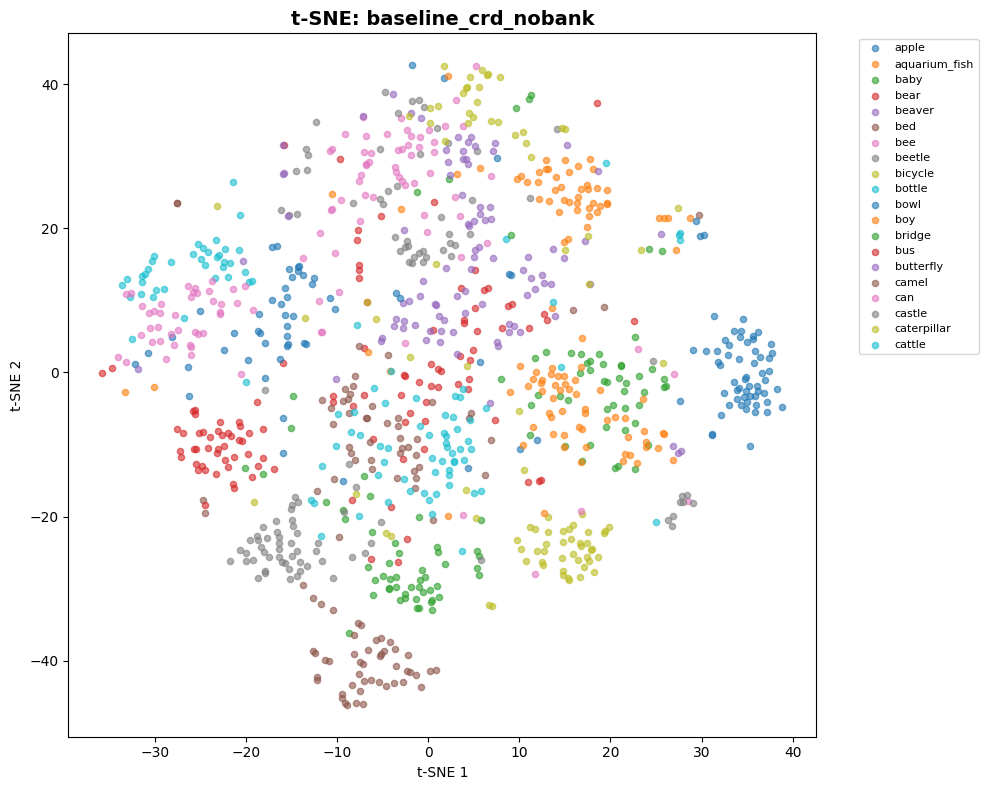

✓ t-SNE visualization complete
📊 Generating 3D hypersphere distribution...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 69.16it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 47.93% variance captured
PCA Stage 2 (10D → 3D): 40.03% of 10D captured
Total variance in 3D: 19.19% of original 64D
✓ Saved interactive plot to plots/baseline_crd_nobank_hypersphere.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.4581
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.2852
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 0.6225
  → Higher = better overall (clear clusters)

📊 Computing alignment & uniformity...
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 70.28it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 52.09it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: baseline_crd_nobank
Alignment Loss (↓ better):     0.9162
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -2.2804
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             0.9395
Alignment std:                 0.1832
Angle std:                     1.8776

✓ Saved comprehensive visualization to plots/baseline_crd_nobank_alignment.png


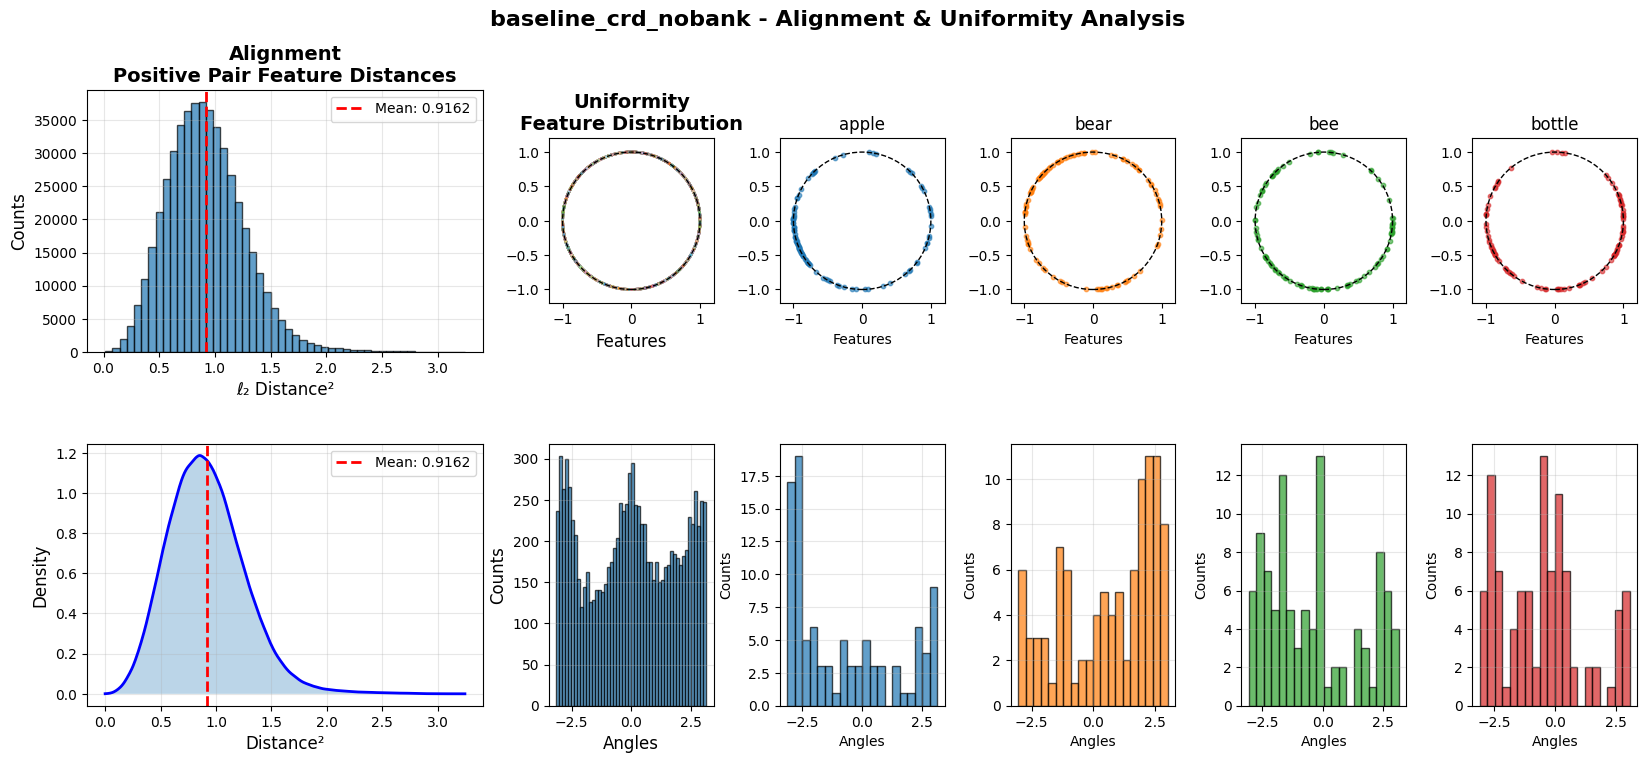


VISUALIZING: BASELINE_CRD_BANK4096
📊 Generating t-SNE visualization...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


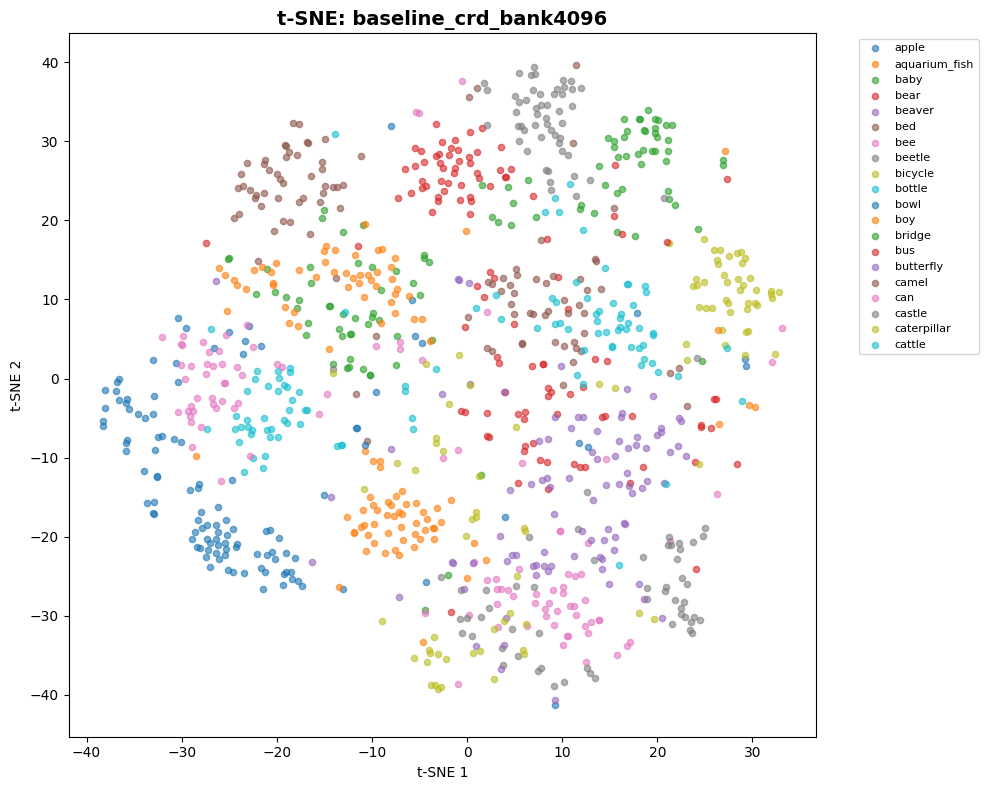

✓ t-SNE visualization complete
📊 Generating 3D hypersphere distribution...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 69.67it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 49.54% variance captured
PCA Stage 2 (10D → 3D): 36.27% of 10D captured
Total variance in 3D: 17.97% of original 64D
✓ Saved interactive plot to plots/baseline_crd_bank4096_hypersphere.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.4049
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.2564
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 0.6332
  → Higher = better overall (clear clusters)

📊 Computing alignment & uniformity...
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 71.89it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 52.34it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: baseline_crd_bank4096
Alignment Loss (↓ better):     0.8098
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -2.0739
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             0.8828
Alignment std:                 0.1743
Angle std:                     1.8063

✓ Saved comprehensive visualization to plots/baseline_crd_bank4096_alignment.png


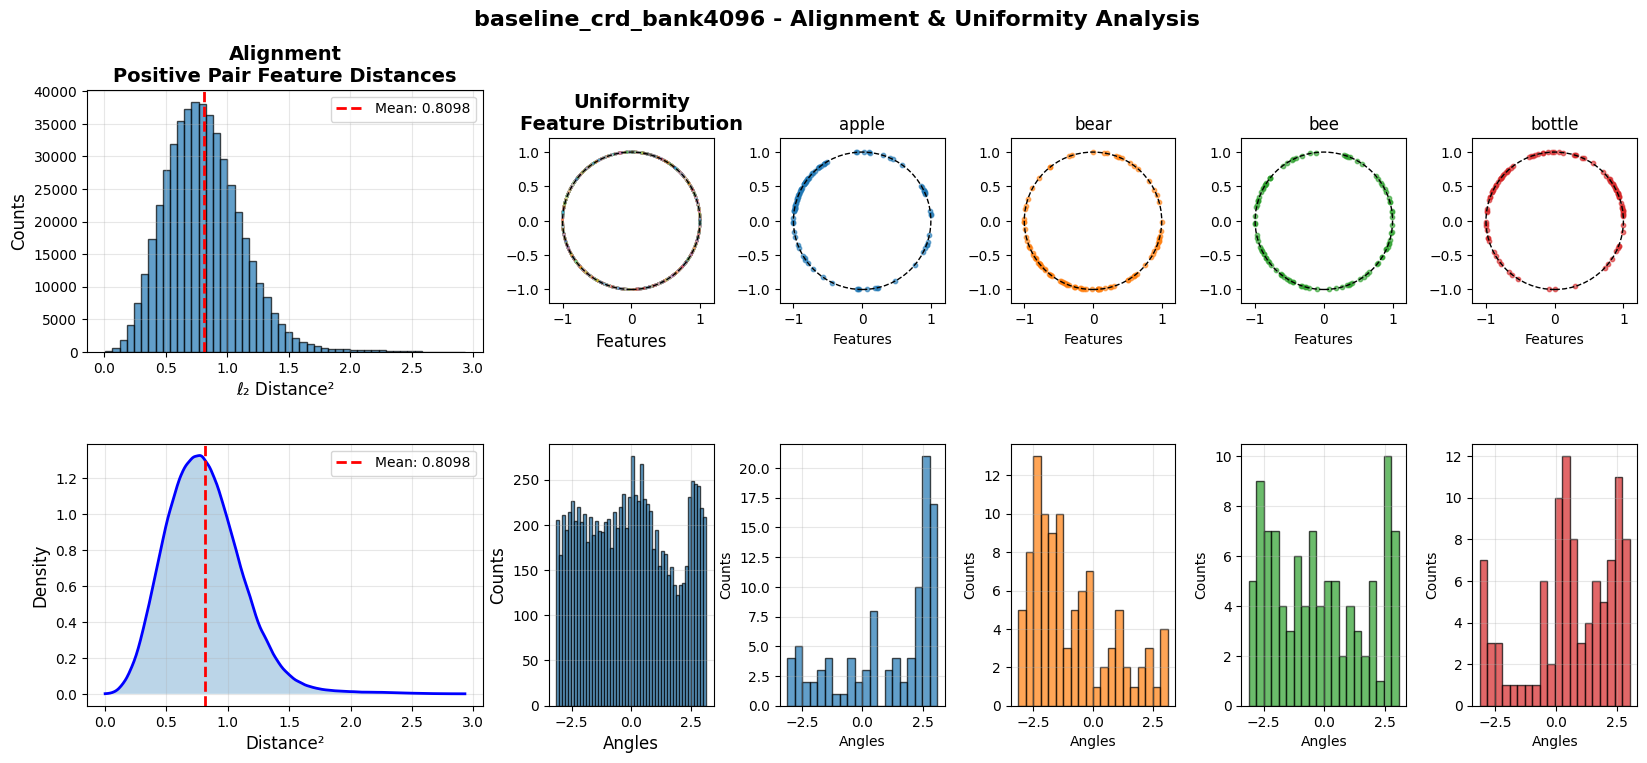


VISUALIZING: LWSUPCRD_NOBANK
📊 Generating t-SNE visualization...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


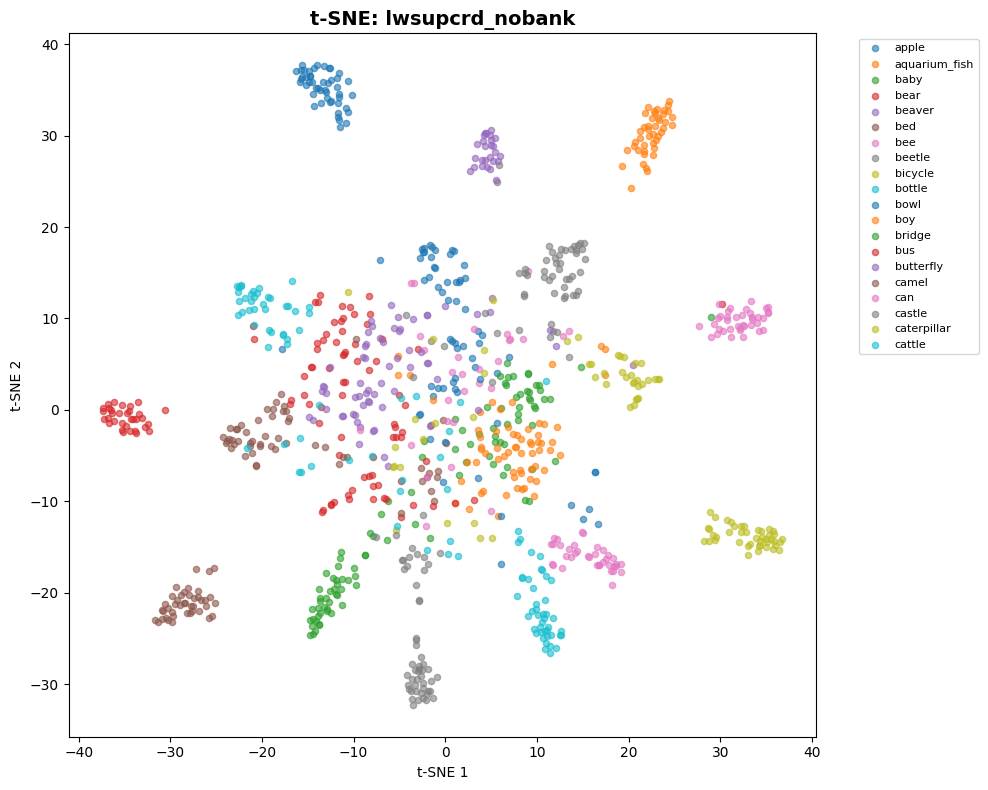

✓ t-SNE visualization complete
📊 Generating 3D hypersphere distribution...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 70.23it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 31.80% variance captured
PCA Stage 2 (10D → 3D): 31.98% of 10D captured
Total variance in 3D: 10.17% of original 64D
✓ Saved interactive plot to plots/lwsupcrd_nobank_hypersphere.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.5417
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 1.0071
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 1.8590
  → Higher = better overall (clear clusters)

📊 Computing alignment & uniformity...
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 70.12it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 52.30it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: lwsupcrd_nobank
Alignment Loss (↓ better):     1.0835
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -3.7314
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             0.9864
Alignment std:                 0.3325
Angle std:                     1.8112

✓ Saved comprehensive visualization to plots/lwsupcrd_nobank_alignment.png


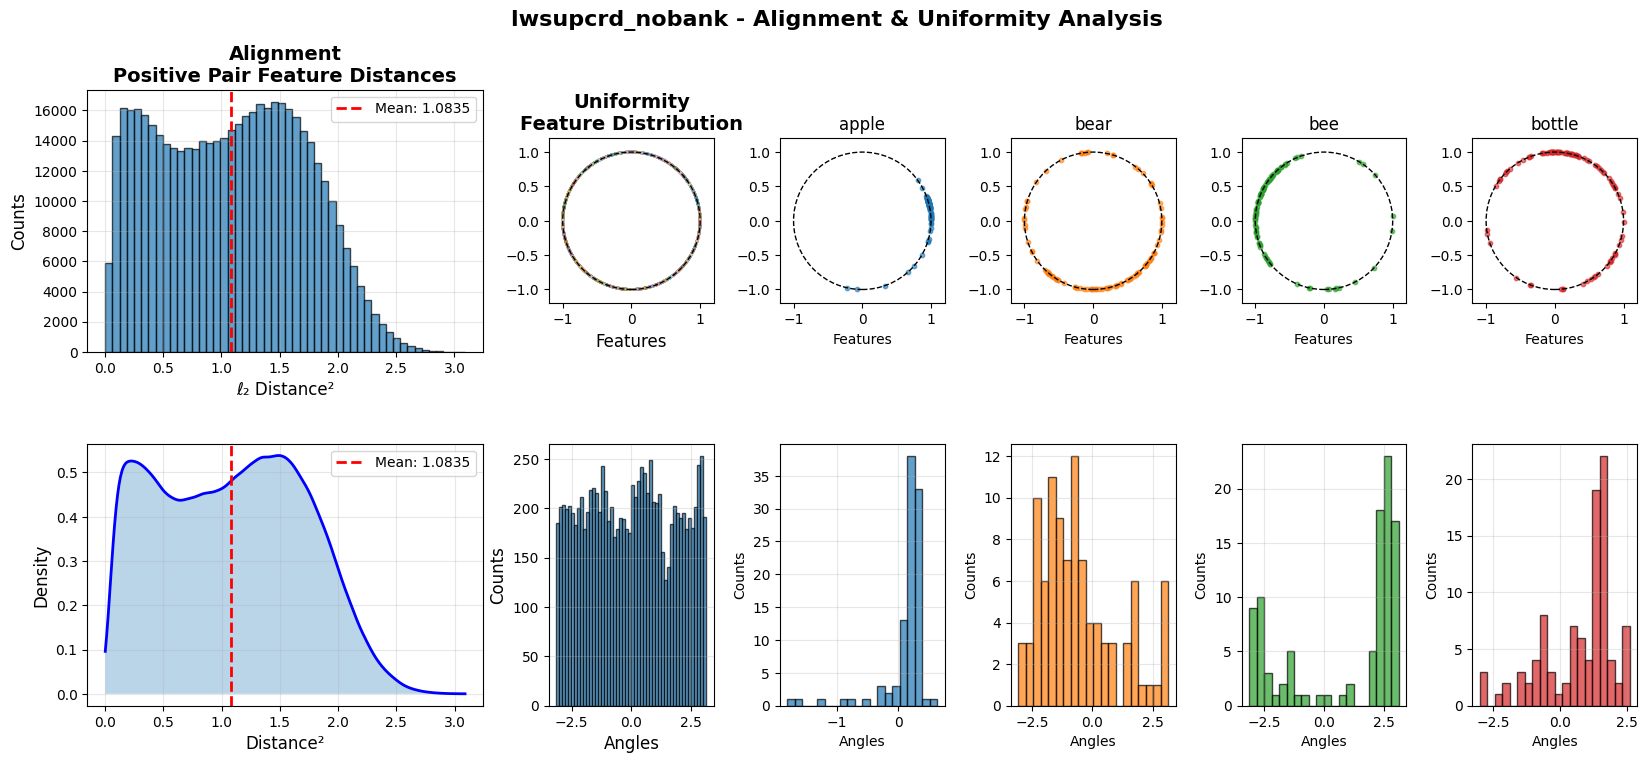


VISUALIZING: LWSUPCRD_BANK4096
📊 Generating t-SNE visualization...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


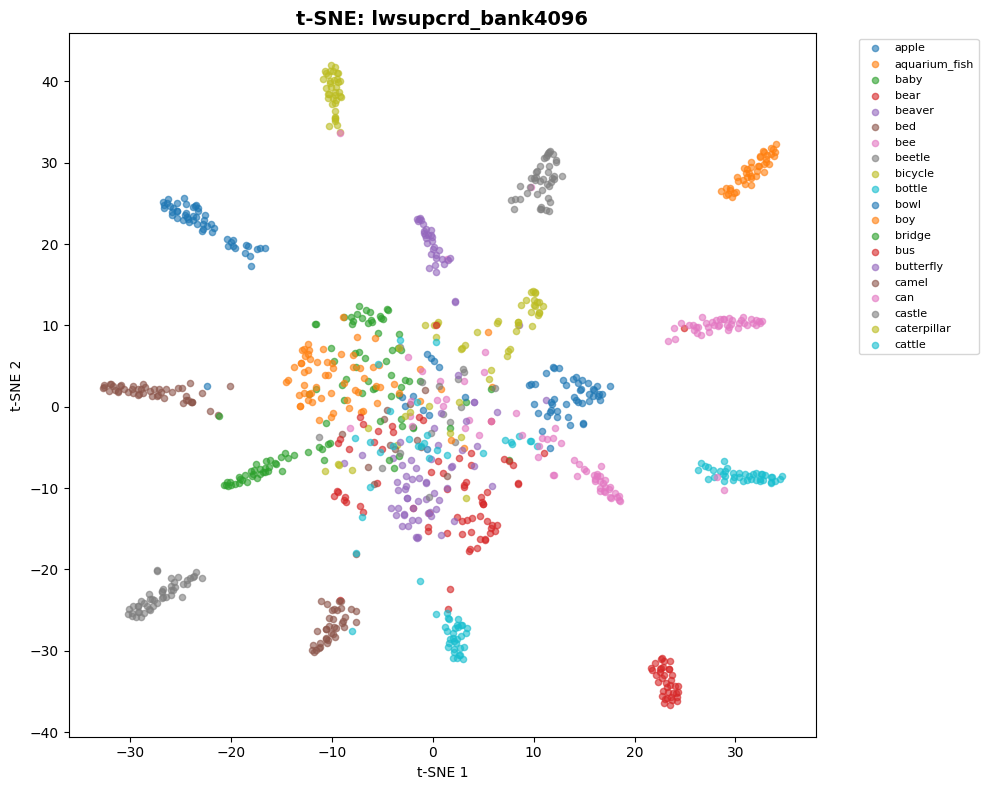

✓ t-SNE visualization complete
📊 Generating 3D hypersphere distribution...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 69.73it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running PCA to reduce dimensionality...
PCA Stage 1 (64D → 10D): 35.90% variance captured
PCA Stage 2 (10D → 3D): 31.72% of 10D captured
Total variance in 3D: 11.39% of original 64D
✓ Saved interactive plot to plots/lwsupcrd_bank4096_hypersphere.html
   → Open in browser to view and rotate



HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.4168
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9089
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 2.1807
  → Higher = better overall (clear clusters)

📊 Computing alignment & uniformity...
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:01<00:00, 70.78it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:01<00:00, 53.44it/s]


Computing uniformity (vectorized pairwise distances)...
Computing angular distribution...

WANG & ISOLA METRICS: lwsupcrd_bank4096
Alignment Loss (↓ better):     0.8336
  → Avg positive pair distance²

Uniformity Loss (↓ better):    -3.5073
  → log(E[exp(-2||zi - zj||²)])

SUPPLEMENTARY METRICS
Alignment mean ℓ2:             0.8257
Alignment std:                 0.3897
Angle std:                     1.8290

✓ Saved comprehensive visualization to plots/lwsupcrd_bank4096_alignment.png


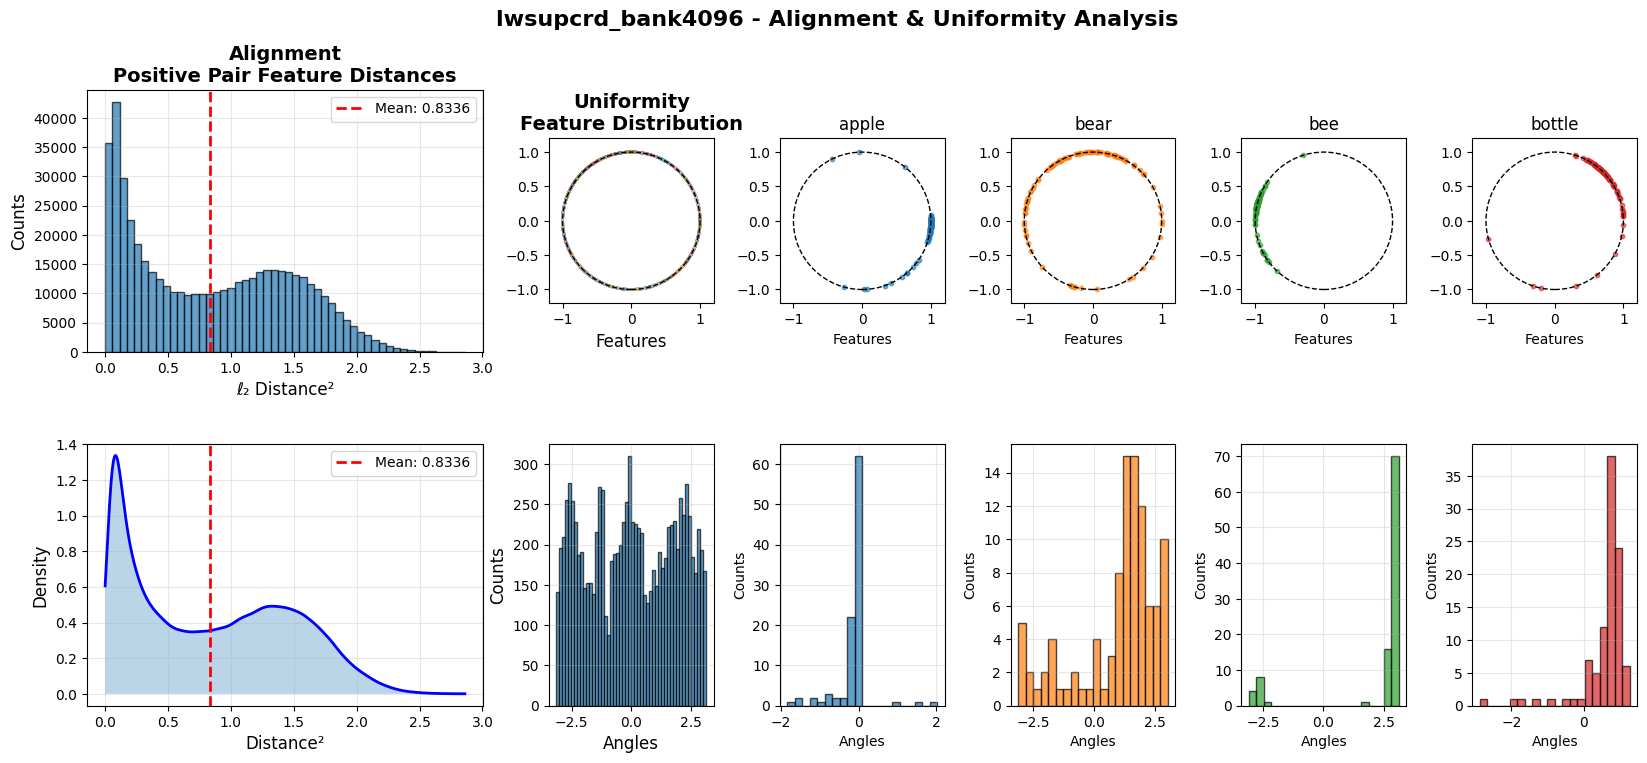



MEMORY BANK ABLATION - COMPREHENSIVE RESULTS

Method                         Bank     Test Acc   Gap      Align↓     Uniform↓   Sep↑    
----------------------------------------------------------------------------------------------------
LW-SupCRD                      4096        75.63%  20.09%    0.8336   -3.5073  2.1807
LW-SupCRD                      None        74.76%  14.96%    1.0835   -3.7314  1.8590
Baseline CRD                   4096        69.56%   9.01%    0.8098   -2.0739  0.6332
Baseline CRD                   None        68.15%   5.55%    0.9162   -2.2804  0.6225

📊 KEY FINDINGS:
----------------------------------------------------------------------------------------------------

1. Baseline CRD:
   No bank:  68.15%
   + Bank:   69.56%
   Δ:        +1.41% (improved)

2. LW-SupCRD:
   No bank:  74.76%
   + Bank:   75.63%
   Δ:        +0.87% (improved)

3. Best configuration: lwsupcrd_bank4096 with 75.63%

✓ All visualizations complete!


In [21]:
# ============================================================
# MEMORY BANK ABLATION - PART 3: Visualizations & Comparison
# ============================================================
# Store all metrics
all_metrics = {}

for model_name in [
    "baseline_crd_nobank",
    "baseline_crd_bank4096",
    "lwsupcrd_nobank",
    "lwsupcrd_bank4096",
]:
    print(f"\n{'='*60}")
    print(f"VISUALIZING: {model_name.upper()}")
    print(f"{'='*60}")

    # Load model
    student = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)
    student.load_state_dict(
        torch.load(f"pth_models/student_{model_name}_{STUDENT_ARCH}_cifar100.pth")
    )
    student.eval()

    # 1. t-SNE Visualization
    print("📊 Generating t-SNE visualization...")
    visualize_latents(
        student,
        test_loader,
        device,
        title=f"{model_name}",
        sample_classes=sample_classes,
    )
    print(f"✓ t-SNE visualization complete")

    # 2. Hypersphere Distribution (3D Interactive)
    print("📊 Generating 3D hypersphere distribution...")
    hypersphere_metrics = visualize_hypersphere_distribution(
        student,
        test_loader,
        device,
        title=f"{model_name}",
        save_path=f"plots/{model_name}_hypersphere.png",
    )

    # 3. Alignment & Uniformity Analysis
    print("\n📊 Computing alignment & uniformity...")
    alignment_metrics = visualize_alignment_uniformity(
        student,
        test_loader,
        device,
        title=f"{model_name}",
        save_path=f"plots/{model_name}_alignment.png",
    )

    # Store all metrics (use correct keys from results dict)
    all_metrics[model_name] = {
        "test_acc": results[model_name]["final_test_acc"],  # ✅ FIXED
        "train_acc": results[model_name]["train_acc"],
        "gap": results[model_name]["train_acc"]
        - results[model_name]["final_test_acc"],  # ✅ FIXED
        "intra_class": hypersphere_metrics["intra_class_dist"],
        "inter_class": hypersphere_metrics["inter_class_dist"],
        "separation": hypersphere_metrics["separation_ratio"],
        "alignment": alignment_metrics["alignment"],
        "uniformity": alignment_metrics["uniformity"],
    }


# ============================================================
# FINAL COMPARISON TABLE
# ============================================================
print("\n\n" + "=" * 100)
print("MEMORY BANK ABLATION - COMPREHENSIVE RESULTS")
print("=" * 100)
print()

# Header
print(
    f"{'Method':<30} {'Bank':<8} {'Test Acc':<10} {'Gap':<8} {'Align↓':<10} {'Uniform↓':<10} {'Sep↑':<8}"
)
print("-" * 100)

# Sort by test accuracy
sorted_models = sorted(
    all_metrics.items(), key=lambda x: x[1]["test_acc"], reverse=True
)

for model_name, metrics in sorted_models:
    method = (
        "Baseline CRD"
        if "crd" in model_name and "lwsupcrd" not in model_name
        else "LW-SupCRD"
    )
    bank = "4096" if "bank4096" in model_name else "None"

    print(
        f"{method:<30} {bank:<8} {metrics['test_acc']:>8.2f}% {metrics['gap']:>6.2f}% "
        f"{metrics['alignment']:>9.4f} {metrics['uniformity']:>9.4f} {metrics['separation']:>7.4f}"
    )

print("=" * 100)

# Key findings
print("\n📊 KEY FINDINGS:")
print("-" * 100)

crd_nobank = all_metrics["baseline_crd_nobank"]["test_acc"]
crd_bank = all_metrics["baseline_crd_bank4096"]["test_acc"]
crd_delta = crd_bank - crd_nobank

lwsupcrd_nobank = all_metrics["lwsupcrd_nobank"]["test_acc"]
lwsupcrd_bank = all_metrics["lwsupcrd_bank4096"]["test_acc"]
lwsupcrd_delta = lwsupcrd_bank - lwsupcrd_nobank

print(f"\n1. Baseline CRD:")
print(f"   No bank:  {crd_nobank:.2f}%")
print(f"   + Bank:   {crd_bank:.2f}%")
print(
    f"   Δ:        {crd_delta:+.2f}% {'(improved)' if crd_delta > 0 else '(degraded)'}"
)

print(f"\n2. LW-SupCRD:")
print(f"   No bank:  {lwsupcrd_nobank:.2f}%")
print(f"   + Bank:   {lwsupcrd_bank:.2f}%")
print(
    f"   Δ:        {lwsupcrd_delta:+.2f}% {'(improved)' if lwsupcrd_delta > 0 else '(degraded)'}"
)

print(
    f"\n3. Best configuration: {sorted_models[0][0]} with {sorted_models[0][1]['test_acc']:.2f}%"
)
print("\n" + "=" * 100)


# Convert numpy types before saving
def convert_to_native(obj):
    if isinstance(obj, dict):
        return {k: convert_to_native(v) for k, v in obj.items()}
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    return obj


print("✓ All visualizations complete!")

---
## FINAL RESULTS SUMMARY



In [22]:
print("\n" + "=" * 80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("=" * 80)

all_results = {
    "teacher": acc_teacher,
    "undistilled_student": acc_undistilled,
    "baseline_crd": acc_baseline_crd,
    "baseline_supcon": acc_baseline,
}
all_results.update(results_alpha)
all_results.update(results_beta)
all_results.update(results_temp)

# Separate teacher from student methods
student_results = {k: v for k, v in all_results.items() if k != "teacher"}

# Sort by accuracy
sorted_results = sorted(all_results.items(), key=lambda x: x[1], reverse=True)
sorted_student_results = sorted(
    student_results.items(), key=lambda x: x[1], reverse=True
)

print(f"\n{'Method':<40} {'Test Acc':>12} {'vs Teacher':>12}")
print("-" * 80)
for method, acc in sorted_results:
    diff = acc - acc_teacher
    sign = "+" if diff > 0 else ""
    print(f"{method:<40} {acc:>11.2f}% {sign}{diff:>11.2f}%")

# Save comprehensive results
comprehensive_results = {
    "architecture": {
        "teacher": TEACHER_ARCH,
        "student": STUDENT_ARCH,
    },
    "config": {
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "epochs_teacher": EPOCHS_TEACHER,
        "epochs_student": EPOCHS_STUDENT,
        "temperature": TEMP,
    },
    "results": all_results,
    "best_student_method": sorted_student_results[0][0],
    "best_student_accuracy": sorted_student_results[0][1],
    "teacher_accuracy": acc_teacher,
}

with open(f"json_results/comprehensive_results_{STUDENT_ARCH}_cifar100.json", "w") as f:
    json.dump(comprehensive_results, f, indent=2)

print(
    f"\n✓ Results saved to json_results/comprehensive_results_{STUDENT_ARCH}_cifar100.json"
)
print("=" * 80)


COMPREHENSIVE RESULTS SUMMARY

Method                                       Test Acc   vs Teacher
--------------------------------------------------------------------------------
teacher                                        80.75%        0.00%
0.07                                           73.35%       -7.40%
10.0                                           73.19%       -7.56%
2.0                                            71.78%       -8.97%
12.0                                           71.31%       -9.44%
5.0                                            70.63%      -10.12%
1.0                                            70.46%      -10.29%
baseline_supcon                                69.08%      -11.67%
0.05                                           68.08%      -12.67%
baseline_crd                                   68.05%      -12.70%
undistilled_student                            67.93%      -12.82%

✓ Results saved to json_results/comprehensive_results_resnet18_cifar100.json
